<a href="https://colab.research.google.com/github/suchith1012/Mitosis-detection-based-on-features-from-breast-cancer-histology-slide-images/blob/main/Code/Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdution 

In this article we are going to extract the features from the images and use optimizer technique and classifer to classify the Mitosis and Non Mitosis

#### Extracting data from zip file

In [1]:
!unzip "/content/MandNM.zip" -d "/content"

Archive:  /content/MandNM.zip
   creating: /content/MandNM/mitosis/
  inflating: /content/MandNM/mitosis/A00_01_01_CZ8UV4CK9-1a2574be1ed31c6659b0878de25f8c97.png  
  inflating: /content/MandNM/mitosis/A00_01_03_KB9DE4KB4-c2df9c018c36418510d2f97c8663107a.png  
  inflating: /content/MandNM/mitosis/A00_01_04_IX1CU9GK9-3637987eab333b0a1fb45e0d371e40f0.png  
  inflating: /content/MandNM/mitosis/A00_02_01_UO7GX5ME4-6f9fb90aae8b319e23f60e3ad7689206.png  
  inflating: /content/MandNM/mitosis/A00_02_02_BR1BN6VV5-c0e29e47f8c0de151949211b6ee05162.png  
  inflating: /content/MandNM/mitosis/A00_04_02_TE4ZN7PE8-2ebfeecaa808bac4a91dd2aefcc809c6.png  
  inflating: /content/MandNM/mitosis/A00_04_03_UI4CC1RM0-2306853da60e9fa327ef7465eadcfc26.png  
  inflating: /content/MandNM/mitosis/A00_05_01_XD7OS8HK1-27ca04e0c24c5123a09e3f35018b1163.png  
  inflating: /content/MandNM/mitosis/A00_06_01_FQ0DU4HG1-b2259461ba2f82b9e7ea0adda978a808.png  
  inflating: /content/MandNM/mitosis/A00_06_02_CU6PZ1ST9-8f047482d80

#### Installing Libraries

In [2]:
!git clone https://github.com/thuijskens/scikit-hyperband.git 2>/dev/null 1>/dev/null
!cp -r scikit-hyperband/* .
!python setup.py install 2>/dev/null 1>/dev/null
!pip install scikit-optimize
!pip install sklearn-deap
!pip install tpot


     |████████████████████████████████| 100 kB 3.3 MB/s 
     |████████████████████████████████| 160 kB 6.3 MB/s 
     |████████████████████████████████| 87 kB 3.3 MB/s 
     |████████████████████████████████| 173.5 MB 12 kB/s 
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11952 sha256=0a780dbbc17e54876300cdd16b4b45df5f05c5ccf335ea5545ca2c655c8f150d
  Stored in directory: /root/.cache/pip/wheels/e2/d2/79/eaf81edb391e27c87f51b8ef901ecc85a5363dc96b8b8d71e3
Successfully built stopit
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [3]:
import matplotlib.pyplot as plt
from skimage import io,filters
import cv2
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import csv
import numpy as np
import os
from google.colab.patches import cv2_imshow
from os import path
from skimage.feature import hog,ORB, CENSURE, corner_peaks, corner_harris, BRIEF
from skimage import data, color, exposure
from PIL import Image
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler

from skimage.util import img_as_ubyte
import pandas as pd
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn import svm
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from scipy.stats import randint as sp_randint
from random import randrange as sp_randrange
from sklearn.model_selection import RandomizedSearchCV
from hyperband import HyperbandSearchCV
from skopt import Optimizer
from skopt import BayesSearchCV 
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from evolutionary_search import EvolutionaryAlgorithmSearchCV
from tpot import TPOTClassifier



In [4]:
def normalize(data):
  x = data.values 
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  df = pd.DataFrame(x_scaled)
  return df

## PCA 


In [5]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 
from sklearn.manifold import Isomap

def pca_reduction(data,n):
  pca = PCA(n_components=n)
  reduced_features = pca.fit_transform(data)
  features = reduced_features.tolist()
  return features

In [6]:
def ptoa(data):
  df = pd.DataFrame(data)
  df = df.astype(np.float32)
  df=df.replace(np.nan, 0)
  temp=df.to_numpy()
  return temp


## edge extract

In [7]:
def edgeExtract(img, bins):
    retVal = []
    #apply vertical and horizontal sobel filters to get two histogramms, once of vertical and once of horizontal edges
    #vertical
    fs = filters.sobel_v(img)
    #horizontal
    angs = filters.sobel_h(img)
    #compute histograms
    lhist = np.histogram(fs,bins,normed=True,range=(0,1))
    ahist = np.histogram(angs, bins,normed=True,range=(-180,180))
    #fuse histograms into one list
    retVal.extend(lhist[0].tolist())
    retVal.extend(ahist[0].tolist())
    return retVal

## GridSearch

In [8]:
def grid_search(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result=[]
  print('Splitted Successfully')
  def classify_svm(x_train,x_test,y_train,y_test):
    param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly','linear','sigmoid']}
    svc=svm.SVC(probability=True)
    model=GridSearchCV(svc,param_grid)
    model.fit(x_train,y_train)
    print('The svm Model is trained well with the given images',model.best_params_)
    y_pred=model.predict(x_test)
    result.append("svm:"+str(accuracy_score(y_pred,y_test)*100))
  def classify_rf(x_train,x_test,y_train,y_test):
    rfc=RandomForestClassifier(random_state=42)
    param_grid = { 'n_estimators': [1,10, 100,200, 500],'max_features': ['auto', 'sqrt', 'log2'],'max_depth' : [15,20,30,50],'criterion' :['gini', 'entropy']}
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
    CV_rfc.fit(x_train,y_train)
    print('The rf Model is trained well with the given images',CV_rfc.best_params_)
    y_rf_pred=CV_rfc.predict(x_test)
    result.append("Random forest:"+str(accuracy_score(y_rf_pred,y_test)*100))
  def classify_knn(x_train,x_test,y_train,y_test):
    rf_params = {'n_neighbors': [2, 3, 5,10,15,20]}
    clf = KNeighborsClassifier()
    grid = GridSearchCV(clf, rf_params, cv=3, scoring='accuracy')
    grid.fit(x_train, y_train)
    print("The KNN Model is trained well with the given images",grid.best_params_)
    result.append("KNN:"+str(grid.best_score_))
  classify_rf(x_train,x_test,y_train,y_test)
  classify_knn(x_train,x_test,y_train,y_test)
  classify_svm(x_train,x_test,y_train,y_test)
  return result







## Random Search optmizer

In [9]:
def random_search(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result=[]
  print('Splitted Successfully')
  def classify_rso_svm(x_train,x_test,y_train,y_test):
    rf_params = {'C': stats.uniform(0,50),"kernel":['linear','poly','rbf','sigmoid']}
    n_iter_search=20
    clf = svm.SVC(gamma='scale')
    Random_svm = RandomizedSearchCV(clf, param_distributions=rf_params,n_iter=n_iter_search,cv=3,scoring='accuracy')
    Random_svm.fit(x_train, y_train)
    print("The svm Model is trained well with the given images",Random_svm.best_params_)
    result.append("svm:"+str(Random_svm.best_score_))
  def classify_rso_rf(x_train,x_test,y_train,y_test):
    rf_params = {'n_estimators': sp_randint(10,100),"max_features":sp_randint(1,64),'max_depth': sp_randint(5,50),"min_samples_split":sp_randint(2,11),"min_samples_leaf":sp_randint(1,11),"criterion":['gini','entropy']}
    n_iter_search=20 
    clf_rf = RandomForestClassifier(random_state=0)
    Random_rf = RandomizedSearchCV(clf_rf, param_distributions=rf_params,n_iter=n_iter_search,cv=3,scoring='accuracy')
    Random_rf.fit(x_train, y_train)
    print("The rf Model is trained well with the given images",Random_rf.best_params_)
    result.append("Random forest:"+str(Random_rf.best_score_))
  def classify_rso_knn(x_train,x_test,y_train,y_test):
    rf_params = {'n_neighbors': range(1,20)}
    n_iter_search=10
    clf_knn = KNeighborsClassifier()
    Random_knn = RandomizedSearchCV(clf_knn, param_distributions=rf_params,n_iter=n_iter_search,cv=3,scoring='accuracy')
    Random_knn.fit(x_train, y_train)
    print("The KNN Model is trained well with the given images",Random_knn.best_params_)
    result.append("KNN:"+str(Random_knn.best_score_))
  classify_rso_rf(x_train,x_test,y_train,y_test)
  classify_rso_knn(x_train,x_test,y_train,y_test)
  classify_rso_svm(x_train,x_test,y_train,y_test)
  return result







## Hyperband

In [10]:
def hyperband_opt(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result=[]
  print('Splitted Successfully')
  def classify_hb_svm(x_train,x_test,y_train,y_test):
    rf_params = {'C': stats.uniform(0,50),"kernel":['linear','poly','rbf','sigmoid'],'bootstrap': [True, False]}
    clf_hb_svm = svm.SVC(gamma='scale')
    hyper_hb_svm = HyperbandSearchCV(clf_hb_svm, param_distributions =rf_params,cv=3,min_iter=1,max_iter=50,scoring='roc_auc',resource_param='C')
    hyper_hb_svm.fit(x_train, y_train)
    print("The svm Model is trained well with the given images",hyper_hb_svm.best_params_)
    result.append("svm:"+str(hyper_hb_svm.best_score_))
  def classify_hb_rf(x_train,x_test,y_train,y_test):
    rf_params = {'n_estimators': sp_randint(10,100),'bootstrap': [True, False],"max_features":sp_randint(1,64),'max_depth': sp_randint(5,50),"min_samples_split":sp_randint(2,11),"min_samples_leaf":sp_randint(1,11),"criterion":['gini','entropy']}
    clf_hb_rf = RandomForestClassifier(random_state=0)
    hyper_rf = HyperbandSearchCV(clf_hb_rf, param_distributions =rf_params,cv=3,min_iter=10,max_iter=100,scoring='roc_auc')
    hyper_rf.fit(x_train, y_train)
    print("The rf Model is trained well with the given images",hyper_rf.best_params_)
    result.append("Random forest:"+str(hyper_rf.best_score_))
  def classify_hb_knn(x_train,x_test,y_train,y_test):
    rf_params = {'n_neighbors': range(1,20),'bootstrap': [True, False]}
    clf_hb_knn = KNeighborsClassifier()
    hyper_knn = HyperbandSearchCV(clf_hb_knn, param_distributions =rf_params,cv=3,min_iter=1,max_iter=20,scoring='roc_auc',resource_param='n_neighbors')
    hyper_knn.fit(x_train, y_train)
    print("The KNN Model is trained well with the given images",hyper_knn.best_params_)
    result.append("KNN:"+str(hyper_knn.best_score_))
  classify_hb_rf(x_train,x_test,y_train,y_test)
  classify_hb_knn(x_train,x_test,y_train,y_test)
  classify_hb_svm(x_train,x_test,y_train,y_test)
  return result







## Bayesian Optimization with Gaussian Process (BO-GP)

In [11]:
def bogp(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result=[]
  print('Splitted Successfully')
  def classify_bogp_svm(x_train,x_test,y_train,y_test):
    rf_params = {'C':[0.1,1,10,100],"kernel":['linear','poly','rbf','sigmoid']}
    clf_svm = svm.SVC(gamma='scale')
    Bayes_svm = BayesSearchCV(clf_svm, rf_params,cv=3,n_iter=20, n_jobs=-1,scoring='accuracy')
    Bayes_svm.fit(x_train, y_train)
    print("The svm Model is trained well with the given images",Bayes_svm.best_params_)
    result.append("svm:"+str(Bayes_svm.best_score_))
  def classify_bogp_rf(x_train,x_test,y_train,y_test):
    rf_params = {'n_estimators': Integer(10,100),"max_features":Integer(1,64),'max_depth': Integer(5,50),"min_samples_split":Integer(2,11),"min_samples_leaf":Integer(1,11),"criterion":['gini','entropy']}
    clf_bogp_rf = RandomForestClassifier(random_state=0)
    Bayes_rf = BayesSearchCV(clf_bogp_rf, rf_params,cv=3,n_iter=20, n_jobs=-1,scoring='accuracy')
    Bayes_rf.fit(x_train, y_train)
    print("The rf Model is trained well with the given images",Bayes_rf.best_params_)
    result.append("Random forest:"+str(Bayes_rf.best_score_))
  def classify_bogp_knn(x_train,x_test,y_train,y_test):
    rf_params = {'n_neighbors': Integer(1,20)}
    clf_bogp_knn = KNeighborsClassifier()
    Bayes_knn = BayesSearchCV(clf_bogp_knn, rf_params,cv=3,n_iter=10, n_jobs=-1,scoring='accuracy')
    Bayes_knn.fit(x_train, y_train)
    print("The KNN Model is trained well with the given images",Bayes_knn.best_params_)
    result.append("KNN:"+str(Bayes_knn.best_score_))
  classify_bogp_rf(x_train,x_test,y_train,y_test)
  classify_bogp_knn(x_train,x_test,y_train,y_test)
  classify_bogp_svm(x_train,x_test,y_train,y_test)
  return result

## skopt.gp_minimize

In [12]:


def skopt_gp(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result=[]
  print('Splitted Successfully')
  def classify_skgp_svm(x_train,x_test,y_train,y_test):
    reg = svm.SVC(gamma='scale')
    space  = [Real(0.01, 50, name='C'),Categorical(['linear','poly','rbf','sigmoid'], name='kernel')]
    @use_named_args(space)
    def objective(**params):
      reg.set_params(**params)
      return -np.mean(cross_val_score(reg, x_train, y_train, cv=3, n_jobs=-1,scoring="accuracy"))
    res_svm = gp_minimize(objective, space, n_calls=20, random_state=0)
    # print("The svm Model is trained well with the given images",Bayes_svm.best_params_)
    result.append("svm:"+str(-res_svm.fun))
  def classify_skgp_rf(x_train,x_test,y_train,y_test):
    reg = RandomForestClassifier()
    space  = [Integer(10, 100, name='n_estimators'),Integer(5, 50, name='max_depth'),Integer(1, 64, name='max_features'),Integer(2, 11, name='min_samples_split'),Integer(1, 11, name='min_samples_leaf'),Categorical(['gini', 'entropy'], name='criterion'),]
    @use_named_args(space)
    def objective(**params):
      reg.set_params(**params)
      return -np.mean(cross_val_score(reg, x_train, y_train, cv=3, n_jobs=-1,scoring="accuracy"))
    res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)
    result.append("Random forest:"+str(-res_gp.fun))
  def classify_skgp_knn(x_train,x_test,y_train,y_test):
    reg = KNeighborsClassifier()
    space  = [Integer(1, 20, name='n_neighbors')]
    @use_named_args(space)
    def objective(**params):
      reg.set_params(**params)
      return -np.mean(cross_val_score(reg, x_train, y_train, cv=3, n_jobs=-1,scoring="accuracy"))
    res_knn = gp_minimize(objective, space, n_calls=10, random_state=0)
    # print("The KNN Model is trained well with the given images",Bayes_knn.best_params_)
    result.append("KNN:"+str(-res_knn.fun))
  classify_skgp_rf(x_train,x_test,y_train,y_test)
  classify_skgp_knn(x_train,x_test,y_train,y_test)
  classify_skgp_svm(x_train,x_test,y_train,y_test)
  return result

## Bayesian Optimization with Tree-structured Parzen Estimator (TPE)

In [13]:
def bo_tpe(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result=[]
  print('Splitted Successfully')
  def classify_botpe_svm(x_train,x_test,y_train,y_test):
    def objective(params):
      params = {'C': abs(float(params['C'])), "kernel":str(params['kernel'])}
      clf = svm.SVC(gamma='scale', **params)
      score = cross_val_score(clf, x_train, y_train, scoring='accuracy', cv=StratifiedKFold(n_splits=3)).mean()
      return {'loss':-score, 'status': STATUS_OK }
    space = {'C': hp.normal('C', 0, 50),"kernel":hp.choice('kernel',['linear','poly','rbf','sigmoid'])}
    best_svm = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
    result.append("svm:"+str(best_svm))
  def classify_botpe_rf(x_train,x_test,y_train,y_test):
    def objective(params):
      params = {'n_estimators': int(params['n_estimators']), 'max_depth': int(params['max_depth']),'max_features': int(params['max_features']),"min_samples_split":int(params['min_samples_split']),"min_samples_leaf":int(params['min_samples_leaf']),"criterion":str(params['criterion'])}
      clf = RandomForestClassifier( **params)
      score = cross_val_score(clf, x_train, y_train, scoring='accuracy', cv=StratifiedKFold(n_splits=3)).mean()
      return {'loss':-score, 'status': STATUS_OK }
    space = {'n_estimators': hp.quniform('n_estimators', 10, 100, 1),'max_depth': hp.quniform('max_depth', 5, 50, 1),"max_features":hp.quniform('max_features', 1, 64, 1),"min_samples_split":hp.quniform('min_samples_split',2,11,1),"min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),"criterion":hp.choice('criterion',['gini','entropy'])}
    best_rf = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
    result.append("Random forest:"+str(best_rf))
  def classify_botpe_knn(x_train,x_test,y_train,y_test):
    def objective(params):
      params = {'n_neighbors': abs(int(params['n_neighbors']))}
      clf = KNeighborsClassifier( **params)
      score = cross_val_score(clf, x_train, y_train, scoring='accuracy', cv=StratifiedKFold(n_splits=3)).mean()
      return {'loss':-score, 'status': STATUS_OK }
    space = {'n_neighbors': hp.quniform('n_neighbors', 1, 20, 1),}
    best_knn = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
    result.append("KNN:"+str(best_knn))
  classify_botpe_rf(x_train,x_test,y_train,y_test)
  classify_botpe_knn(x_train,x_test,y_train,y_test)
  classify_botpe_svm(x_train,x_test,y_train,y_test)
  return result

## Genetic Algorithm

In [14]:
def genetic(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result=[]
  print('Splitted Successfully')
  def classify_g_svm(x_train,x_test,y_train,y_test):
    rf_params = {'C': np.random.uniform(0,50,1000),"kernel":['linear','poly','rbf','sigmoid']}
    clf_g_svm = svm.SVC(gamma='scale')
    ga1_svm = EvolutionaryAlgorithmSearchCV(estimator=clf_g_svm,
                                   params=rf_params,
                                   scoring="accuracy",
                                   cv=3,
                                   verbose=1,
                                   population_size=10,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=1)
    ga1_svm.fit(x_train, y_train)
    print('The rf Model is trained well with the given images',ga1_svm.best_params_)
    result.append("svm:"+str(ga1_svm.best_score_))
  def classify_g_rf(x_train,x_test,y_train,y_test):
    rf_params = {'n_estimators': np.logspace(1,1.8,num = 10 ,base=20,dtype='int'),'max_depth': np.logspace(1,2,num = 10 ,base=10,dtype='int'),"max_features":np.logspace(0.2,1,num = 5 ,base=8,dtype='int'),"min_samples_split":np.logspace(0.4, 1, num=5, base=10, dtype='int'),"min_samples_leaf":np.logspace(0.1,1,num = 5 ,base=11,dtype='int'),"criterion":['gini','entropy']}
    rf_params = {'n_estimators': range(10,100),"max_features":range(1,64),'max_depth': range(5,50),"min_samples_split":range(2,11),"min_samples_leaf":range(1,11),"criterion":['gini','entropy']}
    clf_g_rf = RandomForestClassifier(random_state=0)
    ga1_rf = EvolutionaryAlgorithmSearchCV(estimator=clf_g_rf,
                                   params=rf_params,
                                   scoring="accuracy",
                                   cv=3,
                                   verbose=1,
                                   population_size=10,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=1)
    ga1_rf.fit(x_train, y_train)
    print('The rf Model is trained well with the given images',ga1_rf.best_params_)
    result.append("Random forest:"+str(ga1_rf.best_score_))
  def classify_g_knn(x_train,x_test,y_train,y_test):
    rf_params = {'n_neighbors': range(1,20),}
    clf_g_knn = KNeighborsClassifier()
    ga1_knn = EvolutionaryAlgorithmSearchCV(estimator=clf_g_knn,
                                   params=rf_params,
                                   scoring="accuracy",
                                   cv=3,
                                   verbose=1,
                                   population_size=10,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=1)
    ga1_knn.fit(x_train, y_train)
    print('The knn Model is trained well with the given images',ga1_knn.best_params_)
    result.append("KNN:"+str(ga1_knn.best_score_))
  classify_g_rf(x_train,x_test,y_train,y_test)
  classify_g_knn(x_train,x_test,y_train,y_test)
  classify_g_svm(x_train,x_test,y_train,y_test)
  return result

## TPOT

In [15]:
def tpot(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result=[]
  print('Splitted Successfully')
  def classify_tpot_svm(x_train,x_test,y_train,y_test):
    parameters = {'C': np.random.uniform(0,50,1000),"kernel":['linear','poly','rbf','sigmoid']}
    ga2_svm = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.svm.SVC': parameters}, 
                                 cv = 3, scoring = 'accuracy')
    ga2_svm.fit(x_train, y_train)
    y_rf_pred=ga2_svm.predict(x_test)
    result.append("svm:"+str(accuracy_score(y_rf_pred,y_test)*100))
  def classify_tpot_rf(x_train,x_test,y_train,y_test):
    parameters = {'n_estimators': range(20,200),"max_features":range(1,64),'max_depth': range(10,100),"min_samples_split":range(2,11),"min_samples_leaf":range(1,11),"criterion":['gini','entropy']}
    ga2_rf = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.ensemble.RandomForestClassifier': parameters}, 
                                 cv = 3, scoring = 'accuracy')
    ga2_rf.fit(x_train, y_train)
    y_rf_pred=ga2_rf.predict(x_test)
    result.append("Random forest:"+str(accuracy_score(y_rf_pred,y_test)*100))
  def classify_tpot_knn(x_train,x_test,y_train,y_test):
    parameters = {'n_neighbors': range(1,20),}
    ga2_knn = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.neighbors.KNeighborsClassifier': parameters}, 
                                 cv = 3, scoring = 'accuracy')
    ga2_knn.fit(x_train, y_train)
    y_rf_pred=ga2_knn.predict(x_test)
    result.append("knn:"+str(accuracy_score(y_rf_pred,y_test)*100))
  classify_tpot_rf(x_train,x_test,y_train,y_test)
  classify_tpot_knn(x_train,x_test,y_train,y_test)
  classify_tpot_svm(x_train,x_test,y_train,y_test)
  return result

## Histogram of Oriented Gradients(HOG) 


*   HOG descriptor focuses on the structure or the shape of an object
*   HOG would generate a Histogram for each  regions separately. The histograms are created using the gradients and orientations of the pixel values, hence the name ‘Histogram of Oriented Gradients’

### Extracting hog features

[0.13967154 0.07405471 0.00404335 ... 0.0584853  0.0459223  0.03301468]


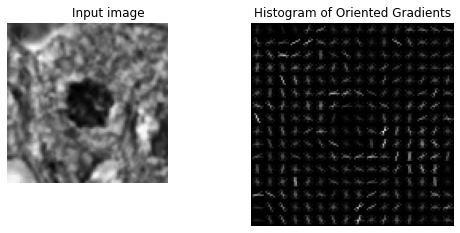

In [16]:
img = io.imread(r"/content/MandNM/mitosis/A00_01_01_CZ8UV4CK9-1a2574be1ed31c6659b0878de25f8c97.png")

image = color.rgb2gray(img)

resized = cv2.resize(image, (128, 128), interpolation=cv2.INTER_AREA)
fd, hog_image = hog(resized,visualize=True)
print(fd)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box')
plt.show()

(15876,)


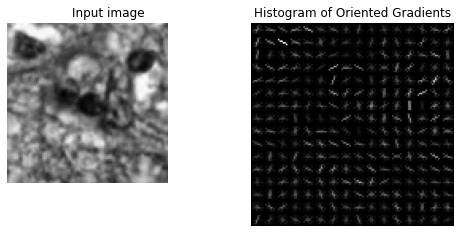

In [17]:
img = io.imread(r"/content/MandNM/nonmitosis/A00_01_01_VX9XQ1HO9-c9862dc6a1df71ff47c2f543a819cffe.png")

image = color.rgb2gray(img)

resized = cv2.resize(image, (128, 128), interpolation=cv2.INTER_AREA)
fd, hog_image = hog(resized,visualize=True)
print(fd.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box')
plt.show()

In [18]:
category = []
hogArray = []
for folder in os.listdir("/content/MandNM/"):

    if(folder == ".DS_Store"):
        continue

    # Loop through each category
    for filename in os.listdir(path.join("/content/MandNM", folder)):

        # Select images which are png and jpg only
        if (filename[-3:] == "png" or filename[-3:] == "jpg"):

            # Get full image by joining
            # all the path to the image
            image = path.join("MandNM", folder, filename)

            # Use open cv to read the image
            img = cv2.imread(image)
            image_grey = color.rgb2gray(img)

            # Resize the image to (64, 128)
            # Default for hog
            resized = cv2.resize(image_grey, (128, 128), interpolation=cv2.INTER_AREA)

            # Compute the Hog Features
            fd, hog_image = hog(resized,visualize=True)
            
            category.append(folder)
            hogArray.append(fd)



# convert the extracted features
# from array to vector
hogArray_np = np.array(hogArray)


print("Total feature extracted from the each image",len(hogArray_np[0]))

Total feature extracted from the each image 15876


In [19]:
hog_df = pd.DataFrame(hogArray_np)
hog_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,15836,15837,15838,15839,15840,15841,15842,15843,15844,15845,15846,15847,15848,15849,15850,15851,15852,15853,15854,15855,15856,15857,15858,15859,15860,15861,15862,15863,15864,15865,15866,15867,15868,15869,15870,15871,15872,15873,15874,15875
0,0.041568,0.011448,0.022096,0.111257,0.134234,0.077832,0.033267,0.028624,0.000000,0.037706,0.033932,0.041412,0.147958,0.082004,0.109131,0.009299,0.025139,0.033464,0.298431,0.021800,0.019207,0.000000,0.018991,0.000000,0.000000,0.000000,0.298431,0.028244,0.025295,0.018748,0.068553,0.055084,0.018147,0.053475,0.040612,0.008926,0.040916,0.046666,0.126872,0.044731,...,0.033020,0.051338,0.130400,0.140737,0.058003,0.080079,0.008680,0.015716,0.075544,0.013621,0.029609,0.053934,0.271032,0.271032,0.012827,0.012710,0.000000,0.000000,0.001925,0.000000,0.017568,0.094652,0.271032,0.236455,0.217243,0.082145,0.059224,0.049597,0.092517,0.100556,0.000000,0.271032,0.236999,0.086708,0.006004,0.038789,0.006130,0.022779,0.127199,0.219228
1,0.122083,0.083443,0.065366,0.059477,0.084475,0.043467,0.009653,0.020344,0.043084,0.209785,0.026748,0.229019,0.056841,0.059430,0.200150,0.165492,0.030082,0.001318,0.084621,0.013944,0.084029,0.119993,0.115613,0.079972,0.050504,0.012522,0.078185,0.015539,0.046826,0.068369,0.191823,0.125028,0.032013,0.041283,0.030486,0.033260,0.021426,0.043394,0.008537,0.028424,...,0.163151,0.106552,0.104038,0.177465,0.012804,0.092364,0.070098,0.062812,0.147578,0.127330,0.083726,0.060403,0.017904,0.063918,0.036698,0.208066,0.102017,0.119825,0.037779,0.067326,0.021154,0.001356,0.211768,0.136923,0.053406,0.069067,0.025153,0.021219,0.020587,0.042433,0.176567,0.200460,0.211768,0.153582,0.211768,0.204839,0.054693,0.066235,0.038511,0.033994
2,0.038868,0.023015,0.031279,0.026527,0.132031,0.236090,0.056483,0.024242,0.009522,0.209733,0.085096,0.073137,0.055052,0.063390,0.027320,0.102609,0.113822,0.097818,0.147927,0.023257,0.046357,0.042430,0.071649,0.236090,0.071337,0.185778,0.092799,0.073037,0.083346,0.040071,0.080142,0.132231,0.044836,0.026321,0.026680,0.064108,0.056736,0.078260,0.034331,0.029568,...,0.059796,0.015207,0.020526,0.025163,0.025013,0.061663,0.164686,0.076264,0.194977,0.150932,0.142979,0.196116,0.037198,0.234487,0.080982,0.126098,0.046355,0.017043,0.012252,0.006240,0.052988,0.100374,0.174669,0.064674,0.143261,0.099553,0.133003,0.234487,0.068688,0.006931,0.038040,0.101108,0.065563,0.011388,0.033967,0.124901,0.234487,0.038372,0.050732,0.066440
3,0.077361,0.019461,0.024860,0.004389,0.102364,0.012566,0.237514,0.107932,0.030174,0.072014,0.025920,0.000000,0.025629,0.035548,0.085113,0.113687,0.236174,0.174242,0.014961,0.006185,0.016150,0.013551,0.034251,0.012603,0.016893,0.023659,0.019700,0.024843,0.000000,0.000000,0.005830,0.050993,0.037727,0.264942,0.264942,0.065515,0.024686,0.003214,0.023415,0.014106,...,0.021742,0.087124,0.113235,0.157723,0.018952,0.023089,0.049244,0.209538,0.251804,0.096517,0.058635,0.096930,0.011618,0.091833,0.008829,0.055201,0.010592,0.086137,0.251804,0.244371,0.251804,0.067625,0.041761,0.014535,0.005177,0.019903,0.017651,0.073298,0.158998,0.075371,0.066728,0.112427,0.060794,0.079860,0.081896,0.180943,0.059992,0.222105,0.162635,0.093058
4,0.027016,0.001836,0.006197,0.035907,0.267728,0.167164,0.005249,0.007806,0.000000,0.036218,0.000000,0.024235,0.145463,0.222061,0.181998,0.017036,0.018297,0.007859,0.113465,0.028255,0.010489,0.025965,0.048095,0.182743,0.026075,0.035176,0.089173,0.012931,0.001958,0.009020,0.005284,0.074425,0.267728,0.267728,0.038920,0.012800,0.001297,0.000736,0.002166,0.003085,...,0.116686,0.115605,0.126013,0.046693,0.026894,0.001772,0.018318,0.003781,0.071180,0.077133,0.316398,0.239159,0.114351,0.019067,0.015576,0.005942,0.026994,0.049870,0.011548,0.011710,0.011658,0.005131,0.034498,0.027922,0.016520,0.007460,0.041639,0.083614,0.049342,0.003732,0.018337,0.071912,0.018018,0.024161,0.055660,0.085753,0.066772,0.036621,0.026182,0.051258
...,...,...,...

In [20]:
hog_features=pca_reduction(hogArray_np,100)

In [21]:
csvData = []
for id, line in enumerate(hog_features):
  if(id==0):
    temp=[]
    for i in range(0,len(line)):
      temp.append("value"+str(i))
    temp.insert(len(temp),"label")
    csvData.append(temp)

  newImg = line

    # Prepend the category of each image to
    # the begining of the features
  newImg.insert(len(newImg), category[id])
  csvData.append(newImg)


# Save the csv file
with open('result_hog_data.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()

print("Done Extracting Features")

Done Extracting Features


In [22]:
import pandas as pd

feature_hog=pd.read_csv("result_hog_data.csv")
feature_hog['label'] = feature_hog['label'].map({'nonmitosis': 1, 'mitosis': 0})
feature_hog

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16,value17,value18,value19,value20,value21,value22,value23,value24,value25,value26,value27,value28,value29,value30,value31,value32,value33,value34,value35,value36,value37,value38,value39,...,value61,value62,value63,value64,value65,value66,value67,value68,value69,value70,value71,value72,value73,value74,value75,value76,value77,value78,value79,value80,value81,value82,value83,value84,value85,value86,value87,value88,value89,value90,value91,value92,value93,value94,value95,value96,value97,value98,value99,label
0,-0.568157,0.135462,0.556369,2.056994,0.319020,0.305293,1.174318,0.447609,-1.027827,-0.022728,-0.176208,-0.409242,-1.088762,-0.399689,0.631683,-0.474069,-0.802758,1.419158,0.157516,0.027944,-0.671222,0.703351,-0.628487,-0.988971,0.068194,1.334961,-0.780933,-0.831190,-0.401094,0.087006,2.064536,-0.818252,-0.884561,0.213304,0.653410,-0.067185,0.685167,-0.443555,0.209305,0.083074,...,0.357630,-0.566544,0.078841,0.500724,-0.370281,0.334876,0.239010,0.399070,-0.335875,-0.858634,-1.049795,-0.056511,0.196913,-0.748019,1.438807,0.222797,-0.034735,0.350301,-0.116350,0.203390,-0.307892,-0.399068,-0.178844,-0.291672,-0.504374,-0.165183,-0.064642,0.359610,0.430337,-0.752188,-0.590924,-0.944855,-0.172210,-0.598178,-0.612886,-0.345578,-0.696999,0.040403,-1.257093,1
1,0.072851,-1.313750,-0.334711,0.735596,0.836944,-1.137316,0.673283,0.339306,-0.033689,-0.804530,-0.710488,0.230090,0.012824,1.133733,0.589468,-0.340119,-0.068117,-1.501237,-0.530902,1.804410,-0.271644,-0.442473,0.442082,-0.505874,0.567869,-0.036580,-0.266138,-0.343963,0.215486,0.704438,0.316502,-0.977805,-0.993402,-1.199579,-0.223660,-0.185075,0.243655,1.266609,-0.188020,0.354488,...,-0.261408,-0.691251,0.360527,-0.451304,-0.185424,-0.086695,0.091032,-0.380672,-0.347156,-0.170290,-0.519307,0.492995,-0.603084,-0.126479,0.521978,-0.514695,0.244463,0.509469,-0.491248,-0.023892,-0.053784,-0.019502,0.245565,-0.237877,0.299326,-0.192375,-0.396132,0.601106,0.427532,1.249653,-0.224797,-0.008890,0.241620,-0.378057,0.436383,0.066205,0.491698,-0.116023,0.391381,1
2,0.245958,2.383170,-0.137528,0.147376,0.207359,0.154139,1.297730,0.250960,-0.716890,0.456929,-0.095248,-0.027648,-0.623878,0.287021,-1.645482,0.276624,-0.778139,0.836996,-0.230591,-0.539543,-1.216490,-0.013656,-0.662654,-0.682226,0.609708,-0.410352,0.086932,0.102684,-0.068345,-0.581278,0.617049,0.226719,0.413398,0.176569,-0.475606,-0.834393,0.679978,-0.037432,-1.320700,0.144829,...,0.281107,1.064112,-0.352214,0.180384,-0.913655,-0.515027,-0.313996,-0.144150,0.479894,-0.142050,-0.546213,0.523880,-0.318841,-0.340888,-0.340236,0.050496,0.380180,-0.168987,0.942177,-0.303848,-0.275305,0.053523,-0.656608,0.992571,0.059393,-0.465216,0.032728,0.548234,-0.026586,-0.151583,0.286727,0.729114,-0.560411,0.664257,0.143393,-0.914159,0.192379,-0.472051,0.057762,1
3,-1.438593,4.343581,-1.943717,0.208305,-0.312058,0.140503,-0.698377,0.281921,-0.763949,-0.693220,-0.051011,0.059500,0.583632,0.461974,0.560407,-0.342085,0.622937,0.547632,0.362988,0.983248,0.434058,-0.933403,0.081712,0.624249,0.920602,-0.781741,-1.039667,0.321216,0.129828,-0.164607,-0.102211,-0.370770,0.056794,1.220388,0.647556,0.874169,0.502681,0.269081,1.302943,-0.566180,...,0.740476,-1.259143,-0.695097,-0.156952,1.087700,0.524440,0.645195,-0.029154,-0.490216,1.395805,0.074079,0.109736,-0.878776,-0.150351,0.408029,-0.623535,0.400342,-0.097093,0.376958,0.846659,-0.009699,-0.403805,-0.375305,0.571490,-0.728608,-0.509704,0.709866,-1.385129,0.175816,-0.598794,0.540425,-0.097009,0.027278,0.405690,0.685445,0.689209,-0.983876,-0.166947,0.549218,1
4,1.068091,0.915607,0.440695,0.249295,4.258735,1.139934,-0.995621,-0.844619,-0.047326,0.134599,-0.173828,0.140614,-0.662764,-0.349054,0.820012,-1.179084,-0.013474,0.018112,1.101823,-0.270323,0.693928,0.614504,0.827745,0.535941,-0.023672,-0.776882,-0.334371,0.317100,-0.375299,-0.812703,0.358419,0.559719,-0.697125,-0.681649,-0.2

### classification based on features

In [ ]:
print("results for gridsearch:")
grid_search(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 3}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.001, 'kernel': 'sigmoid'}


['Random forest:79.3103448275862',
 'KNN:0.6057971014492753',
 'svm:80.45977011494253']

In [ ]:
print("results for random search")
random_search(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 45, 'max_features': 28, 'min_samples_leaf': 10, 'min_samples_split': 6, 'n_estimators': 68}
The KNN Model is trained well with the given images {'n_neighbors': 1}
The svm Model is trained well with the given images {'C': 2.388780484429165, 'kernel': 'rbf'}


['Random forest:0.7362318840579709',
 'KNN:0.6405797101449275',
 'svm:0.8028985507246377']

In [ ]:
# print("results for hyperband")
# hyperband_opt(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

In [ ]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

results for Bayesian Optimization with Gaussian Process (BO-GP)
Splitted Successfully
The rf Model is trained well with the given images OrderedDict([('criterion', 'gini'), ('max_depth', 31), ('max_features', 61), ('min_samples_leaf', 9), ('min_samples_split', 9), ('n_estimators', 29)])
The KNN Model is trained well with the given images OrderedDict([('n_neighbors', 1)])


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 1.0), ('kernel', 'rbf')])


['Random forest:0.7478260869565218',
 'KNN:0.6405797101449275',
 'svm:0.8144927536231884']

In [ ]:
print("results for skopt")
skopt_gp(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

results for skopt
Splitted Successfully


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


['Random forest:0.7333333333333334',
 'KNN:0.5942028985507246',
 'svm:0.8144927536231884']

In [ ]:
print("result for bo_tpe")
bo_tpe(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:00<00:00, 20.81it/s, best loss: -0.8057971014492753]


["Random forest:{'criterion': 1, 'max_depth': 38.0, 'max_features': 25.0, 'min_samples_leaf': 2.0, 'min_samples_split': 10.0, 'n_estimators': 84.0}",
 "KNN:{'n_neighbors': 3.0}",
 "svm:{'C': -0.30176952812149205, 'kernel': 2}"]

In [ ]:
print("result for genetic")
genetic(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---
gen	nevals	avg     	min     	max     	std      
0  	10    	0.706377	0.655072	0.742029	0.0270685
1  	8     	0.729275	0.710145	0.742029	0.0109379
2  	6     	0.726957	0.64058 	0.742029	0.0301728
3  	8     	0.742029	0.742029	0.742029	1.11022e-16
4  	4     	0.742029	0.742029	0.742029	1.11022e-16
5  	4     	0.742029	0.742029	0.742029	1.11022e-16
Best individual is: {'n_estimators': 98, 'max_features': 10, 'max_depth': 38, 'min_samples_split': 10, 'min_samples_leaf': 6, 'criterion': 'entropy'}
with fitness: 0.7420289855072464
The rf Model is trained well with the given images {'n_estimators': 98, 'max_features': 10, 'max_depth': 38, 'min_samples_split': 10, 'min_samples_leaf': 6, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max    	std      
0  	10    	0.575362	0.542029	0.64058	0.0291949
1  	5     	0.601159	0.55942 	0.64058	0.0316248
2  	7     	0.610435	0.55942 	0.64058	0.0238739
3  	2     	0.623188	0.605797	0.64058	0.0173913
4  	7     	0.62087 	0.547826	0.64058	0.0288926
5  	2     	0.637101	0.605797	0.64058	0.0104348
Best individual is: {'n_neighbors': 1}
with fitness: 0.6405797101449275
The knn Model is trained well with the given images {'n_neighbors': 1}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg 	min     	max     	std      
0  	10    	0.72	0.544928	0.791304	0.0899317
1  	7     	0.781159	0.750725	0.791304	0.0136108
2  	7     	0.787246	0.771014	0.791304	0.00811594
3  	7     	0.786667	0.736232	0.8     	0.0170103 
4  	5     	0.793913	0.791304	0.8     	0.00398485
5  	8     	0.797681	0.791304	0.82029 	0.00857893
Best individual is: {'C': 0.8674035421619153, 'kernel': 'rbf'}
with fitness: 0.8202898550724638
The rf Model is trained well with the given images {'C': 0.8674035421619153, 'kernel': 'rbf'}


['Random forest:0.7420289855072464',
 'KNN:0.6405797101449275',
 'svm:0.8202898550724638']

In [ ]:
print("result for tpot")
tpot(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.744927536231884	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=92, RandomForestClassifier__max_features=40, RandomForestClassifier__min_samples_leaf=1, RandomForestClassifier__min_samples_split=2, RandomForestClassifier__n_estimators=139)

-2	0.7681159420289855	RandomForestClassifier(RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=53, RandomForestClassifier__max_features=18, RandomForestClassifier__min_samples_leaf=1, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=56), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=23, RandomForestClassifier__max_features=41, RandomForestClassifier__min_samples_leaf=4, RandomForestClassifier__min_samples_split=8, RandomForestClassifier__n_estimators=81)

Generation 2 - Current Pareto front scores:

-1	0.7449275

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6057971014492753	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=3)

Generation 2 - Current Pareto front scores:

-1	0.6057971014492753	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=3)

Generation 3 - Current Pareto front scores:

-1	0.6057971014492753	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=3)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7536231884057972	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=19.390262438177473, SVC__kernel=sigmoid)

Generation 2 - Current Pareto front scores:

-1	0.7536231884057972	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=19.390262438177473, SVC__kernel=sigmoid)

Generation 3 - Current Pareto front scores:

-1	0.7536231884057972	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=19.390262438177473, SVC__kernel=sigmoid)


['Random forest:80.45977011494253',
 'knn:63.2183908045977',
 'svm:75.86206896551724']

## ORB(Oriented FAST and Rotated BRIEF)
ORB is an efficient open source alternative to SIFT and SURF. Even though it computes less key points when compared to SIFT and SURF yet they are effective. It uses FAST and BRIEF techniques to detect the key points and compute the image descriptors respectively.

### Extracting orb features

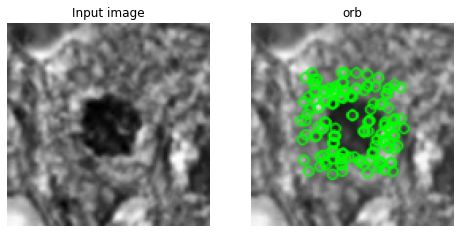

In [23]:
img = io.imread(r"/content/MandNM/mitosis/A00_01_01_CZ8UV4CK9-1a2574be1ed31c6659b0878de25f8c97.png", as_gray=True)

resized = resize(img, (128, 128))
img3 = img_as_ubyte(resized)


orb = cv2.ORB_create(nfeatures=2000)
kp, des = orb.detectAndCompute(img3, None)

kp_img = cv2.drawKeypoints(img3, kp, None, color=(0, 255, 0), flags=0)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(resized, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box')
# hog_image_rescaled = exposure.rescale_intensity(img2, in_range=(0, 10))
ax2.axis('off')
ax2.imshow(kp_img, cmap=plt.cm.gray)
ax2.set_title('orb')
ax1.set_adjustable('box')
plt.show()

In [24]:
category_orb = []
Array_orb = []
for folder in os.listdir("/content/MandNM/"):

    if(folder == ".DS_Store"):
        continue

    # Loop through each category
    for filename in os.listdir(path.join("/content/MandNM", folder)):

        # Select images which are png and jpg only
        if (filename[-3:] == "png" or filename[-3:] == "jpg"):

            # Get full image by joining
            # all the path to the image
            image = path.join("MandNM", folder, filename)

            # Use open cv to read the image
            img = io.imread(image, as_gray=True)
            resized = resize(img, (128, 128))
            img3 = img_as_ubyte(resized)
            orb = cv2.ORB_create(nfeatures=2000)
            kp, des = orb.detectAndCompute(img3, None)
            x_image_features = np.vstack(np.array(des))
            scaler = MinMaxScaler(feature_range=(0,1))
            x_image_scaled = scaler.fit_transform(x_image_features)
            
            category_orb.append(folder)
            Array_orb.append(x_image_scaled.flatten())



# convert the extracted features
# from array to vector
orbArray_np = np.array(Array_orb)


print("Total feature extracted from the each image",len(orbArray_np[0]))

Total feature extracted from the each image 1824


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [25]:
orb_df = pd.DataFrame(Array_orb)
orb_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,8184,8185,8186,8187,8188,8189,8190,8191,8192,8193,8194,8195,8196,8197,8198,8199,8200,8201,8202,8203,8204,8205,8206,8207,8208,8209,8210,8211,8212,8213,8214,8215,8216,8217,8218,8219,8220,8221,8222,8223
0,0.402390,0.074380,0.987603,0.883534,0.954357,0.734694,0.743478,0.548523,0.185185,0.903226,0.983806,0.979424,0.867769,0.182203,0.561086,1.000000,0.892683,0.968379,0.498008,0.846457,0.704918,0.580488,1.000000,0.933333,0.063025,0.224900,0.127273,0.858333,0.800000,0.952941,0.032129,0.466135,0.637450,0.925620,1.000000,0.353414,0.867220,0.991837,0.717391,0.670886,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.773810,0.729839,0.525692,0.100000,0.280851,0.706122,0.653846,0.387352,0.983264,0.822835,0.280632,1.000000,0.656126,0.901186,0.894118,0.995951,0.528226,0.439516,0.924901,0.027668,0.848606,0.302789,0.996078,0.945098,0.041322,0.175299,0.346457,0.231076,0.351020,0.145098,0.226721,0.115079,0.265873,0.346774,0.316206,0.508000,0.451064,0.848980,0.175214,0.264822,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.892430,0.390438,0.786561,0.068000,0.385827,0.286853,0.673387,0.138340,0.724409,0.933333,0.177419,0.992095,0.425197,0.165323,0.588933,0.107143,0.139442,0.902041,0.390438,0.653543,0.904762,0.876000,0.912351,0.386831,0.192771,0.119522,0.484252,0.501961,0.309237,0.952381,0.530120,0.343874,0.665339,0.868526,0.252964,0.800000,0.244094,0.067729,0.806452,0.739130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.357143,0.000000,0.460317,0.925000,0.205645,0.592593,0.487069,0.185484,0.400826,0.003922,0.975309,0.644269,0.482353,0.111111,0.573705,0.439216,0.479508,0.574380,0.233202,0.552941,0.546939,0.688525,0.395257,0.803922,0.853061,0.982684,0.979079,0.752941,0.449393,0.560784,0.442688,0.391304,0.797619,0.450980,0.488095,0.341667,0.189516,0.864198,0.500000,0.072581,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.082677,0.682731,0.229249,0.588000,0.600806,0.968127,0.556452,0.790514,0.555556,0.364706,0.669355,0.205645,0.008163,0.870079,0.392405,0.549020,0.912000,0.091633,0.573123,0.570866,0.080000,0.039526,0.227451,0.818182,0.088000,0.082353,0.098814,0.435294,0.818548,0.305556,0.166667,0.843137,0.165354,0.807229,0.000000,0.588000,0.479839,0.585657,0.919355,0.932806,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,0.246032,0.039841,0.644269,0.874016,0.081301,0.462451,0.815900,0.408730,0.341176,0.691700,0.603239,0.166008,0.404000,0.991935,0.215686,0.445344,0.849206,0.961373,0.752988,0.505882,0.740157,0.417671,0.921260,0.720165,0.860000,0.462745,0.858268,0.749020,0.576471,0.425197,0.318725,0.905512,0.920635,0.932271,0.229249,0.366142,0.191057,0.865613,0.029289,0.734127,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
428,0.426877,0.702381,0.727642,0.436735,0.647773,0.256198,0.276596,0.729958,0.920635,0.984314,0.677165,0.219608,0.838057,0.466667,0.290196,0.107570,0.483333,0.298755,0.422925,0.188235,0.435146,0.3918

In [26]:
temp=ptoa(Array_orb)
orb_features=pca_reduction(temp,100)

In [27]:
csvData = []
for id, line in enumerate(orb_features):
  if(id==0):
    temp=[]
    for i in range(0,len(line)):
      temp.append("value"+str(i))
    temp.insert(len(temp),"label")
    csvData.append(temp)

  newImg = line

    # Prepend the category of each image to
    # the begining of the features
  newImg.insert(len(newImg), category[id])
  csvData.append(newImg)


# Save the csv file
with open('result_orb_data.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()

print("Done Extracting Features")

Done Extracting Features


In [28]:
import pandas as pd

feature_orb=pd.read_csv("result_orb_data.csv")
feature_orb['label'] = feature_orb['label'].map({'nonmitosis': 1, 'mitosis': 0})
feature_orb

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16,value17,value18,value19,value20,value21,value22,value23,value24,value25,value26,value27,value28,value29,value30,value31,value32,value33,value34,value35,value36,value37,value38,value39,...,value61,value62,value63,value64,value65,value66,value67,value68,value69,value70,value71,value72,value73,value74,value75,value76,value77,value78,value79,value80,value81,value82,value83,value84,value85,value86,value87,value88,value89,value90,value91,value92,value93,value94,value95,value96,value97,value98,value99,label
0,-17.646912,11.132316,9.647991,6.553106,4.360976,5.036837,-2.815900,2.363616,-1.577349,0.266290,1.435431,0.190799,0.936003,0.241874,0.047322,-0.466469,0.058867,0.857826,0.308618,-0.214630,0.274911,-0.130261,0.243685,-0.565745,0.170768,0.423143,-0.588228,-0.184661,-0.523888,-0.254284,1.078258,-0.791706,0.620631,-0.032303,0.057282,0.006258,-0.389481,0.327808,-0.924966,0.528612,...,0.630271,-0.232120,-1.153243,0.127912,0.279825,-0.028741,0.411736,-0.222394,0.193033,0.479308,0.358254,0.333782,-0.138343,-0.181009,0.639603,0.357800,-0.588424,-0.183557,0.762908,0.013676,-1.134311,-0.091315,-0.452991,-0.152948,0.263989,-0.114658,-0.507734,0.351959,-0.179546,-0.405363,0.827177,-0.133373,-0.532169,-0.437554,-0.516630,0.615006,-0.273277,0.263351,0.171436,1
1,-12.380721,1.777405,-2.847947,-2.831014,-0.761658,2.138026,-2.210521,1.264890,-0.552856,-0.380315,-1.679447,-0.672515,-0.287250,2.171991,0.096502,-1.052227,-0.683620,0.539413,-1.812632,-0.738264,-1.819753,0.817475,1.064971,0.069454,-0.956414,0.193775,0.538706,0.760653,-1.115592,0.035046,0.032889,1.390938,-0.220132,0.488716,-0.468279,2.446966,1.244514,-0.855114,-0.669684,-1.205333,...,-0.326778,0.722083,-0.148061,-0.455351,-0.307272,-0.393540,-0.089850,0.241933,-1.562386,0.835577,1.232929,0.231474,1.421926,-0.477830,-0.274687,-1.303171,-0.923898,1.988162,0.834604,-0.549486,-0.411499,-0.836609,-1.100943,1.076698,-0.049140,-0.466419,0.333296,0.087841,0.931991,0.983501,-0.353057,0.640769,0.788914,1.644094,1.090144,0.064098,-1.424716,0.205555,0.420483,1
2,12.300305,3.431410,2.262266,-3.146361,3.778395,-3.105764,-2.156599,1.750959,2.944104,2.031318,-0.012841,-2.453163,-0.987318,0.088067,1.005478,-1.287789,-2.618378,0.113800,1.984910,2.185148,1.017560,-0.377672,0.615449,-0.889618,-0.304077,-1.036479,-0.592669,-0.058572,0.547658,-0.782247,0.029199,2.988690,-0.978093,-1.402863,-1.408418,-1.689414,1.115060,0.708053,1.538113,0.754115,...,-1.532247,1.339339,0.244274,-1.000326,1.542578,-1.914291,-1.576700,1.209098,-0.028831,-1.813221,-1.149207,-0.869705,-0.914862,-0.226094,2.698300,-0.591075,1.255006,3.402750,2.079190,3.808063,0.609615,-0.330741,1.119550,-1.786168,-0.029513,-1.440929,-0.385628,4.552639,0.798061,-0.210951,2.022009,-2.158446,1.005340,1.440708,2.053312,0.827283,-0.028100,0.391035,1.386397,1
3,-15.460653,6.964440,2.525987,-0.846271,-1.995360,-3.040214,1.884768,-0.681622,0.164718,0.890555,-0.681814,0.769760,-1.775402,-1.409620,0.542881,-1.469291,1.258216,0.106276,-0.107584,-0.072482,0.420073,1.188880,-0.195855,-1.542191,0.029502,0.142806,1.018048,0.560470,-0.629289,0.367525,1.043654,-0.088422,-0.160082,-1.294879,0.050865,0.388695,1.134755,1.009029,-0.069680,0.382892,...,-1.407847,-0.726644,0.945369,1.925398,-0.416301,0.723107,-0.395260,1.191375,-0.782211,0.056871,-0.567017,0.325289,-0.321451,0.278379,0.380018,0.225353,-0.817823,-0.352826,0.180036,-0.258726,-0.299480,0.327143,0.260003,-0.116757,0.050445,0.035069,0.078095,-0.653906,0.349633,1.205445,0.601134,0.781522,-0.002448,0.627290,0.484959,-0.311702,0.930103,-0.772602,0.344188,1
4,9.840524,-0.397323,3.957418,-4.199125,2.674157,-0.039234,2.651180,2.677125,-0.178720,-1.898222,2.200519,0.626910,0.120237,-0.363261,1.380665,-3.924783,-1.149986,-0.381191,-3.272443,0.472601,3.378203,1.788251,2.102929,1.485360,-2.623698,0.332494,1.175875,2.323705,-0.853485,0.256295,1.281147,-1.788089,-2.126153,1.033517,-0.653942,3.098

In [ ]:
# feature_orb=normalize(feature_orb)

In [ ]:
feature_orb

### classification based on orb features

In [ ]:
print("results for gridsearch:")
grid_search(feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1])

results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 15}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


['Random forest:77.01149425287356',
 'KNN:0.6840579710144926',
 'svm:81.60919540229885']

In [ ]:
print("results for random search")
random_search(feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1])

results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 9, 'max_features': 55, 'min_samples_leaf': 5, 'min_samples_split': 6, 'n_estimators': 98}
The KNN Model is trained well with the given images {'n_neighbors': 15}
The svm Model is trained well with the given images {'C': 10.06990525910439, 'kernel': 'rbf'}


['Random forest:0.6782608695652175',
 'KNN:0.6840579710144926',
 'svm:0.6927536231884058']

In [ ]:
# print("results for hyperband")
# hyperband_opt(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

In [ ]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1])

results for Bayesian Optimization with Gaussian Process (BO-GP)
Splitted Successfully
The rf Model is trained well with the given images OrderedDict([('criterion', 'gini'), ('max_depth', 15), ('max_features', 59), ('min_samples_leaf', 3), ('min_samples_split', 5), ('n_estimators', 69)])
The KNN Model is trained well with the given images OrderedDict([('n_neighbors', 15)])


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'rbf')])


['Random forest:0.6869565217391305',
 'KNN:0.6840579710144926',
 'svm:0.6927536231884058']

In [ ]:
print("results for skopt")
skopt_gp(feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1])

results for skopt
Splitted Successfully


['Random forest:0.672463768115942',
 'KNN:0.6695652173913044',
 'svm:0.6811594202898551']

In [ ]:
print("result for bo_tpe")
bo_tpe(feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1])

result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:03<00:00,  5.56it/s, best loss: -0.6898550724637681]


["Random forest:{'criterion': 1, 'max_depth': 9.0, 'max_features': 43.0, 'min_samples_leaf': 4.0, 'min_samples_split': 8.0, 'n_estimators': 79.0}",
 "KNN:{'n_neighbors': 15.0}",
 "svm:{'C': -12.272523245642352, 'kernel': 2}"]

In [ ]:
print("result for genetic")
genetic(feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1])

result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.647826	0.623188	0.669565	0.0147371
1  	6     	0.655652	0.643478	0.669565	0.00950795
2  	8     	0.655652	0.623188	0.669565	0.0152167 
3  	4     	0.657971	0.634783	0.669565	0.0115215 
4  	7     	0.664928	0.649275	0.669565	0.00567998
5  	7     	0.667826	0.666667	0.669565	0.00141999
Best individual is: {'n_estimators': 75, 'max_features': 29, 'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini'}
with fitness: 0.6695652173913044
The rf Model is trained well with the given images {'n_estimators': 75, 'max_features': 29, 'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min    	max     	std      
0  	10    	0.651884	0.62029	0.669565	0.0141674
1  	7     	0.662899	0.649275	0.669565	0.00608696
2  	2     	0.666087	0.663768	0.669565	0.00283999
3  	9     	0.668406	0.663768	0.669565	0.00231884
4  	8     	0.669565	0.669565	0.669565	0         
5  	9     	0.669565	0.669565	0.669565	0         
Best individual is: {'n_neighbors': 6}
with fitness: 0.6695652173913044
The knn Model is trained well with the given images {'n_neighbors': 6}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min    	max     	std      
0  	10    	0.657971	0.55942	0.692754	0.0443014
1  	2     	0.688116	0.681159	0.692754	0.00470959
2  	9     	0.694493	0.681159	0.710145	0.00851996
3  	5     	0.701449	0.692754	0.710145	0.00869565
4  	4     	0.704928	0.692754	0.710145	0.0079697 
5  	5     	0.708406	0.692754	0.710145	0.00521739
Best individual is: {'C': 6.165411719768954, 'kernel': 'rbf'}
with fitness: 0.7101449275362319
The rf Model is trained well with the given images {'C': 6.165411719768954, 'kernel': 'rbf'}


['Random forest:0.6695652173913044',
 'KNN:0.6695652173913044',
 'svm:0.7101449275362319']

In [ ]:
print("result for tpot")
tpot(feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1])

result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.672463768115942	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=65, RandomForestClassifier__max_features=45, RandomForestClassifier__min_samples_leaf=4, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=102)

Generation 2 - Current Pareto front scores:

-1	0.672463768115942	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=65, RandomForestClassifier__max_features=45, RandomForestClassifier__min_samples_leaf=4, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=102)

Generation 3 - Current Pareto front scores:

-1	0.672463768115942	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=65, RandomForestClassifier__max_features=45, RandomForestClassifier__min_samples_leaf=4, RandomForestClassifier__m

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6840579710144926	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=15)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 2 - Current Pareto front scores:

-1	0.6840579710144926	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=15)

Generation 3 - Current Pareto front scores:

-1	0.6840579710144926	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=15)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6811594202898551	SVC(input_matrix, SVC__C=24.008424302805754, SVC__kernel=rbf)

-2	0.7130434782608696	SVC(SVC(input_matrix, SVC__C=9.199183497917279, SVC__kernel=poly), SVC__C=41.09124330308904, SVC__kernel=rbf)

Generation 2 - Current Pareto front scores:

-1	0.6811594202898551	SVC(input_matrix, SVC__C=24.008424302805754, SVC__kernel=rbf)

-2	0.7130434782608696	SVC(SVC(input_matrix, SVC__C=9.199183497917279, SVC__kernel=poly), SVC__C=41.09124330308904, SVC__kernel=rbf)

Generation 3 - Current Pareto front scores:

-1	0.6927536231884058	SVC(input_matrix, SVC__C=11.06556188134961, SVC__kernel=rbf)

-2	0.7130434782608696	SVC(SVC(input_matrix, SVC__C=9.199183497917279, SVC__kernel=poly), SVC__C=41.09124330308904, SVC__kernel=rbf)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


['Random forest:75.86206896551724',
 'knn:73.5632183908046',
 'svm:78.16091954022988']

### combining hog and orb

In [ ]:
orbhog_temp=[feature_hog.iloc[:,:-1],feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1]]

In [ ]:
orb_hog=pd.concat(orbhog_temp, axis=1)

In [ ]:
orb_hog

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16,value17,value18,value19,value20,value21,value22,value23,value24,value25,value26,value27,value28,value29,value30,value31,value32,value33,value34,value35,value36,value37,value38,value39,...,value61,value62,value63,value64,value65,value66,value67,value68,value69,value70,value71,value72,value73,value74,value75,value76,value77,value78,value79,value80,value81,value82,value83,value84,value85,value86,value87,value88,value89,value90,value91,value92,value93,value94,value95,value96,value97,value98,value99,label
0,-0.568261,0.135315,0.557027,2.057404,0.324491,0.310445,1.173912,0.447988,-1.016115,-0.010653,-0.197807,-0.408061,-1.119411,-0.358027,0.604974,-0.455506,-0.809204,1.387526,0.173811,0.022881,-0.662020,0.713469,-0.604149,-1.003721,0.109491,1.261016,-0.854814,-0.885796,-0.456492,-0.039874,-1.859251,-1.080198,-0.848804,0.232902,0.798459,0.189735,0.632276,-0.352404,0.174246,-0.395496,...,0.490104,0.816446,0.666406,-0.335336,0.675126,-0.672789,0.090342,-0.052065,0.070076,-0.408645,0.229647,0.560981,0.029291,0.607667,0.196439,-0.479064,0.013441,-0.941278,0.153082,0.433277,-0.121550,0.395252,0.192607,0.144525,0.149780,-0.114612,0.412497,-0.117664,0.628748,0.109655,-0.914952,0.065418,-0.522163,-0.454445,0.013753,-0.279201,0.161015,0.855944,-0.714406,1
1,0.072766,-1.314068,-0.333010,0.737812,0.825911,-1.143673,0.676719,0.344632,-0.026440,-0.803812,-0.717636,0.236412,-0.001813,1.136594,0.583204,-0.356051,-0.069518,-1.521234,-0.561440,1.775314,-0.343884,-0.426231,0.436249,-0.462886,0.653075,-0.067205,-0.345553,-0.343802,0.201964,0.601322,-0.247720,-1.082844,-0.847306,-1.117991,-0.406924,-0.088853,0.296962,1.205530,-0.271433,0.371673,...,1.007472,-0.619648,-0.091233,0.878364,-0.790743,-0.150633,-0.454964,0.076045,-1.167292,-0.465541,0.665741,0.710949,-0.672440,-0.522303,0.160696,-0.031291,-0.419589,-0.877763,-0.446839,-0.834671,-0.454709,2.318806,-0.197728,0.176912,0.395168,-0.539795,0.720181,-0.145764,0.308426,-0.784171,0.628036,-1.384220,-1.169970,-0.930916,0.298285,-0.587803,0.818775,0.616600,0.164394,1
2,0.245757,2.383341,-0.138226,0.148015,0.206508,0.147450,1.297806,0.255086,-0.716606,0.476243,-0.104805,-0.028483,-0.629036,0.291190,-1.630016,0.301932,-0.752725,0.853065,-0.266042,-0.561334,-1.176564,-0.015849,-0.619224,-0.704656,0.627949,-0.416619,0.076397,0.140591,-0.156478,-0.518681,-0.507872,0.282757,0.420154,0.253845,-0.313785,-0.757888,0.957124,-0.153221,-1.308015,0.624861,...,-0.119578,0.577471,-1.597654,0.296737,-0.442720,-1.385070,-2.220769,0.701581,2.308128,-1.347200,-1.117452,-0.292828,1.120070,0.344635,1.557224,-0.603926,-0.345051,2.039314,-2.062537,-1.554831,0.222864,4.512070,-1.133659,0.271048,2.350083,-0.433826,-0.372047,0.776046,0.267798,0.754938,1.541540,3.081778,-0.797793,2.352886,1.976590,0.686441,0.254050,-1.206565,-1.108578,1
3,-1.438643,4.343278,-1.943192,0.209219,-0.318492,0.137997,-0.706037,0.284897,-0.758950,-0.693462,-0.052654,0.058357,0.568426,0.493785,0.565549,-0.334240,0.618754,0.490052,0.321997,1.016196,0.423911,-0.968911,0.127268,0.668440,0.815153,-0.674957,-0.967060,0.273884,0.098398,-0.366441,0.144054,-0.415843,0.189376,1.160709,0.704100,1.029650,-0.142085,0.135850,1.272406,-0.028625,...,0.344949,-1.348081,-0.863635,0.176134,-0.113705,1.077939,0.909197,0.492767,0.972904,0.785339,0.849507,-0.676840,0.301589,-0.202242,0.561305,-0.137067,0.800460,0.459503,1.015871,-0.262332,1.249293,0.358673,-0.229813,0.468418,0.937659,-0.236031,1.212957,0.701962,-0.607734,0.561379,1.037748,0.997622,-0.542461,0.041566,0.254469,1.129516,-0.600544,1.001804,-0.800249,1
4,1.067980,0.916442,0.439403,0.248737,4.264154,1.129122,-0.996633,-0.851929,-0.045080,0.147051,-0.170295,0.150187,-0.666075,-0.369404,0.824191,-1.199857,-0.019365,0.007467,1.083949,-0.257006,0.701711,0.592636,0.826999,0.580147,0.035712,-0.798296,-0.359018,0.331121,-0.465734,-0.884251,-0.313307,0.505927,-0.683029,-0.518779,-0.385431,0.549453

### classification based on orb and hog features

In [ ]:
print("results for gridsearch:")
grid_search(orb_hog.iloc[:,:-1],orb_hog.iloc[:,-1])

results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 100}
The KNN Model is trained well with the given images {'n_neighbors': 10}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


['Random forest:77.01149425287356',
 'KNN:0.6695652173913044',
 'svm:86.20689655172413']

In [ ]:
print("results for random search")
random_search(orb_hog.iloc[:,:-1],orb_hog.iloc[:,-1])

results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 29, 'max_features': 56, 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 17}
The KNN Model is trained well with the given images {'n_neighbors': 9}
The svm Model is trained well with the given images {'C': 3.6265296769450064, 'kernel': 'sigmoid'}


['Random forest:0.7391304347826088',
 'KNN:0.6840579710144928',
 'svm:0.744927536231884']

In [ ]:
# print("results for hyperband")
# hyperband_opt(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

In [ ]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(orb_hog.iloc[:,:-1],orb_hog.iloc[:,-1])

results for Bayesian Optimization with Gaussian Process (BO-GP)
Splitted Successfully
The rf Model is trained well with the given images OrderedDict([('criterion', 'entropy'), ('max_depth', 5), ('max_features', 41), ('min_samples_leaf', 11), ('min_samples_split', 11), ('n_estimators', 10)])
The KNN Model is trained well with the given images OrderedDict([('n_neighbors', 18)])


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 100.0), ('kernel', 'linear')])


['Random forest:0.7652173913043478',
 'KNN:0.6695652173913044',
 'svm:0.7420289855072464']

In [ ]:
print("results for skopt")
skopt_gp(orb_hog.iloc[:,:-1],orb_hog.iloc[:,-1])

results for skopt
Splitted Successfully


['Random forest:0.7565217391304347',
 'KNN:0.6695652173913044',
 'svm:0.7420289855072464']

In [ ]:
print("result for bo_tpe")
bo_tpe(orb_hog.iloc[:,:-1],orb_hog.iloc[:,-1])

result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 15.88it/s, best loss: -0.7420289855072464]


["Random forest:{'criterion': 0, 'max_depth': 25.0, 'max_features': 43.0, 'min_samples_leaf': 1.0, 'min_samples_split': 11.0, 'n_estimators': 42.0}",
 "KNN:{'n_neighbors': 9.0}",
 "svm:{'C': 86.86050441826802, 'kernel': 0}"]

In [ ]:
print("result for genetic")
genetic(orb_hog.iloc[:,:-1],orb_hog.iloc[:,-1])

result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.713333	0.655072	0.756522	0.0288242
1  	8     	0.730725	0.672464	0.756522	0.0256469
2  	5     	0.745217	0.713043	0.756522	0.0153075
3  	8     	0.756522	0.756522	0.756522	1.11022e-16
4  	3     	0.753333	0.724638	0.756522	0.00956522 
5  	9     	0.756522	0.756522	0.756522	1.11022e-16
Best individual is: {'n_estimators': 43, 'max_features': 56, 'max_depth': 36, 'min_samples_split': 8, 'min_samples_leaf': 6, 'criterion': 'entropy'}
with fitness: 0.7565217391304347
The rf Model is trained well with the given images {'n_estimators': 43, 'max_features': 56, 'max_depth': 36, 'min_samples_split': 8, 'min_samples_leaf': 6, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.645797	0.591304	0.684058	0.0315609
1  	6     	0.666957	0.605797	0.684058	0.0232409
2  	6     	0.68058 	0.663768	0.684058	0.00707626
3  	4     	0.684058	0.684058	0.684058	0         
4  	3     	0.684058	0.684058	0.684058	0         
5  	6     	0.684058	0.684058	0.684058	0         
Best individual is: {'n_neighbors': 9}
with fitness: 0.6840579710144927
The knn Model is trained well with the given images {'n_neighbors': 9}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.730145	0.710145	0.742029	0.0108027
1  	10    	0.73971 	0.730435	0.742029	0.00463768
2  	9     	0.74087 	0.730435	0.742029	0.00347826
3  	7     	0.74029 	0.724638	0.742029	0.00521739
4  	7     	0.742029	0.742029	0.742029	1.11022e-16
5  	8     	0.742029	0.742029	0.742029	1.11022e-16
Best individual is: {'C': 24.53615251787255, 'kernel': 'linear'}
with fitness: 0.7420289855072464
The rf Model is trained well with the given images {'C': 24.53615251787255, 'kernel': 'linear'}


['Random forest:0.7565217391304347',
 'KNN:0.6840579710144927',
 'svm:0.7420289855072464']

In [ ]:
print("result for tpot")
tpot(orb_hog.iloc[:,:-1],orb_hog.iloc[:,-1])

result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7594202898550725	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=95, RandomForestClassifier__max_features=46, RandomForestClassifier__min_samples_leaf=6, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=65)

Generation 2 - Current Pareto front scores:

-1	0.7594202898550725	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=95, RandomForestClassifier__max_features=46, RandomForestClassifier__min_samples_leaf=6, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=65)

Generation 3 - Current Pareto front scores:

-1	0.7594202898550725	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=95, RandomForestClassifier

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6666666666666666	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=17)

Generation 2 - Current Pareto front scores:

-1	0.6666666666666666	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=17)

-2	0.6695652173913045	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=3), KNeighborsClassifier__n_neighbors=17)

Generation 3 - Current Pareto front scores:

-1	0.6695652173913044	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=11)

-2	0.6695652173913045	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=3), KNeighborsClassifier__n_neighbors=17)
1 operators have been imported by TPOT.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7304347826086958	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=45.074613831422106, SVC__kernel=poly)

Generation 2 - Current Pareto front scores:

-1	0.7420289855072464	SVC(input_matrix, SVC__C=21.811742806534184, SVC__kernel=linear)

Generation 3 - Current Pareto front scores:

-1	0.7420289855072464	SVC(input_matrix, SVC__C=21.811742806534184, SVC__kernel=linear)


['Random forest:80.45977011494253',
 'knn:73.5632183908046',
 'svm:80.45977011494253']

## Censure extractor

### extracting censure extractor

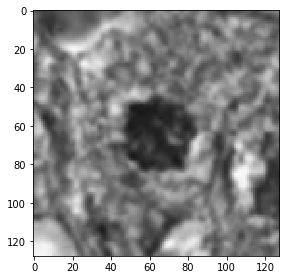

In [29]:
img = io.imread(r"/content/MandNM/mitosis/A00_01_01_CZ8UV4CK9-1a2574be1ed31c6659b0878de25f8c97.png", as_gray=True)

resized = resize(img, (128, 128))
img3 = img_as_ubyte(resized)

imshow(img3)

detector = CENSURE()
detector.detect(resized)
a=detector.keypoints

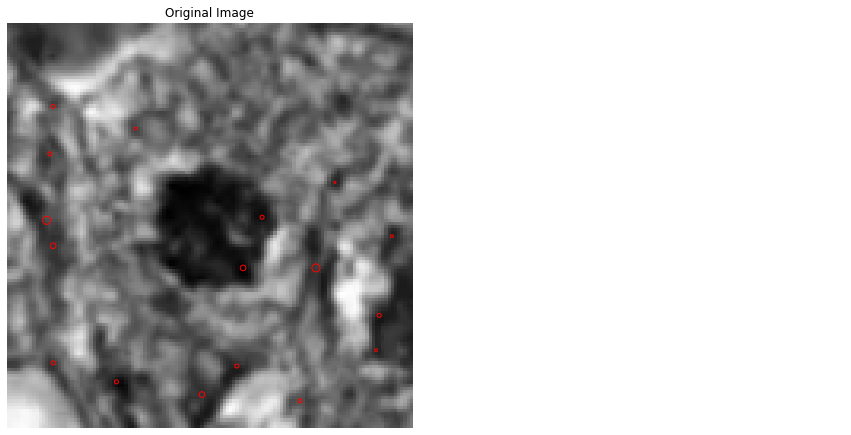

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax[0].imshow(img3, cmap=plt.cm.gray)
ax[0].scatter(detector.keypoints[:, 1], detector.keypoints[:, 0],
              2 ** detector.scales, facecolors='none', edgecolors='r')
ax[0].set_title("Original Image")


for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

In [31]:
category_censure = []
Array_censure = []
for folder in os.listdir("/content/MandNM/"):

    if(folder == ".DS_Store"):
        continue

    # Loop through each category
    for filename in os.listdir(path.join("/content/MandNM", folder)):

        # Select images which are png and jpg only
        if (filename[-3:] == "png" or filename[-3:] == "jpg"):

            # Get full image by joining
            # all the path to the image
            image = path.join("MandNM", folder, filename)

            # Use open cv to read the image
            img = io.imread(image, as_gray=True)
            resized = resize(img, (128, 128))
            img3 = img_as_ubyte(resized)
            detector = CENSURE()
            detector.detect(img3)
            x_image_features = np.vstack(np.array(detector.keypoints))
            scaler = MinMaxScaler(feature_range=(0,1))
            x_image_scaled = scaler.fit_transform(x_image_features)
            # temp=detector.keypoints.flatten()
            
            category_censure.append(folder)
            Array_censure.append(x_image_scaled.flatten())



# convert the extracted features
# from array to vector
censureArray_np = np.array(Array_censure)


print("Total feature extracted from the each image",len(censureArray_np[0]))



Total feature extracted from the each image 12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [32]:
cen_df = pd.DataFrame(Array_censure)
cen_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113
0,0.0,0.048387,0.037037,1.000000,0.194444,0.000000,0.620370,1.000000,0.787037,0.758065,1.000000,0.451613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.942308,0.016129,1.000000,0.112903,0.384615,0.161290,0.384615,0.306452,0.711538,0.338710,0.153846,0.354839,0.442308,0.370968,0.000000,1.000000,0.346154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.196429,0.179245,0.830357,0.198113,0.026786,0.245283,1.000000,0.471698,0.098214,0.537736,0.258929,0.584906,0.187500,0.622642,0.562500,0.688679,0.437500,0.688679,0.696429,0.773585,0.741071,0.896226,0.125000,0.943396,0.133929,0.962264,0.285714,0.990566,0.803571,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.471154,0.053571,0.605769,0.133929,0.490385,0.267857,0.201923,0.303571,0.798077,0.410714,1.000000,0.491071,0.634615,0.526786,0.365385,0.526786,0.798077,0.535714,0.384615,0.687500,0.000000,0.696429,0.644231,0.714286,0.653846,0.776786,0.961538,0.919643,0.201923,0.928571,0.240385,0.928571,0.451923,1.000000,0.336538,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.112150,0.018018,1.000000,0.027027,0.401869,0.072072,1.000000,0.099099,0.934579,0.216216,0.981308,0.225225,0.336449,0.261261,0.570093,0.261261,0.588785,0.324324,0.000000,0.477477,0.626168,0.522523,0.102804,0.540541,0.112150,0.540541,0.878505,0.576577,1.000000,0.639640,0.214953,0.666667,0.214953,0.675676,0.037383,0.738739,0.607477,0.765766,0.177570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,0.0,0.045045,0.087719,0.234234,0.122807,0.081081,0.149123,0.711712,0.149123,0.936937,0.210526,0.207207,0.219298,0.963964,0.342105,0.657658,0.368421,0.945946,0.377193,0.549550,0.403509,0.288288,0.412281,0.378378,0.421053,0.036036,0.421053,0.396396,0.464912,0.018018,0.473684,0.981982,0.517544,0.198198,0.543860,0.576577,0.561404,0.576577,0.596491,0.009009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
428,0.0,0.021277,0.085470,0.468085,0.136752,0.776596,0.205128,0.063830,0.367521,0.117021,0.452991,0.021277,0.709402,0.414894,0.752137,0.872340,0.794872,0.893617,0.820513,0.946809,0.905983,0.404255,0.931624,0.000000,0.948718,0.340426,0.974359,1.000000,1.000000,0.255319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
429,0.0,0.434783,0.018519,0.591304,0.027778,0.156522,0.037037,0.878261,0.074074,0.269565,0.083333,0.939130,0.129630,0.434783,0.18518

In [33]:
print("Total feature extracted from the each image",len(censureArray_np[0]))


Total feature extracted from the each image 12


In [ ]:
temp=ptoa(Array_censure)
cen_features=pca_reduction(temp,100)

In [ ]:
csvData = []
for id, line in enumerate(cen_features):
  if(id==0):
    temp=[]
    for i in range(0,len(line)):
      temp.append("value"+str(i))
    temp.insert(len(temp),"label")
    csvData.append(temp)

  newImg = line

    # Prepend the category of each image to
    # the begining of the features
  newImg.insert(len(newImg), category[id])
  csvData.append(newImg)


# Save the csv file
with open('result_cen_data.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()

print("Done Extracting Features")

Done Extracting Features


In [ ]:
import pandas as pd

feature_cen=pd.read_csv("result_cen_data.csv")
feature_cen['label'] = feature_cen['label'].map({'nonmitosis': 1, 'mitosis': 0})
feature_cen

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16,value17,value18,value19,value20,value21,value22,value23,value24,value25,value26,value27,value28,value29,value30,value31,value32,value33,value34,value35,value36,value37,value38,value39,...,value61,value62,value63,value64,value65,value66,value67,value68,value69,value70,value71,value72,value73,value74,value75,value76,value77,value78,value79,value80,value81,value82,value83,value84,value85,value86,value87,value88,value89,value90,value91,value92,value93,value94,value95,value96,value97,value98,value99,label
0,-1.626324,1.136414,-0.991570,0.444846,-0.362487,0.122720,-0.280433,0.284630,-0.638668,0.293375,0.333147,-0.376728,-0.061931,-0.404072,-0.289070,-0.224257,-0.158828,-0.008285,0.178177,-0.114496,-0.212991,0.035239,-0.082276,-0.306716,-0.102544,-0.018361,0.019381,0.053675,-0.055397,0.004237,0.014773,0.142530,-0.114207,0.066954,-0.035450,0.046003,-0.119705,0.135941,0.048473,-0.072717,...,-0.044183,-0.092055,-0.022399,0.043324,-0.009928,-0.035136,-0.104783,-0.065099,-0.089372,-0.248919,0.053116,0.050756,0.019832,0.046069,-0.051380,0.039682,-0.003629,-0.045701,-0.064146,-0.023003,-0.008320,-0.009424,0.023271,0.000770,0.003591,0.017887,-0.007721,-0.009637,0.003551,-0.011095,0.013622,0.005587,0.008205,-0.002185,-0.010234,0.002963,0.001667,-0.001598,0.001353,1
1,-1.606997,0.952186,-0.664551,0.216528,-0.061010,0.016838,-0.046781,0.073463,0.168719,-0.318349,0.396535,-0.071825,0.510057,-0.073015,0.036983,-0.019152,-0.116749,-0.187173,-0.207585,-0.218608,0.242381,-0.006742,-0.042877,-0.015043,-0.022239,-0.017693,-0.097580,-0.195069,0.075222,-0.148316,0.181447,-0.257591,0.132338,-0.239524,0.046313,-0.072143,0.070567,-0.214880,-0.153570,0.112576,...,0.007708,0.067830,0.127277,-0.228415,-0.101564,0.122963,0.170067,0.070343,0.055129,-0.034500,0.004598,0.028105,0.007002,0.017760,-0.032552,0.013159,0.006851,0.051092,0.049578,0.053264,0.039754,0.008609,0.009778,-0.012592,0.002731,0.012264,0.001375,-0.001112,-0.013626,-0.013848,0.002799,-0.001544,-0.004868,-0.000031,-0.002937,0.007185,0.000054,-0.002802,0.002081,1
2,-1.429816,-0.433593,1.013204,-0.469718,-0.138855,0.438910,0.020007,0.342218,-0.234008,0.148025,0.204104,-0.079990,-0.190126,-0.630013,0.195500,0.319543,-0.238295,0.196733,0.045182,0.394367,-0.040564,0.154773,-0.634698,-0.599145,0.124054,-0.078126,0.141366,0.192137,-0.032138,0.077925,-0.161848,0.096973,-0.230526,-0.224722,-0.031782,-0.004256,-0.008486,-0.052188,-0.161753,0.051071,...,0.119046,0.182594,0.141843,0.022371,0.057652,-0.018982,-0.068463,-0.107630,0.019228,-0.022617,-0.011397,-0.023265,-0.020136,-0.020814,0.019674,-0.008327,-0.035650,0.022922,-0.025769,-0.017468,-0.001576,0.011635,-0.029179,-0.016976,0.028307,0.012724,-0.004984,0.005437,0.005211,-0.018826,0.014904,-0.003673,-0.004173,0.019583,0.001706,-0.021896,0.000465,-0.008249,0.008878,1
3,-1.008514,-0.873548,0.999966,0.024482,-0.540756,-0.148324,-0.791134,0.221501,0.286024,-0.207777,-0.084281,-0.243757,-0.098899,0.238542,-0.210653,-0.089993,-0.151880,-0.271890,0.010560,-0.312921,0.082058,0.123565,0.375505,0.141135,-0.006879,0.034530,0.175556,0.200263,-0.272345,-0.039020,0.133619,0.002827,0.011512,-0.101127,0.126645,-0.393180,-0.046147,0.177424,0.202175,-0.067423,...,0.119241,0.168422,0.010171,0.061637,0.049405,-0.000866,-0.021967,0.021981,-0.043114,0.006608,0.064603,0.056566,0.013385,-0.120905,-0.002481,0.028980,-0.028406,-0.008529,-0.040815,0.001554,-0.010971,-0.020053,-0.022940,-0.010501,-0.014752,-0.009781,-0.023292,-0.009876,-0.002876,0.021049,-0.010458,0.000275,0.020130,-0.004136,0.013916,0.004082,-0.000913,-0.001149,-0.003931,1
4,1.415528,-1.280532,-0.788611,-0.079208,0.703745,0.243736,-0.504138,0.869783,-0.094775,0.434138,0.450175,-0.428750,-0.340019,-0.405196,-0.019066,-0.415888,-0.467607,0.162840,0.337042,0.188762,0.615501,-0.161399,-0.390370,0.009162,-0.111573,0.034216,0.124481,-0.102757,0.063761,0.440587,-0.219505,-0.454427,0.022061,-0.446

In [ ]:
# feature_cen=normalize(feature_cen)

### classification based on cen features

In [ ]:
print("results for gridsearch:")
grid_search(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 100}
The KNN Model is trained well with the given images {'n_neighbors': 15}
The svm Model is trained well with the given images {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}


['Random forest:64.36781609195403',
 'KNN:0.6086956521739131',
 'svm:73.5632183908046']

In [ ]:
print("results for random search")
random_search(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 28, 'max_features': 9, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 88}
The KNN Model is trained well with the given images {'n_neighbors': 17}
The svm Model is trained well with the given images {'C': 0.8352724134671585, 'kernel': 'rbf'}


['Random forest:0.5710144927536233',
 'KNN:0.6289855072463769',
 'svm:0.6260869565217392']

In [ ]:
# print("results for hyperband")
# hyperband_opt(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

In [ ]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

results for Bayesian Optimization with Gaussian Process (BO-GP)
Splitted Successfully
The rf Model is trained well with the given images OrderedDict([('criterion', 'gini'), ('max_depth', 5), ('max_features', 1), ('min_samples_leaf', 5), ('min_samples_split', 5), ('n_estimators', 100)])
The KNN Model is trained well with the given images OrderedDict([('n_neighbors', 17)])


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 0.1), ('kernel', 'rbf')])


['Random forest:0.6028985507246377',
 'KNN:0.6289855072463769',
 'svm:0.6260869565217392']

In [ ]:
print("results for skopt")
skopt_gp(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

results for skopt
Splitted Successfully


['Random forest:0.5942028985507246',
 'KNN:0.6289855072463769',
 'svm:0.6260869565217392']

In [ ]:
print("result for bo_tpe")
bo_tpe(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 10.02it/s, best loss: -0.6202898550724638]


["Random forest:{'criterion': 0, 'max_depth': 42.0, 'max_features': 47.0, 'min_samples_leaf': 6.0, 'min_samples_split': 5.0, 'n_estimators': 72.0}",
 "KNN:{'n_neighbors': 19.0}",
 "svm:{'C': 1.820407389110778, 'kernel': 2}"]

In [ ]:
print("result for genetic")
genetic(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.562029	0.547826	0.582609	0.0097393
1  	7     	0.567536	0.550725	0.582609	0.00968307
2  	4     	0.568696	0.550725	0.582609	0.0124873 
3  	5     	0.581159	0.568116	0.582609	0.00434783
4  	7     	0.582899	0.582609	0.585507	0.000869565
5  	8     	0.58    	0.55942 	0.585507	0.00844568 
Best individual is: {'n_estimators': 86, 'max_features': 14, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 9, 'criterion': 'entropy'}
with fitness: 0.5855072463768116
The rf Model is trained well with the given images {'n_estimators': 86, 'max_features': 14, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 9, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min     	max     	std      
0  	10    	0.58029	0.527536	0.608696	0.0262731
1  	4     	0.601449	0.576812	0.608696	0.0125845
2  	6     	0.607826	0.6     	0.608696	0.0026087
3  	5     	0.608696	0.608696	0.608696	0        
4  	8     	0.608696	0.608696	0.608696	0        
5  	6     	0.608696	0.608696	0.608696	0        
Best individual is: {'n_neighbors': 15}
with fitness: 0.6086956521739131
The knn Model is trained well with the given images {'n_neighbors': 15}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max    	std      
0  	10    	0.546957	0.521739	0.57971	0.0162965
1  	3     	0.55971 	0.53913 	0.57971	0.0130564
2  	4     	0.572464	0.565217	0.57971	0.00724638
3  	6     	0.578261	0.565217	0.57971	0.00434783
4  	6     	0.57971 	0.57971 	0.57971	0         
5  	7     	0.57971 	0.57971 	0.57971	0         
Best individual is: {'C': 21.99172566222468, 'kernel': 'rbf'}
with fitness: 0.5797101449275363
The rf Model is trained well with the given images {'C': 21.99172566222468, 'kernel': 'rbf'}


['Random forest:0.5855072463768116',
 'KNN:0.6086956521739131',
 'svm:0.5797101449275363']

In [ ]:
print("result for tpot")
tpot(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.5739130434782608	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=23, RandomForestClassifier__max_features=27, RandomForestClassifier__min_samples_leaf=4, RandomForestClassifier__min_samples_split=2, RandomForestClassifier__n_estimators=99)

-2	0.5768115942028985	RandomForestClassifier(RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=43, RandomForestClassifier__max_features=52, RandomForestClassifier__min_samples_leaf=7, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=49), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=86, RandomForestClassifier__max_features=42, RandomForestClassifier__min_samples_leaf=5, RandomForestClassifier__min_samples_split=8, RandomForestClassifier__n_estimators=106)

Generation 2 - Current Pareto fro

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6289855072463769	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=17)

Generation 2 - Current Pareto front scores:

-1	0.6289855072463769	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=17)

Generation 3 - Current Pareto front scores:

-1	0.6289855072463769	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=17)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6115942028985507	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=6.481390184076552, SVC__kernel=rbf)

Generation 2 - Current Pareto front scores:

-1	0.6115942028985507	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=6.481390184076552, SVC__kernel=rbf)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 3 - Current Pareto front scores:

-1	0.6115942028985507	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=6.481390184076552, SVC__kernel=rbf)


['Random forest:62.06896551724138',
 'knn:67.81609195402298',
 'svm:58.620689655172406']

### combining hog and orb and cen

In [ ]:
orbhogcen_temp=[orb_hog.iloc[:,:-1],feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1]]
orb_hog_cen=pd.concat(orbhogcen_temp, axis=1)
orb_hog_cen

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16,value17,value18,value19,value20,value21,value22,value23,value24,value25,value26,value27,value28,value29,value30,value31,value32,value33,value34,value35,value36,value37,value38,value39,...,value61,value62,value63,value64,value65,value66,value67,value68,value69,value70,value71,value72,value73,value74,value75,value76,value77,value78,value79,value80,value81,value82,value83,value84,value85,value86,value87,value88,value89,value90,value91,value92,value93,value94,value95,value96,value97,value98,value99,label
0,-0.568261,0.135315,0.557027,2.057404,0.324491,0.310445,1.173912,0.447988,-1.016115,-0.010653,-0.197807,-0.408061,-1.119411,-0.358027,0.604974,-0.455506,-0.809204,1.387526,0.173811,0.022881,-0.662020,0.713469,-0.604149,-1.003721,0.109491,1.261016,-0.854814,-0.885796,-0.456492,-0.039874,-1.859251,-1.080198,-0.848804,0.232902,0.798459,0.189735,0.632276,-0.352404,0.174246,-0.395496,...,-0.044183,-0.092055,-0.022399,0.043324,-0.009928,-0.035136,-0.104783,-0.065099,-0.089372,-0.248919,0.053116,0.050756,0.019832,0.046069,-0.051380,0.039682,-0.003629,-0.045701,-0.064146,-0.023003,-0.008320,-0.009424,0.023271,0.000770,0.003591,0.017887,-0.007721,-0.009637,0.003551,-0.011095,0.013622,0.005587,0.008205,-0.002185,-0.010234,0.002963,0.001667,-0.001598,0.001353,1
1,0.072766,-1.314068,-0.333010,0.737812,0.825911,-1.143673,0.676719,0.344632,-0.026440,-0.803812,-0.717636,0.236412,-0.001813,1.136594,0.583204,-0.356051,-0.069518,-1.521234,-0.561440,1.775314,-0.343884,-0.426231,0.436249,-0.462886,0.653075,-0.067205,-0.345553,-0.343802,0.201964,0.601322,-0.247720,-1.082844,-0.847306,-1.117991,-0.406924,-0.088853,0.296962,1.205530,-0.271433,0.371673,...,0.007708,0.067830,0.127277,-0.228415,-0.101564,0.122963,0.170067,0.070343,0.055129,-0.034500,0.004598,0.028105,0.007002,0.017760,-0.032552,0.013159,0.006851,0.051092,0.049578,0.053264,0.039754,0.008609,0.009778,-0.012592,0.002731,0.012264,0.001375,-0.001112,-0.013626,-0.013848,0.002799,-0.001544,-0.004868,-0.000031,-0.002937,0.007185,0.000054,-0.002802,0.002081,1
2,0.245757,2.383341,-0.138226,0.148015,0.206508,0.147450,1.297806,0.255086,-0.716606,0.476243,-0.104805,-0.028483,-0.629036,0.291190,-1.630016,0.301932,-0.752725,0.853065,-0.266042,-0.561334,-1.176564,-0.015849,-0.619224,-0.704656,0.627949,-0.416619,0.076397,0.140591,-0.156478,-0.518681,-0.507872,0.282757,0.420154,0.253845,-0.313785,-0.757888,0.957124,-0.153221,-1.308015,0.624861,...,0.119046,0.182594,0.141843,0.022371,0.057652,-0.018982,-0.068463,-0.107630,0.019228,-0.022617,-0.011397,-0.023265,-0.020136,-0.020814,0.019674,-0.008327,-0.035650,0.022922,-0.025769,-0.017468,-0.001576,0.011635,-0.029179,-0.016976,0.028307,0.012724,-0.004984,0.005437,0.005211,-0.018826,0.014904,-0.003673,-0.004173,0.019583,0.001706,-0.021896,0.000465,-0.008249,0.008878,1
3,-1.438643,4.343278,-1.943192,0.209219,-0.318492,0.137997,-0.706037,0.284897,-0.758950,-0.693462,-0.052654,0.058357,0.568426,0.493785,0.565549,-0.334240,0.618754,0.490052,0.321997,1.016196,0.423911,-0.968911,0.127268,0.668440,0.815153,-0.674957,-0.967060,0.273884,0.098398,-0.366441,0.144054,-0.415843,0.189376,1.160709,0.704100,1.029650,-0.142085,0.135850,1.272406,-0.028625,...,0.119241,0.168422,0.010171,0.061637,0.049405,-0.000866,-0.021967,0.021981,-0.043114,0.006608,0.064603,0.056566,0.013385,-0.120905,-0.002481,0.028980,-0.028406,-0.008529,-0.040815,0.001554,-0.010971,-0.020053,-0.022940,-0.010501,-0.014752,-0.009781,-0.023292,-0.009876,-0.002876,0.021049,-0.010458,0.000275,0.020130,-0.004136,0.013916,0.004082,-0.000913,-0.001149,-0.003931,1
4,1.067980,0.916442,0.439403,0.248737,4.264154,1.129122,-0.996633,-0.851929,-0.045080,0.147051,-0.170295,0.150187,-0.666075,-0.369404,0.824191,-1.199857,-0.019365,0.007467,1.083949,-0.257006,0.701711,0.592636,0.826999,0.580147,0.035712,-0.798296,-0.359018,0.331121,-0.465734,-0.884251,-0.313307,0.505927,-0.683029,-0.518779,-0.38543

### classification based on orb,cen,hog features

In [ ]:
print("results for gridsearch:")
grid_search(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1])

results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 200}
The KNN Model is trained well with the given images {'n_neighbors': 15}
The svm Model is trained well with the given images {'C': 100, 'gamma': 0.0001, 'kernel': 'sigmoid'}


['Random forest:88.50574712643679',
 'KNN:0.6811594202898551',
 'svm:90.80459770114942']

In [ ]:
print("results for random search")
random_search(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1])

results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 24, 'max_features': 52, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 86}
The KNN Model is trained well with the given images {'n_neighbors': 11}
The svm Model is trained well with the given images {'C': 23.72439577217425, 'kernel': 'rbf'}


['Random forest:0.7217391304347825',
 'KNN:0.6753623188405798',
 'svm:0.736231884057971']

In [ ]:
# print("results for hyperband")
# hyperband_opt(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1])

In [ ]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1])

results for Bayesian Optimization with Gaussian Process (BO-GP)
Splitted Successfully
The rf Model is trained well with the given images OrderedDict([('criterion', 'gini'), ('max_depth', 13), ('max_features', 64), ('min_samples_leaf', 1), ('min_samples_split', 11), ('n_estimators', 44)])
The KNN Model is trained well with the given images OrderedDict([('n_neighbors', 7)])


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'rbf')])


['Random forest:0.736231884057971',
 'KNN:0.672463768115942',
 'svm:0.736231884057971']

In [ ]:
print("results for skopt")
skopt_gp(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1])

results for skopt
Splitted Successfully


['Random forest:0.753623188405797',
 'KNN:0.6782608695652175',
 'svm:0.7478260869565218']

In [ ]:
print("result for bo_tpe")
bo_tpe(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1])

result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 14.19it/s, best loss: -0.7391304347826088]


["Random forest:{'criterion': 0, 'max_depth': 45.0, 'max_features': 61.0, 'min_samples_leaf': 6.0, 'min_samples_split': 9.0, 'n_estimators': 95.0}",
 "KNN:{'n_neighbors': 10.0}",
 "svm:{'C': -78.75319568153422, 'kernel': 3}"]

In [ ]:
print("result for genetic")
genetic(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1])

result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max    	std      
0  	10    	0.685797	0.643478	0.73913	0.0299043
1  	7     	0.703768	0.646377	0.742029	0.0318524
2  	6     	0.722319	0.707246	0.742029	0.010752 
3  	7     	0.728696	0.707246	0.742029	0.010705 
4  	4     	0.735072	0.715942	0.742029	0.00832041
5  	7     	0.738261	0.727536	0.742029	0.00468275
Best individual is: {'n_estimators': 76, 'max_features': 58, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'gini'}
with fitness: 0.7420289855072464
The rf Model is trained well with the given images {'n_estimators': 76, 'max_features': 58, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min    	max     	std      
0  	10    	0.66087	0.64058	0.675362	0.0111509
1  	5     	0.670725	0.66087	0.675362	0.00596848
2  	6     	0.675362	0.675362	0.675362	0         
3  	4     	0.675362	0.675362	0.675362	0         
4  	6     	0.673913	0.66087 	0.675362	0.00434783
5  	8     	0.673913	0.66087 	0.675362	0.00434783
Best individual is: {'n_neighbors': 11}
with fitness: 0.6753623188405797
The knn Model is trained well with the given images {'n_neighbors': 11}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.730435	0.713043	0.750725	0.0106893
1  	6     	0.734203	0.715942	0.750725	0.00889151
2  	5     	0.743478	0.736232	0.750725	0.00724638
3  	6     	0.750725	0.750725	0.750725	0         
4  	8     	0.746957	0.713043	0.750725	0.0113043 
5  	6     	0.750725	0.750725	0.750725	0         
Best individual is: {'C': 6.465955497881221, 'kernel': 'sigmoid'}
with fitness: 0.7507246376811594
The rf Model is trained well with the given images {'C': 6.465955497881221, 'kernel': 'sigmoid'}


['Random forest:0.7420289855072464',
 'KNN:0.6753623188405797',
 'svm:0.7507246376811594']

In [ ]:
print("result for tpot")
tpot(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1])

result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7420289855072464	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=26, RandomForestClassifier__max_features=58, RandomForestClassifier__min_samples_leaf=1, RandomForestClassifier__min_samples_split=7, RandomForestClassifier__n_estimators=57)

Generation 2 - Current Pareto front scores:

-1	0.7420289855072464	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=26, RandomForestClassifier__max_features=58, RandomForestClassifier__min_samples_leaf=1, RandomForestClassifier__min_samples_split=7, RandomForestClassifier__n_estimators=57)

-2	0.7594202898550725	RandomForestClassifier(RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=72, RandomForestClassifier__max_features=25, RandomForestClassifier__min_samples_leaf=5, RandomForestClassifier__min_samples_s

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6811594202898551	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=15)

Generation 2 - Current Pareto front scores:

-1	0.6811594202898551	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=15)

Generation 3 - Current Pareto front scores:

-1	0.6811594202898551	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=15)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.736231884057971	SVC(input_matrix, SVC__C=32.30792389129114, SVC__kernel=rbf)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 2 - Current Pareto front scores:

-1	0.736231884057971	SVC(input_matrix, SVC__C=32.30792389129114, SVC__kernel=rbf)

Generation 3 - Current Pareto front scores:

-1	0.736231884057971	SVC(input_matrix, SVC__C=32.30792389129114, SVC__kernel=rbf)


['Random forest:81.60919540229885',
 'knn:74.71264367816092',
 'svm:85.0574712643678']

### corner peaks 

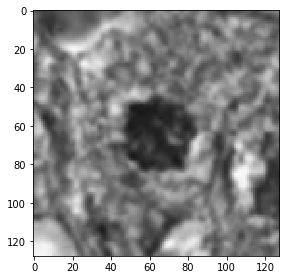

In [34]:
img = io.imread(r"/content/MandNM/mitosis/A00_01_01_CZ8UV4CK9-1a2574be1ed31c6659b0878de25f8c97.png", as_gray=True)

resized = resize(img, (128, 128))
img3 = img_as_ubyte(resized)

imshow(img3)
corners =  corner_peaks(corner_harris(img3),min_distance=1)

In [35]:
corners.flatten()

array([126,   1,   1, ...,  55,  73,   9])

In [36]:
category_corner = []
Array_corner = []
for folder in os.listdir("/content/MandNM/"):

    if(folder == ".DS_Store"):
        continue

    # Loop through each category
    for filename in os.listdir(path.join("/content/MandNM", folder)):

        # Select images which are png and jpg only
        if (filename[-3:] == "png" or filename[-3:] == "jpg"):

            # Get full image by joining
            # all the path to the image
            image = path.join("MandNM", folder, filename)

            # Use open cv to read the image
            img = io.imread(image, as_gray=True)
            resized = resize(img, (128, 128))
            img3 = img_as_ubyte(resized)
            corners =  corner_peaks(corner_harris(img3),min_distance=1)
            x_image_features = np.vstack(np.array(corners))
            scaler = MinMaxScaler(feature_range=(0,1))
            x_image_scaled = scaler.fit_transform(x_image_features)
            
            category_corner.append(folder)
            Array_corner.append(x_image_scaled.flatten())



# convert the extracted features
# from array to vector
cornerArray_np = np.array(Array_corner)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [37]:
cor_df = pd.DataFrame(Array_corner)
cor_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100,1101,1102,1103,1104,1105
0,0.0,1.000,1.000,1.000,0.000,0.152,1.000,0.536,0.000,0.848,0.192,1.000,0.952,0.000,0.000,0.752,1.000,0.000,1.000,0.168,1.000,0.064,0.392,0.000,0.992,0.888,0.432,0.000,0.816,0.000,0.232,1.000,1.000,0.104,1.000,0.480,0.744,0.480,0.896,0.136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.896,0.000,0.832,1.000,1.000,0.000,0.000,1.000,0.104,1.000,0.208,1.000,0.000,0.936,0.000,1.000,0.944,0.168,1.000,0.080,0.880,0.672,0.280,0.072,0.824,0.496,1.000,0.328,0.488,0.000,0.504,0.000,0.424,0.000,0.448,0.048,0.808,0.944,0.712,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.000,0.000,0.000,1.000,0.032,0.000,1.000,0.336,1.000,0.824,0.000,1.000,0.232,1.000,0.448,1.000,0.408,0.000,0.120,1.000,0.624,1.000,0.320,0.864,0.000,0.680,1.000,0.312,0.000,1.000,0.816,1.000,0.120,0.928,0.360,0.632,1.000,0.536,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.000,0.000,1.000,0.872,0.000,0.320,1.000,0.944,1.000,1.000,1.000,0.368,1.000,0.248,0.000,1.000,0.472,0.920,0.000,0.304,0.000,0.024,1.000,0.976,1.000,1.000,0.704,0.000,0.952,0.000,0.496,0.712,0.000,0.312,0.776,0.752,1.000,0.000,0.856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,1.000,1.000,1.000,1.000,0.000,1.000,0.720,0.040,0.000,0.856,1.000,0.088,1.000,0.136,0.000,0.600,0.000,0.000,0.248,0.624,1.000,0.000,0.176,0.824,0.000,1.000,0.448,1.000,0.616,0.064,0.000,1.000,0.032,0.000,0.000,0.912,1.000,0.240,0.952,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,0.0,1.000,0.304,1.000,0.352,1.000,1.000,0.016,0.712,1.000,0.160,1.000,0.576,0.000,0.640,1.000,0.768,1.000,0.376,0.528,0.136,1.000,0.256,0.000,0.664,0.000,0.072,1.000,0.640,0.472,0.808,0.000,0.520,1.000,0.552,0.960,0.480,0.000,0.480,0.384,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
428,1.0,0.000,0.120,1.000,1.000,0.200,0.832,1.000,0.296,1.000,0.032,1.000,1.000,1.000,0.000,0.288,0.112,0.000,0.264,1.000,1.000,0.256,0.432,0.000,0.320,0.000,0.720,0.000,0.000,0.248,0.000,0.344,0.000,0.072,0.072,0.000,0.184,0.000,0.208,0.784,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
429,0.0,0.000,1.000,1.000,0.328,1.000,0.000,0.880,1.000,0.864,0.400,1.000,0.000,0.584,0.000,0.200,0.096,0.000,0.920,0.000,0.000,0.304,0.000,0.960,1.000,0.936,0.240,0.448,0.000,0.392,0.000,0.632,0.000,0.344,1.000,0.576,0.256,0.472,1.000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
430,1.0,0.000,0.568,1.000,0.000,0.048,0.000,0.800,0.808,1.000,0.000,0.840,1.000,0.944,0.000,0.208,1.000,0.864,1.000,0.4

In [ ]:
Array_censure

In [ ]:
print("Total feature extracted from the each image",len(cornerArray_np[0]))


Total feature extracted from the each image 992


In [ ]:
temp_corner=ptoa(Array_corner)
corner_features=pca_reduction(temp_corner,100)

In [ ]:
csvData = []
for id, line in enumerate(corner_features):
  if(id==0):
    temp=[]
    for i in range(0,len(line)):
      temp.append("value"+str(i))
    temp.insert(len(temp),"label")
    csvData.append(temp)

  newImg = line

    # Prepend the category of each image to
    # the begining of the features
  newImg.insert(len(newImg), category[id])
  csvData.append(newImg)


# Save the csv file
with open('result_cor_data.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()

print("Done Extracting Features")

Done Extracting Features


In [ ]:
import pandas as pd

feature_cor=pd.read_csv("result_cor_data.csv")
feature_cor['label'] = feature_cor['label'].map({'nonmitosis': 1, 'mitosis': 0})
feature_cor

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16,value17,value18,value19,value20,value21,value22,value23,value24,value25,value26,value27,value28,value29,value30,value31,value32,value33,value34,value35,value36,value37,value38,value39,...,value61,value62,value63,value64,value65,value66,value67,value68,value69,value70,value71,value72,value73,value74,value75,value76,value77,value78,value79,value80,value81,value82,value83,value84,value85,value86,value87,value88,value89,value90,value91,value92,value93,value94,value95,value96,value97,value98,value99,label
0,-1.825965,-1.913059,-1.591668,0.451466,0.197213,0.581577,1.405052,-0.979154,0.197047,-0.921077,-0.469972,0.945904,1.217088,-0.821302,-0.336861,0.657817,0.961810,-0.861870,0.270375,-0.775678,0.972681,0.160063,0.285104,-0.839566,-0.099362,0.279497,0.327478,0.129949,1.079139,-0.339232,-0.208920,-0.842639,0.835254,0.735909,-0.711993,-0.118281,0.101085,-0.191504,0.289410,-0.273443,...,-0.467807,-0.041799,0.302853,0.492874,-0.260818,-0.181689,0.546652,-0.196146,0.167606,-0.078400,0.330983,-0.331725,1.063406,0.022565,0.473261,0.055019,0.344480,0.145509,0.012204,1.027238,0.181652,0.271899,-0.223091,0.394255,0.207574,-0.416819,-0.544316,-0.353086,-1.082411,-0.550099,0.630182,0.287952,0.661677,-0.703113,-0.412831,0.477722,-0.767604,-0.346714,1.330651,1
1,0.629580,-0.812207,-0.106574,-0.592183,-1.063478,0.518220,-0.759703,0.235938,0.676482,0.763253,-0.176593,0.795999,0.966171,-0.326977,0.905237,-0.165509,-0.688133,0.283299,0.465643,0.397549,-0.162825,-0.196853,0.353946,1.274052,1.094952,0.685154,-0.231539,0.004783,-0.447260,-0.900217,0.424160,-0.178340,-0.528099,-0.758771,-0.937333,-0.202349,-1.501616,0.158922,-0.629104,1.563928,...,-0.451470,0.660704,-0.438840,0.396559,-0.013624,-0.259997,0.530858,-0.904663,-0.533454,-1.377006,0.318129,-0.585386,-0.397588,-0.170218,0.348307,1.288755,-0.038565,0.473257,-0.218619,0.110362,0.804197,0.298968,0.339473,0.959642,0.487593,1.070787,-0.176150,-0.876494,1.491713,0.326835,-0.534831,-0.209472,-0.475919,0.115539,0.051694,0.537829,-0.845644,-0.815412,0.312594,1
2,-1.545817,0.182914,-1.316271,-0.175707,0.463428,-1.134125,0.259778,0.183364,-0.726783,0.848234,-0.677563,-1.503435,0.100375,0.003552,0.882406,0.604236,0.917557,0.043636,0.565227,0.163998,-0.309171,-0.788920,0.558826,0.029476,0.251200,0.623328,-0.046048,-0.551242,0.503926,-0.349091,-1.325507,-1.009848,0.719942,-0.905465,-0.344844,0.264379,-0.659354,0.992832,-0.826375,0.099823,...,-1.673611,0.107959,0.169262,-0.858976,0.781064,0.105032,0.781258,-0.539176,0.022871,-0.308035,-0.465062,-0.178702,-0.761872,0.864255,0.577007,-0.001764,0.307765,-0.071061,-0.161483,-0.120164,-0.257881,1.018383,0.550362,-0.526842,0.138112,-1.134642,0.265342,0.664564,0.028056,0.446728,0.670720,-0.755487,-0.304150,0.219257,0.488605,0.326091,1.611653,-0.048766,-0.388206,1
3,4.073867,2.595990,-1.838590,-0.633195,-0.267092,1.122847,-0.597014,0.042415,-1.112987,-0.249972,0.396462,0.429770,-0.534563,0.068405,0.455442,0.164989,0.092027,-0.551643,0.257313,0.619366,-0.266836,0.337993,0.466112,-0.312554,-0.416570,-0.420362,-0.601952,-1.441967,0.382946,-0.597209,0.199419,-0.202923,0.842926,-0.630978,0.965591,-0.666715,0.447032,0.160633,0.082817,0.617388,...,0.165855,-0.980438,0.141618,1.060668,-0.702932,0.923530,-0.497538,-0.416309,0.274575,0.632496,-0.460087,0.022139,-0.330757,0.704192,-0.304470,0.589436,0.414729,-0.367769,0.778283,0.625425,-0.212030,0.536231,-0.324384,0.055206,-0.343139,-0.113951,-0.383051,0.775560,-1.184534,0.040966,-0.559327,-0.299635,-0.318513,-0.260777,0.212153,0.710065,-0.293005,-0.388228,0.359697,1
4,3.506821,1.474008,0.168106,0.074550,1.110998,1.102356,0.600819,-0.236877,0.115575,0.581879,0.793382,0.668115,0.130433,-1.101513,0.425652,-0.426214,1.409745,-0.198352,0.037438,1.263981,-0.647163,-0.362504,0.629974,0.132699,-0.858169,0.283816,0.774117,-0.107862,-0.456204,-1.271087,0.280534,0.532581,0.466494,-0.329273,-0.531575,0.091022,1.0

In [ ]:
# feature_cor=normalize(feature_cor)

In [ ]:
feature_cor

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16,value17,value18,value19,value20,value21,value22,value23,value24,value25,value26,value27,value28,value29,value30,value31,value32,value33,value34,value35,value36,value37,value38,value39,...,value61,value62,value63,value64,value65,value66,value67,value68,value69,value70,value71,value72,value73,value74,value75,value76,value77,value78,value79,value80,value81,value82,value83,value84,value85,value86,value87,value88,value89,value90,value91,value92,value93,value94,value95,value96,value97,value98,value99,label
0,-1.825965,-1.913059,-1.591668,0.451466,0.197213,0.581577,1.405052,-0.979154,0.197047,-0.921077,-0.469972,0.945904,1.217088,-0.821302,-0.336861,0.657817,0.961810,-0.861870,0.270375,-0.775678,0.972681,0.160063,0.285104,-0.839566,-0.099362,0.279497,0.327478,0.129949,1.079139,-0.339232,-0.208920,-0.842639,0.835254,0.735909,-0.711993,-0.118281,0.101085,-0.191504,0.289410,-0.273443,...,-0.467807,-0.041799,0.302853,0.492874,-0.260818,-0.181689,0.546652,-0.196146,0.167606,-0.078400,0.330983,-0.331725,1.063406,0.022565,0.473261,0.055019,0.344480,0.145509,0.012204,1.027238,0.181652,0.271899,-0.223091,0.394255,0.207574,-0.416819,-0.544316,-0.353086,-1.082411,-0.550099,0.630182,0.287952,0.661677,-0.703113,-0.412831,0.477722,-0.767604,-0.346714,1.330651,1
1,0.629580,-0.812207,-0.106574,-0.592183,-1.063478,0.518220,-0.759703,0.235938,0.676482,0.763253,-0.176593,0.795999,0.966171,-0.326977,0.905237,-0.165509,-0.688133,0.283299,0.465643,0.397549,-0.162825,-0.196853,0.353946,1.274052,1.094952,0.685154,-0.231539,0.004783,-0.447260,-0.900217,0.424160,-0.178340,-0.528099,-0.758771,-0.937333,-0.202349,-1.501616,0.158922,-0.629104,1.563928,...,-0.451470,0.660704,-0.438840,0.396559,-0.013624,-0.259997,0.530858,-0.904663,-0.533454,-1.377006,0.318129,-0.585386,-0.397588,-0.170218,0.348307,1.288755,-0.038565,0.473257,-0.218619,0.110362,0.804197,0.298968,0.339473,0.959642,0.487593,1.070787,-0.176150,-0.876494,1.491713,0.326835,-0.534831,-0.209472,-0.475919,0.115539,0.051694,0.537829,-0.845644,-0.815412,0.312594,1
2,-1.545817,0.182914,-1.316271,-0.175707,0.463428,-1.134125,0.259778,0.183364,-0.726783,0.848234,-0.677563,-1.503435,0.100375,0.003552,0.882406,0.604236,0.917557,0.043636,0.565227,0.163998,-0.309171,-0.788920,0.558826,0.029476,0.251200,0.623328,-0.046048,-0.551242,0.503926,-0.349091,-1.325507,-1.009848,0.719942,-0.905465,-0.344844,0.264379,-0.659354,0.992832,-0.826375,0.099823,...,-1.673611,0.107959,0.169262,-0.858976,0.781064,0.105032,0.781258,-0.539176,0.022871,-0.308035,-0.465062,-0.178702,-0.761872,0.864255,0.577007,-0.001764,0.307765,-0.071061,-0.161483,-0.120164,-0.257881,1.018383,0.550362,-0.526842,0.138112,-1.134642,0.265342,0.664564,0.028056,0.446728,0.670720,-0.755487,-0.304150,0.219257,0.488605,0.326091,1.611653,-0.048766,-0.388206,1
3,4.073867,2.595990,-1.838590,-0.633195,-0.267092,1.122847,-0.597014,0.042415,-1.112987,-0.249972,0.396462,0.429770,-0.534563,0.068405,0.455442,0.164989,0.092027,-0.551643,0.257313,0.619366,-0.266836,0.337993,0.466112,-0.312554,-0.416570,-0.420362,-0.601952,-1.441967,0.382946,-0.597209,0.199419,-0.202923,0.842926,-0.630978,0.965591,-0.666715,0.447032,0.160633,0.082817,0.617388,...,0.165855,-0.980438,0.141618,1.060668,-0.702932,0.923530,-0.497538,-0.416309,0.274575,0.632496,-0.460087,0.022139,-0.330757,0.704192,-0.304470,0.589436,0.414729,-0.367769,0.778283,0.625425,-0.212030,0.536231,-0.324384,0.055206,-0.343139,-0.113951,-0.383051,0.775560,-1.184534,0.040966,-0.559327,-0.299635,-0.318513,-0.260777,0.212153,0.710065,-0.293005,-0.388228,0.359697,1
4,3.506821,1.474008,0.168106,0.074550,1.110998,1.102356,0.600819,-0.236877,0.115575,0.581879,0.793382,0.668115,0.130433,-1.101513,0.425652,-0.426214,1.409745,-0.198352,0.037438,1.263981,-0.647163,-0.362504,0.629974,0.132699,-0.858169,0.283816,0.774117,-0.107862,-0.456204,-1.271087,0.280534,0.532581,0.466494,-0.329273,-0.531575,0.091022,1.0

### classification based on corner features

In [ ]:
print("results for gridsearch:")
grid_search(feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1])

results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 30, 'max_features': 'log2', 'n_estimators': 200}
The KNN Model is trained well with the given images {'n_neighbors': 10}
The svm Model is trained well with the given images {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}


['Random forest:56.32183908045977',
 'KNN:0.6492753623188405',
 'svm:65.51724137931035']

In [ ]:
print("results for random search")
random_search(feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1])

results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 34, 'max_features': 23, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 28}
The KNN Model is trained well with the given images {'n_neighbors': 14}
The svm Model is trained well with the given images {'C': 8.6868927573379, 'kernel': 'poly'}


['Random forest:0.6434782608695652',
 'KNN:0.6492753623188406',
 'svm:0.6405797101449275']

In [ ]:
# print("results for hyperband")
# hyperband_opt(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

In [ ]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1])

results for Bayesian Optimization with Gaussian Process (BO-GP)
Splitted Successfully
The rf Model is trained well with the given images OrderedDict([('criterion', 'entropy'), ('max_depth', 33), ('max_features', 32), ('min_samples_leaf', 2), ('min_samples_split', 10), ('n_estimators', 38)])
The KNN Model is trained well with the given images OrderedDict([('n_neighbors', 12)])


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 1.0), ('kernel', 'rbf')])


['Random forest:0.6434782608695652',
 'KNN:0.6521739130434784',
 'svm:0.6434782608695652']

In [ ]:
print("results for skopt")
skopt_gp(feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1])

results for skopt
Splitted Successfully


['Random forest:0.6463768115942029',
 'KNN:0.6521739130434784',
 'svm:0.6405797101449275']

In [ ]:
print("result for bo_tpe")
bo_tpe(feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1])

result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:06<00:00,  2.99it/s, best loss: -0.6405797101449275]


["Random forest:{'criterion': 0, 'max_depth': 25.0, 'max_features': 56.0, 'min_samples_leaf': 8.0, 'min_samples_split': 7.0, 'n_estimators': 67.0}",
 "KNN:{'n_neighbors': 11.0}",
 "svm:{'C': 27.674396202674643, 'kernel': 1}"]

In [ ]:
print("result for genetic")
genetic(feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1])

result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min    	max     	std     
0  	10    	0.582609	0.53913	0.626087	0.031513
1  	5     	0.603768	0.556522	0.628986	0.0212229
2  	10    	0.618551	0.565217	0.628986	0.018614 
3  	7     	0.628696	0.626087	0.628986	0.000869565
4  	6     	0.627826	0.617391	0.628986	0.00347826 
5  	7     	0.627246	0.62029 	0.628986	0.00347826 
Best individual is: {'n_estimators': 97, 'max_features': 49, 'max_depth': 24, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'entropy'}
with fitness: 0.6289855072463768
The rf Model is trained well with the given images {'n_estimators': 97, 'max_features': 49, 'max_depth': 24, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.606667	0.547826	0.652174	0.0338783
1  	6     	0.636812	0.623188	0.652174	0.0136601
2  	5     	0.651014	0.649275	0.652174	0.00141999
3  	7     	0.651884	0.649275	0.652174	0.000869565
4  	7     	0.649275	0.623188	0.652174	0.00869565 
5  	5     	0.652174	0.652174	0.652174	0          
Best individual is: {'n_neighbors': 12}
with fitness: 0.6521739130434783
The knn Model is trained well with the given images {'n_neighbors': 12}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max    	std      
0  	10    	0.581159	0.542029	0.64058	0.0333837
1  	3     	0.604638	0.55942 	0.64058	0.0182953
2  	4     	0.616232	0.605797	0.64058	0.0159394
3  	8     	0.623188	0.605797	0.64058	0.0173913
4  	4     	0.64058 	0.64058 	0.64058	0        
5  	4     	0.64058 	0.64058 	0.64058	0        
Best individual is: {'C': 39.054781811159664, 'kernel': 'poly'}
with fitness: 0.6405797101449275
The rf Model is trained well with the given images {'C': 39.054781811159664, 'kernel': 'poly'}


['Random forest:0.6289855072463768',
 'KNN:0.6521739130434783',
 'svm:0.6405797101449275']

In [ ]:
print("result for tpot")
tpot(feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1])

result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6463768115942029	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=21, RandomForestClassifier__max_features=50, RandomForestClassifier__min_samples_leaf=5, RandomForestClassifier__min_samples_split=7, RandomForestClassifier__n_estimators=92)

Generation 2 - Current Pareto front scores:

-1	0.6492753623188406	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=21, RandomForestClassifier__max_features=50, RandomForestClassifier__min_samples_leaf=2, RandomForestClassifier__min_samples_split=7, RandomForestClassifier__n_estimators=92)

Generation 3 - Current Pareto front scores:

-1	0.6492753623188406	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=21, RandomForestClassifier__max_features=50, RandomForestClassifier__min_samples_leaf=2, RandomForestCla

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6521739130434784	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=12)

Generation 2 - Current Pareto front scores:

-1	0.6521739130434784	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=12)

Generation 3 - Current Pareto front scores:

-1	0.6521739130434784	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=12)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6405797101449275	SVC(input_matrix, SVC__C=40.842007187992934, SVC__kernel=poly)

-2	0.6550724637681159	SVC(SVC(input_matrix, SVC__C=31.729479051542636, SVC__kernel=poly), SVC__C=8.284996985815173, SVC__kernel=poly)

Generation 2 - Current Pareto front scores:

-1	0.6405797101449275	SVC(input_matrix, SVC__C=40.842007187992934, SVC__kernel=poly)

-2	0.6550724637681159	SVC(SVC(input_matrix, SVC__C=31.729479051542636, SVC__kernel=poly), SVC__C=8.284996985815173, SVC__kernel=poly)

Generation 3 - Current Pareto front scores:

-1	0.6405797101449275	SVC(input_matrix, SVC__C=40.842007187992934, SVC__kernel=poly)

-2	0.6550724637681159	SVC(SVC(input_matrix, SVC__C=31.729479051542636, SVC__kernel=poly), SVC__C=8.284996985815173, SVC__kernel=poly)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


['Random forest:65.51724137931035',
 'knn:62.06896551724138',
 'svm:66.66666666666666']

### combining hog and orb and cen

In [ ]:
orbhogcencor_temp=[orb_hog_cen.iloc[:,:-1],feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1]]
orb_hog_cen_cor=pd.concat(orbhogcencor_temp, axis=1)
orb_hog_cen_cor

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16,value17,value18,value19,value20,value21,value22,value23,value24,value25,value26,value27,value28,value29,value30,value31,value32,value33,value34,value35,value36,value37,value38,value39,...,value61,value62,value63,value64,value65,value66,value67,value68,value69,value70,value71,value72,value73,value74,value75,value76,value77,value78,value79,value80,value81,value82,value83,value84,value85,value86,value87,value88,value89,value90,value91,value92,value93,value94,value95,value96,value97,value98,value99,label
0,-0.568261,0.135315,0.557027,2.057404,0.324491,0.310445,1.173912,0.447988,-1.016115,-0.010653,-0.197807,-0.408061,-1.119411,-0.358027,0.604974,-0.455506,-0.809204,1.387526,0.173811,0.022881,-0.662020,0.713469,-0.604149,-1.003721,0.109491,1.261016,-0.854814,-0.885796,-0.456492,-0.039874,-1.859251,-1.080198,-0.848804,0.232902,0.798459,0.189735,0.632276,-0.352404,0.174246,-0.395496,...,-0.467807,-0.041799,0.302853,0.492874,-0.260818,-0.181689,0.546652,-0.196146,0.167606,-0.078400,0.330983,-0.331725,1.063406,0.022565,0.473261,0.055019,0.344480,0.145509,0.012204,1.027238,0.181652,0.271899,-0.223091,0.394255,0.207574,-0.416819,-0.544316,-0.353086,-1.082411,-0.550099,0.630182,0.287952,0.661677,-0.703113,-0.412831,0.477722,-0.767604,-0.346714,1.330651,1
1,0.072766,-1.314068,-0.333010,0.737812,0.825911,-1.143673,0.676719,0.344632,-0.026440,-0.803812,-0.717636,0.236412,-0.001813,1.136594,0.583204,-0.356051,-0.069518,-1.521234,-0.561440,1.775314,-0.343884,-0.426231,0.436249,-0.462886,0.653075,-0.067205,-0.345553,-0.343802,0.201964,0.601322,-0.247720,-1.082844,-0.847306,-1.117991,-0.406924,-0.088853,0.296962,1.205530,-0.271433,0.371673,...,-0.451470,0.660704,-0.438840,0.396559,-0.013624,-0.259997,0.530858,-0.904663,-0.533454,-1.377006,0.318129,-0.585386,-0.397588,-0.170218,0.348307,1.288755,-0.038565,0.473257,-0.218619,0.110362,0.804197,0.298968,0.339473,0.959642,0.487593,1.070787,-0.176150,-0.876494,1.491713,0.326835,-0.534831,-0.209472,-0.475919,0.115539,0.051694,0.537829,-0.845644,-0.815412,0.312594,1
2,0.245757,2.383341,-0.138226,0.148015,0.206508,0.147450,1.297806,0.255086,-0.716606,0.476243,-0.104805,-0.028483,-0.629036,0.291190,-1.630016,0.301932,-0.752725,0.853065,-0.266042,-0.561334,-1.176564,-0.015849,-0.619224,-0.704656,0.627949,-0.416619,0.076397,0.140591,-0.156478,-0.518681,-0.507872,0.282757,0.420154,0.253845,-0.313785,-0.757888,0.957124,-0.153221,-1.308015,0.624861,...,-1.673611,0.107959,0.169262,-0.858976,0.781064,0.105032,0.781258,-0.539176,0.022871,-0.308035,-0.465062,-0.178702,-0.761872,0.864255,0.577007,-0.001764,0.307765,-0.071061,-0.161483,-0.120164,-0.257881,1.018383,0.550362,-0.526842,0.138112,-1.134642,0.265342,0.664564,0.028056,0.446728,0.670720,-0.755487,-0.304150,0.219257,0.488605,0.326091,1.611653,-0.048766,-0.388206,1
3,-1.438643,4.343278,-1.943192,0.209219,-0.318492,0.137997,-0.706037,0.284897,-0.758950,-0.693462,-0.052654,0.058357,0.568426,0.493785,0.565549,-0.334240,0.618754,0.490052,0.321997,1.016196,0.423911,-0.968911,0.127268,0.668440,0.815153,-0.674957,-0.967060,0.273884,0.098398,-0.366441,0.144054,-0.415843,0.189376,1.160709,0.704100,1.029650,-0.142085,0.135850,1.272406,-0.028625,...,0.165855,-0.980438,0.141618,1.060668,-0.702932,0.923530,-0.497538,-0.416309,0.274575,0.632496,-0.460087,0.022139,-0.330757,0.704192,-0.304470,0.589436,0.414729,-0.367769,0.778283,0.625425,-0.212030,0.536231,-0.324384,0.055206,-0.343139,-0.113951,-0.383051,0.775560,-1.184534,0.040966,-0.559327,-0.299635,-0.318513,-0.260777,0.212153,0.710065,-0.293005,-0.388228,0.359697,1
4,1.067980,0.916442,0.439403,0.248737,4.264154,1.129122,-0.996633,-0.851929,-0.045080,0.147051,-0.170295,0.150187,-0.666075,-0.369404,0.824191,-1.199857,-0.019365,0.007467,1.083949,-0.257006,0.701711,0.592636,0.826999,0.580147,0.035712,-0.798296,-0.359018,0.331121,-0.465734,-0.884251,-0.313307,0.505927,-0.683029,-0.518779,-0.385431,0.

### classification based on hog,censure,orb corner features

In [ ]:
print("results for gridsearch:")
grid_search(orb_hog_cen_cor.iloc[:,:-1],orb_hog_cen_cor.iloc[:,-1])

results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 200}
The KNN Model is trained well with the given images {'n_neighbors': 20}
The svm Model is trained well with the given images {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


['Random forest:85.0574712643678',
 'KNN:0.6811594202898551',
 'svm:91.95402298850574']

In [ ]:
print("results for random search")
random_search(orb_hog_cen_cor.iloc[:,:-1],orb_hog_cen_cor.iloc[:,-1])

results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 7, 'max_features': 53, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 80}
The KNN Model is trained well with the given images {'n_neighbors': 11}
The svm Model is trained well with the given images {'C': 48.936657928737, 'kernel': 'rbf'}


['Random forest:0.7362318840579709',
 'KNN:0.6869565217391305',
 'svm:0.7478260869565218']

In [ ]:
# print("results for hyperband")
# hyperband_opt(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

In [ ]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(orb_hog_cen_cor.iloc[:,:-1],orb_hog_cen_cor.iloc[:,-1])

results for Bayesian Optimization with Gaussian Process (BO-GP)
Splitted Successfully
The rf Model is trained well with the given images OrderedDict([('criterion', 'gini'), ('max_depth', 5), ('max_features', 41), ('min_samples_leaf', 6), ('min_samples_split', 8), ('n_estimators', 100)])
The KNN Model is trained well with the given images OrderedDict([('n_neighbors', 13)])


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'rbf')])


['Random forest:0.7362318840579709',
 'KNN:0.6811594202898551',
 'svm:0.7478260869565218']

In [ ]:
print("results for skopt")
skopt_gp(orb_hog_cen_cor.iloc[:,:-1],orb_hog_cen_cor.iloc[:,-1])

results for skopt
Splitted Successfully


['Random forest:0.7565217391304347',
 'KNN:0.6811594202898551',
 'svm:0.7478260869565218']

In [ ]:
print("result for bo_tpe")
bo_tpe(orb_hog_cen_cor.iloc[:,:-1],orb_hog_cen_cor.iloc[:,-1])

result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 13.51it/s, best loss: -0.7478260869565218]


["Random forest:{'criterion': 1, 'max_depth': 43.0, 'max_features': 52.0, 'min_samples_leaf': 3.0, 'min_samples_split': 8.0, 'n_estimators': 39.0}",
 "KNN:{'n_neighbors': 13.0}",
 "svm:{'C': -39.58383783179688, 'kernel': 2}"]

In [ ]:
print("result for genetic")
genetic(orb_hog_cen_cor.iloc[:,:-1],orb_hog_cen_cor.iloc[:,-1])

result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.656812	0.605797	0.707246	0.0340305
1  	8     	0.693333	0.655072	0.721739	0.0202401
2  	4     	0.709275	0.681159	0.724638	0.0125712
3  	6     	0.713623	0.681159	0.724638	0.0128193
4  	7     	0.721449	0.713043	0.724638	0.0043863
5  	6     	0.724638	0.724638	0.724638	1.11022e-16
Best individual is: {'n_estimators': 68, 'max_features': 44, 'max_depth': 37, 'min_samples_split': 5, 'min_samples_leaf': 6, 'criterion': 'entropy'}
with fitness: 0.7246376811594203
The rf Model is trained well with the given images {'n_estimators': 68, 'max_features': 44, 'max_depth': 37, 'min_samples_split': 5, 'min_samples_leaf': 6, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.670145	0.634783	0.686957	0.0144812
1  	7     	0.676812	0.666667	0.686957	0.008017 
2  	5     	0.686377	0.681159	0.686957	0.00173913
3  	6     	0.686957	0.686957	0.686957	0         
4  	6     	0.686957	0.686957	0.686957	0         
5  	6     	0.686957	0.686957	0.686957	0         
Best individual is: {'n_neighbors': 11}
with fitness: 0.6869565217391305
The knn Model is trained well with the given images {'n_neighbors': 11}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min     	max     	std      
0  	10    	0.72029	0.657971	0.747826	0.0330295
1  	6     	0.736812	0.692754	0.747826	0.0157058
2  	6     	0.74087 	0.701449	0.747826	0.0136078
3  	7     	0.746957	0.73913 	0.747826	0.0026087
4  	9     	0.747826	0.747826	0.747826	0        
5  	6     	0.747826	0.747826	0.747826	0        
Best individual is: {'C': 34.55077441924328, 'kernel': 'rbf'}
with fitness: 0.7478260869565218
The rf Model is trained well with the given images {'C': 34.55077441924328, 'kernel': 'rbf'}


['Random forest:0.7246376811594203',
 'KNN:0.6869565217391305',
 'svm:0.7478260869565218']

In [ ]:
print("result for tpot")
tpot(orb_hog_cen_cor.iloc[:,:-1],orb_hog_cen_cor.iloc[:,-1])

result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.736231884057971	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=59, RandomForestClassifier__max_features=34, RandomForestClassifier__min_samples_leaf=7, RandomForestClassifier__min_samples_split=7, RandomForestClassifier__n_estimators=41)

Generation 2 - Current Pareto front scores:

-1	0.7478260869565218	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=82, RandomForestClassifier__max_features=50, RandomForestClassifier__min_samples_leaf=5, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=145)

Generation 3 - Current Pareto front scores:

-1	0.7478260869565218	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=82, RandomForestClassifier__max_features=50, RandomF

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 1 - Current Pareto front scores:

-1	0.6811594202898551	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=13)

Generation 2 - Current Pareto front scores:

-1	0.6869565217391305	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=11)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 3 - Current Pareto front scores:

-1	0.6869565217391305	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=11)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7478260869565218	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=29.408211496030116, SVC__kernel=rbf)

Generation 2 - Current Pareto front scores:

-1	0.7478260869565218	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=29.408211496030116, SVC__kernel=rbf)

Generation 3 - Current Pareto front scores:

-1	0.7478260869565218	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=29.408211496030116, SVC__kernel=rbf)


['Random forest:82.75862068965517',
 'knn:73.5632183908046',
 'svm:89.65517241379311']

### edgeExtract 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # Remove the CWD from sys.path while we load stuff.


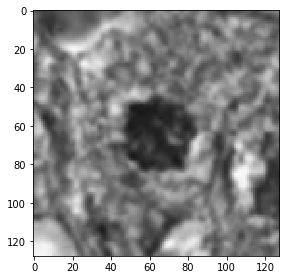

In [38]:
img = io.imread(r"/content/MandNM/mitosis/A00_01_01_CZ8UV4CK9-1a2574be1ed31c6659b0878de25f8c97.png", as_gray=True)

resized = resize(img, (128, 128))
img3 = img_as_ubyte(resized)

imshow(img3)
edge =  edgeExtract(resized, 100)

In [39]:
category_edge = []
Array_edge = []
for folder in os.listdir("/content/MandNM/"):

    if(folder == ".DS_Store"):
        continue

    # Loop through each category
    for filename in os.listdir(path.join("/content/MandNM", folder)):

        # Select images which are png and jpg only
        if (filename[-3:] == "png" or filename[-3:] == "jpg"):

            # Get full image by joining
            # all the path to the image
            image = path.join("MandNM", folder, filename)

            # Use open cv to read the image
            img = io.imread(image, as_gray=True)
            resized = resize(img, (128, 128))
            img3 = img_as_ubyte(resized)
            edge =  edgeExtract(img, 100)
            
            category_edge.append(folder)
            Array_edge.append(edge)



# convert the extracted features
# from array to vector
edgeArray_np = np.array(Array_edge)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # Remove the CWD from sys.path while we load stuff.


In [40]:
edg_df = pd.DataFrame(Array_edge)
edg_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,17.687627,13.002028,11.115619,8.782961,7.160243,6.572008,5.375254,4.705882,3.427992,2.555781,2.352941,2.231237,1.744422,1.643002,1.440162,1.156187,0.953347,1.075051,0.649087,0.750507,0.831643,0.507099,0.689655,0.425963,0.365112,0.527383,0.202840,0.405680,0.182556,0.304260,0.101420,0.101420,0.202840,0.040568,0.141988,0.141988,0.101420,0.101420,0.060852,0.060852,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12.487805,11.882927,10.321951,9.795122,8.604878,7.102439,5.717073,5.658537,4.448780,3.960976,3.570732,2.829268,2.282927,1.990244,1.736585,1.326829,0.858537,0.936585,0.721951,0.546341,0.702439,0.448780,0.175610,0.234146,0.214634,0.214634,0.078049,0.117073,0.078049,0.117073,0.058537,0.000000,0.058537,0.058537,0.078049,0.019512,0.097561,0.019512,0.039024,0.019512,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8.087215,8.860258,8.225966,8.146680,7.472745,6.065411,6.144698,5.708622,5.411298,5.034688,3.885035,3.627354,3.032706,2.438057,2.418236,2.180377,1.684836,1.546085,1.744301,1.030723,1.110010,1.050545,1.050545,0.614470,0.555005,0.396432,0.416254,0.475719,0.198216,0.178394,0.218038,0.118930,0.118930,0.138751,0.158573,0.079286,0.059465,0.039643,0.039643,0.039643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,15.267909,11.522950,9.640868,8.008450,7.874016,6.587286,5.185327,4.436336,3.840983,3.783369,3.207221,2.707893,2.919147,2.727098,1.958901,1.594008,1.517188,1.075475,1.094680,0.864221,0.902631,0.595352,0.499328,0.422508,0.268869,0.403303,0.172844,0.172844,0.096025,0.172844,0.096025,0.000000,0.096025,0.000000,0.019205,0.057615,0.038410,0.000000,0.076820,0.019205,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10.947037,9.686946,7.954322,6.635164,6.103564,5.414452,4.311872,4.764717,3.819650,3.583383,3.642449,2.461114,2.539870,2.283914,2.618626,2.106714,2.205158,1.614491,1.949203,1.732625,1.260091,1.299468,0.964757,1.082890,0.925379,0.767868,0.748179,0.728490,0.846623,0.531601,0.531601,0.649734,0.630045,0.393778,0.354400,0.295334,0.354400,0.255956,0.196889,0.137822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,9.206030,9.105528,8.603015,7.758794,7.939698,6.974874,5.748744,5.547739,4.341709,4.381910,4.201005,3.738693,2.874372,2.914573,2.010050,1.829146,1.507538,1.547739,1.246231,1.105528,0.944724,0.984925,0.904523,0.542714,0.422111,0.402010,0.522613,0.301508,0.301508,0.201005,0.301508,0.160804,0.201005,0.140704,0.140704,0.140704,0.201005,0.140704,0.160804,0.080402,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
428,9.452244,9.590666,8.997429,8.423967,7.079296,7.257267,5.892822,5.912596,4.113111,3.796717,4.389955,2.887087,2.867313,2.550920,1.918133,2.135654,1.839035,1.522642,1.364445,1.067827,0.870081,0.810757,0.810757,0.573463,0.415266,0

In [ ]:
edge_features=pca_reduction(edgeArray_np,n=100)

In [ ]:
csvData = []
for id, line in enumerate(edge_features):
  if(id==0):
    temp=[]
    for i in range(0,len(line)):
      temp.append("value"+str(i))
    temp.insert(len(temp),"label")
    csvData.append(temp)

  newImg = line

    # Prepend the category of each image to
    # the begining of the features
  newImg.insert(len(newImg), category[id])
  csvData.append(newImg)


# Save the csv file
with open('result_edge_data.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()

print("Done Extracting Features")

Done Extracting Features


In [ ]:
import pandas as pd

feature_edge=pd.read_csv("result_edge_data.csv")
feature_edge['label'] = feature_edge['label'].map({'nonmitosis': 1, 'mitosis': 0})
feature_edge

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16,value17,value18,value19,value20,value21,value22,value23,value24,value25,value26,value27,value28,value29,value30,value31,value32,value33,value34,value35,value36,value37,value38,value39,...,value61,value62,value63,value64,value65,value66,value67,value68,value69,value70,value71,value72,value73,value74,value75,value76,value77,value78,value79,value80,value81,value82,value83,value84,value85,value86,value87,value88,value89,value90,value91,value92,value93,value94,value95,value96,value97,value98,value99,label
0,8.282979,0.001290,-0.925920,-0.424034,-0.610575,0.508228,-0.121180,-0.126917,0.240918,-0.159411,-0.510304,-0.257108,-0.085865,0.120548,-0.093174,0.042462,0.005809,0.019667,0.131004,-0.078563,0.239317,-0.066550,0.215175,-0.044833,-0.085560,-0.123041,-0.100487,-0.087180,0.142868,-0.130455,0.050087,0.035660,-0.053213,-0.070204,-0.075766,-0.041468,0.025782,0.053062,-0.022837,0.026819,...,0.002003,0.001358,-0.001013,-0.000204,-0.000634,0.001350,0.000722,-1.254287e-15,5.710964e-16,-3.675367e-17,-3.937712e-17,-3.150181e-16,1.272415e-16,1.338428e-16,2.098682e-16,3.256275e-16,-2.676034e-16,2.937197e-17,3.281299e-17,-6.324133e-17,-2.089201e-17,2.377250e-17,2.635834e-16,1.558248e-16,-1.896115e-16,4.912599e-17,7.318729e-17,-1.062794e-16,-7.237542e-16,1.296719e-15,1.733301e-16,-3.105946e-16,1.066719e-16,-3.756547e-16,-7.583303e-17,1.017896e-16,-1.812470e-16,-1.952382e-16,2.563031e-16,1
1,2.972470,-2.748293,-0.182497,-0.214711,0.595277,-0.410409,0.096369,-0.273087,0.199205,-0.167352,-0.106436,0.159041,-0.034131,-0.043338,0.039705,-0.038426,-0.149547,0.026517,0.265458,-0.196198,0.020794,0.044968,-0.145645,-0.034272,-0.019026,0.006725,0.022498,-0.069720,0.051013,-0.004128,0.076383,-0.020874,-0.038165,-0.011509,-0.002033,-0.073113,-0.036632,-0.027696,-0.032991,-0.025107,...,-0.000768,-0.000143,-0.001927,-0.002043,-0.000479,0.000139,-0.000238,1.085993e-15,1.698961e-16,-2.221054e-16,-1.695216e-16,-4.214289e-16,-5.730222e-16,-6.058527e-16,1.861848e-16,6.751433e-17,-1.533931e-16,-4.223231e-16,2.517658e-18,-1.558116e-16,-7.434242e-17,-3.378070e-16,-2.130538e-16,5.166894e-16,-1.294149e-17,1.333010e-16,-3.633595e-16,2.731254e-16,2.465889e-16,2.500915e-17,1.458461e-16,-4.525559e-16,3.427879e-16,-7.207636e-17,1.953013e-16,-1.855892e-16,4.380046e-16,-2.654511e-18,1.222392e-16,1
2,-3.356378,-0.491066,0.142374,0.237344,0.337848,-0.441262,0.474836,0.247135,0.275498,0.367078,0.457945,-0.077359,-0.120600,0.019339,-0.153814,0.128166,-0.206389,-0.388213,0.089807,-0.048456,-0.240651,-0.106769,0.150583,-0.150306,-0.089192,0.012995,-0.055934,0.050056,0.184870,0.058183,0.004152,0.020089,-0.050837,-0.024055,0.060396,0.010534,-0.006760,-0.028210,0.013282,0.010785,...,-0.001170,0.000313,0.000446,0.000552,-0.000950,0.001273,0.001444,2.290664e-15,2.082049e-16,2.827116e-16,4.796858e-16,-3.593106e-16,1.978935e-16,-4.716999e-17,9.390912e-17,-4.281526e-16,-1.332493e-16,-5.307263e-16,2.377246e-16,2.379210e-16,-1.681940e-16,2.429527e-16,-4.055151e-16,1.342358e-16,-5.108393e-16,1.618207e-17,4.711582e-16,2.413230e-16,2.439604e-16,5.798966e-16,8.789507e-17,-2.993134e-16,-3.236036e-16,3.941364e-16,-2.699599e-16,4.915005e-17,1.218088e-16,8.974564e-17,1.957443e-16,1
3,4.742051,0.566524,-0.021253,-0.218969,0.128974,-0.575499,-0.662326,0.027627,-0.518943,-0.567877,0.115718,-0.041733,0.618231,0.020963,0.182087,-0.018979,0.204668,-0.062018,-0.189690,-0.202022,0.020917,0.055414,0.028597,-0.024052,-0.061154,-0.110904,-0.006479,-0.092383,0.067659,-0.058974,0.016985,-0.044105,-0.025641,0.002046,-0.052357,-0.005285,-0.034048,0.016561,-0.019617,-0.006728,...,0.001517,0.000963,-0.000121,-0.000203,-0.000906,-0.000133,-0.000205,6.137137e-16,3.593122e-16,2.395436e-16,3.008621e-16,3.567784e-16,-1.740246e-16,-2.758645e-16,-1.405757e-16,6.616551e-16,1.366025e-17,4.324643e-16,2.831546e-16,2.655810e-16,-5.491563e-16,1.720622e-16,3.554864e-16,1.482288e-16,-2.313448e-16,9.659981

In [ ]:
feature_edge

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16,value17,value18,value19,value20,value21,value22,value23,value24,value25,value26,value27,value28,value29,value30,value31,value32,value33,value34,value35,value36,value37,value38,value39,...,value61,value62,value63,value64,value65,value66,value67,value68,value69,value70,value71,value72,value73,value74,value75,value76,value77,value78,value79,value80,value81,value82,value83,value84,value85,value86,value87,value88,value89,value90,value91,value92,value93,value94,value95,value96,value97,value98,value99,label
0,8.282979,0.001290,-0.925920,-0.424034,-0.610575,0.508228,-0.121180,-0.126917,0.240918,-0.159411,-0.510304,-0.257108,-0.085865,0.120548,-0.093174,0.042462,0.005809,0.019667,0.131004,-0.078563,0.239317,-0.066550,0.215175,-0.044833,-0.085560,-0.123041,-0.100487,-0.087180,0.142868,-0.130455,0.050087,0.035660,-0.053213,-0.070204,-0.075766,-0.041468,0.025782,0.053062,-0.022837,0.026819,...,0.002003,0.001358,-0.001013,-0.000204,-0.000634,0.001350,0.000722,-1.254287e-15,5.710964e-16,-3.675367e-17,-3.937712e-17,-3.150181e-16,1.272415e-16,1.338428e-16,2.098682e-16,3.256275e-16,-2.676034e-16,2.937197e-17,3.281299e-17,-6.324133e-17,-2.089201e-17,2.377250e-17,2.635834e-16,1.558248e-16,-1.896115e-16,4.912599e-17,7.318729e-17,-1.062794e-16,-7.237542e-16,1.296719e-15,1.733301e-16,-3.105946e-16,1.066719e-16,-3.756547e-16,-7.583303e-17,1.017896e-16,-1.812470e-16,-1.952382e-16,2.563031e-16,1
1,2.972470,-2.748293,-0.182497,-0.214711,0.595277,-0.410409,0.096369,-0.273087,0.199205,-0.167352,-0.106436,0.159041,-0.034131,-0.043338,0.039705,-0.038426,-0.149547,0.026517,0.265458,-0.196198,0.020794,0.044968,-0.145645,-0.034272,-0.019026,0.006725,0.022498,-0.069720,0.051013,-0.004128,0.076383,-0.020874,-0.038165,-0.011509,-0.002033,-0.073113,-0.036632,-0.027696,-0.032991,-0.025107,...,-0.000768,-0.000143,-0.001927,-0.002043,-0.000479,0.000139,-0.000238,1.085993e-15,1.698961e-16,-2.221054e-16,-1.695216e-16,-4.214289e-16,-5.730222e-16,-6.058527e-16,1.861848e-16,6.751433e-17,-1.533931e-16,-4.223231e-16,2.517658e-18,-1.558116e-16,-7.434242e-17,-3.378070e-16,-2.130538e-16,5.166894e-16,-1.294149e-17,1.333010e-16,-3.633595e-16,2.731254e-16,2.465889e-16,2.500915e-17,1.458461e-16,-4.525559e-16,3.427879e-16,-7.207636e-17,1.953013e-16,-1.855892e-16,4.380046e-16,-2.654511e-18,1.222392e-16,1
2,-3.356378,-0.491066,0.142374,0.237344,0.337848,-0.441262,0.474836,0.247135,0.275498,0.367078,0.457945,-0.077359,-0.120600,0.019339,-0.153814,0.128166,-0.206389,-0.388213,0.089807,-0.048456,-0.240651,-0.106769,0.150583,-0.150306,-0.089192,0.012995,-0.055934,0.050056,0.184870,0.058183,0.004152,0.020089,-0.050837,-0.024055,0.060396,0.010534,-0.006760,-0.028210,0.013282,0.010785,...,-0.001170,0.000313,0.000446,0.000552,-0.000950,0.001273,0.001444,2.290664e-15,2.082049e-16,2.827116e-16,4.796858e-16,-3.593106e-16,1.978935e-16,-4.716999e-17,9.390912e-17,-4.281526e-16,-1.332493e-16,-5.307263e-16,2.377246e-16,2.379210e-16,-1.681940e-16,2.429527e-16,-4.055151e-16,1.342358e-16,-5.108393e-16,1.618207e-17,4.711582e-16,2.413230e-16,2.439604e-16,5.798966e-16,8.789507e-17,-2.993134e-16,-3.236036e-16,3.941364e-16,-2.699599e-16,4.915005e-17,1.218088e-16,8.974564e-17,1.957443e-16,1
3,4.742051,0.566524,-0.021253,-0.218969,0.128974,-0.575499,-0.662326,0.027627,-0.518943,-0.567877,0.115718,-0.041733,0.618231,0.020963,0.182087,-0.018979,0.204668,-0.062018,-0.189690,-0.202022,0.020917,0.055414,0.028597,-0.024052,-0.061154,-0.110904,-0.006479,-0.092383,0.067659,-0.058974,0.016985,-0.044105,-0.025641,0.002046,-0.052357,-0.005285,-0.034048,0.016561,-0.019617,-0.006728,...,0.001517,0.000963,-0.000121,-0.000203,-0.000906,-0.000133,-0.000205,6.137137e-16,3.593122e-16,2.395436e-16,3.008621e-16,3.567784e-16,-1.740246e-16,-2.758645e-16,-1.405757e-16,6.616551e-16,1.366025e-17,4.324643e-16,2.831546e-16,2.655810e-16,-5.491563e-16,1.720622e-16,3.554864e-16,1.482288e-16,-2.313448e-16,9.659981

### classification based on edge features

In [ ]:
print("results for gridsearch:")
grid_search(feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1])

results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 100}
The KNN Model is trained well with the given images {'n_neighbors': 2}
The svm Model is trained well with the given images {'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}


['Random forest:68.96551724137932',
 'KNN:0.582608695652174',
 'svm:74.71264367816092']

In [ ]:
print("results for random search")
random_search(feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1])

results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 49, 'max_features': 54, 'min_samples_leaf': 6, 'min_samples_split': 9, 'n_estimators': 65}
The KNN Model is trained well with the given images {'n_neighbors': 18}
The svm Model is trained well with the given images {'C': 18.83421109492909, 'kernel': 'poly'}


['Random forest:0.5884057971014492',
 'KNN:0.591304347826087',
 'svm:0.5652173913043478']

In [ ]:
# print("results for hyperband")
# hyperband_opt(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

In [ ]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1])

results for Bayesian Optimization with Gaussian Process (BO-GP)
Splitted Successfully
The rf Model is trained well with the given images OrderedDict([('criterion', 'gini'), ('max_depth', 46), ('max_features', 2), ('min_samples_leaf', 9), ('min_samples_split', 4), ('n_estimators', 100)])
The KNN Model is trained well with the given images OrderedDict([('n_neighbors', 16)])


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 0.1), ('kernel', 'linear')])


['Random forest:0.582608695652174',
 'KNN:0.5971014492753624',
 'svm:0.5942028985507247']

In [ ]:
print("results for skopt")
skopt_gp(feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1])

results for skopt
Splitted Successfully


['Random forest:0.591304347826087',
 'KNN:0.591304347826087',
 'svm:0.6028985507246377']

In [ ]:
print("result for bo_tpe")
bo_tpe(feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1])

result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:04<00:00,  4.56it/s, best loss: -0.5710144927536231]


["Random forest:{'criterion': 0, 'max_depth': 18.0, 'max_features': 47.0, 'min_samples_leaf': 7.0, 'min_samples_split': 11.0, 'n_estimators': 28.0}",
 "KNN:{'n_neighbors': 17.0}",
 "svm:{'C': -3.355679507189631, 'kernel': 2}"]

In [ ]:
print("result for genetic")
genetic(feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1])

result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std     
0  	10    	0.562609	0.533333	0.594203	0.017413
1  	7     	0.585507	0.573913	0.594203	0.00888679
2  	6     	0.589565	0.55942 	0.597101	0.0110145 
3  	2     	0.594783	0.594203	0.597101	0.00115942
4  	6     	0.589275	0.553623	0.597101	0.0125712 
5  	7     	0.595072	0.585507	0.597101	0.0041094 
Best individual is: {'n_estimators': 92, 'max_features': 14, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'gini'}
with fitness: 0.5971014492753624
The rf Model is trained well with the given images {'n_estimators': 92, 'max_features': 14, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.566087	0.536232	0.591304	0.0199158
1  	5     	0.57971 	0.568116	0.591304	0.00698063
2  	6     	0.586087	0.582609	0.591304	0.00425998
3  	6     	0.589565	0.582609	0.591304	0.00347826
4  	1     	0.591304	0.591304	0.591304	0         
5  	7     	0.591304	0.591304	0.591304	0         
Best individual is: {'n_neighbors': 18}
with fitness: 0.591304347826087
The knn Model is trained well with the given images {'n_neighbors': 18}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std     
0  	10    	0.536232	0.489855	0.571014	0.031963
1  	5     	0.555942	0.536232	0.571014	0.0104348
2  	7     	0.56029 	0.536232	0.571014	0.0113784
3  	4     	0.566957	0.55942 	0.571014	0.0050538
4  	0     	0.571014	0.571014	0.571014	1.11022e-16
5  	4     	0.571014	0.571014	0.571014	1.11022e-16
Best individual is: {'C': 6.4057106680486084, 'kernel': 'rbf'}
with fitness: 0.5710144927536231
The rf Model is trained well with the given images {'C': 6.4057106680486084, 'kernel': 'rbf'}


['Random forest:0.5971014492753624',
 'KNN:0.591304347826087',
 'svm:0.5710144927536231']

In [ ]:
print("result for tpot")
tpot(feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1])

result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.5884057971014492	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=59, RandomForestClassifier__max_features=20, RandomForestClassifier__min_samples_leaf=8, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=103)

Generation 2 - Current Pareto front scores:

-1	0.5884057971014492	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=59, RandomForestClassifier__max_features=20, RandomForestClassifier__min_samples_leaf=8, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=103)

Generation 3 - Current Pareto front scores:

-1	0.5971014492753622	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=92, RandomForestClassifier__max_features=45, RandomForestClassifier__min_samples_leaf=5, RandomForestClas

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.591304347826087	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=17)

Generation 2 - Current Pareto front scores:

-1	0.591304347826087	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=17)

Generation 3 - Current Pareto front scores:

-1	0.591304347826087	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=17)

-2	0.6000000000000001	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=2), KNeighborsClassifier__n_neighbors=19)
1 operators have been imported by TPOT.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.5681159420289855	SVC(input_matrix, SVC__C=25.03881089573653, SVC__kernel=poly)

Generation 2 - Current Pareto front scores:

-1	0.5681159420289855	SVC(input_matrix, SVC__C=25.03881089573653, SVC__kernel=poly)

Generation 3 - Current Pareto front scores:

-1	0.5681159420289855	SVC(input_matrix, SVC__C=25.03881089573653, SVC__kernel=poly)


['Random forest:55.172413793103445',
 'knn:65.51724137931035',
 'svm:66.66666666666666']

### combining hog and orb and cen

In [ ]:
orbhogcencoredg_temp=[orb_hog_cen_cor.iloc[:,:-1],feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1]]
orb_hog_cen_cor_edge=pd.concat(orbhogcencoredg_temp, axis=1)
orb_hog_cen_cor_edge

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16,value17,value18,value19,value20,value21,value22,value23,value24,value25,value26,value27,value28,value29,value30,value31,value32,value33,value34,value35,value36,value37,value38,value39,...,value61,value62,value63,value64,value65,value66,value67,value68,value69,value70,value71,value72,value73,value74,value75,value76,value77,value78,value79,value80,value81,value82,value83,value84,value85,value86,value87,value88,value89,value90,value91,value92,value93,value94,value95,value96,value97,value98,value99,label
0,-0.568261,0.135315,0.557027,2.057404,0.324491,0.310445,1.173912,0.447988,-1.016115,-0.010653,-0.197807,-0.408061,-1.119411,-0.358027,0.604974,-0.455506,-0.809204,1.387526,0.173811,0.022881,-0.662020,0.713469,-0.604149,-1.003721,0.109491,1.261016,-0.854814,-0.885796,-0.456492,-0.039874,-1.859251,-1.080198,-0.848804,0.232902,0.798459,0.189735,0.632276,-0.352404,0.174246,-0.395496,...,0.002003,0.001358,-0.001013,-0.000204,-0.000634,0.001350,0.000722,-1.254287e-15,5.710964e-16,-3.675367e-17,-3.937712e-17,-3.150181e-16,1.272415e-16,1.338428e-16,2.098682e-16,3.256275e-16,-2.676034e-16,2.937197e-17,3.281299e-17,-6.324133e-17,-2.089201e-17,2.377250e-17,2.635834e-16,1.558248e-16,-1.896115e-16,4.912599e-17,7.318729e-17,-1.062794e-16,-7.237542e-16,1.296719e-15,1.733301e-16,-3.105946e-16,1.066719e-16,-3.756547e-16,-7.583303e-17,1.017896e-16,-1.812470e-16,-1.952382e-16,2.563031e-16,1
1,0.072766,-1.314068,-0.333010,0.737812,0.825911,-1.143673,0.676719,0.344632,-0.026440,-0.803812,-0.717636,0.236412,-0.001813,1.136594,0.583204,-0.356051,-0.069518,-1.521234,-0.561440,1.775314,-0.343884,-0.426231,0.436249,-0.462886,0.653075,-0.067205,-0.345553,-0.343802,0.201964,0.601322,-0.247720,-1.082844,-0.847306,-1.117991,-0.406924,-0.088853,0.296962,1.205530,-0.271433,0.371673,...,-0.000768,-0.000143,-0.001927,-0.002043,-0.000479,0.000139,-0.000238,1.085993e-15,1.698961e-16,-2.221054e-16,-1.695216e-16,-4.214289e-16,-5.730222e-16,-6.058527e-16,1.861848e-16,6.751433e-17,-1.533931e-16,-4.223231e-16,2.517658e-18,-1.558116e-16,-7.434242e-17,-3.378070e-16,-2.130538e-16,5.166894e-16,-1.294149e-17,1.333010e-16,-3.633595e-16,2.731254e-16,2.465889e-16,2.500915e-17,1.458461e-16,-4.525559e-16,3.427879e-16,-7.207636e-17,1.953013e-16,-1.855892e-16,4.380046e-16,-2.654511e-18,1.222392e-16,1
2,0.245757,2.383341,-0.138226,0.148015,0.206508,0.147450,1.297806,0.255086,-0.716606,0.476243,-0.104805,-0.028483,-0.629036,0.291190,-1.630016,0.301932,-0.752725,0.853065,-0.266042,-0.561334,-1.176564,-0.015849,-0.619224,-0.704656,0.627949,-0.416619,0.076397,0.140591,-0.156478,-0.518681,-0.507872,0.282757,0.420154,0.253845,-0.313785,-0.757888,0.957124,-0.153221,-1.308015,0.624861,...,-0.001170,0.000313,0.000446,0.000552,-0.000950,0.001273,0.001444,2.290664e-15,2.082049e-16,2.827116e-16,4.796858e-16,-3.593106e-16,1.978935e-16,-4.716999e-17,9.390912e-17,-4.281526e-16,-1.332493e-16,-5.307263e-16,2.377246e-16,2.379210e-16,-1.681940e-16,2.429527e-16,-4.055151e-16,1.342358e-16,-5.108393e-16,1.618207e-17,4.711582e-16,2.413230e-16,2.439604e-16,5.798966e-16,8.789507e-17,-2.993134e-16,-3.236036e-16,3.941364e-16,-2.699599e-16,4.915005e-17,1.218088e-16,8.974564e-17,1.957443e-16,1
3,-1.438643,4.343278,-1.943192,0.209219,-0.318492,0.137997,-0.706037,0.284897,-0.758950,-0.693462,-0.052654,0.058357,0.568426,0.493785,0.565549,-0.334240,0.618754,0.490052,0.321997,1.016196,0.423911,-0.968911,0.127268,0.668440,0.815153,-0.674957,-0.967060,0.273884,0.098398,-0.366441,0.144054,-0.415843,0.189376,1.160709,0.704100,1.029650,-0.142085,0.135850,1.272406,-0.028625,...,0.001517,0.000963,-0.000121,-0.000203,-0.000906,-0.000133,-0.000205,6.137137e-16,3.593122e-16,2.395436e-16,3.008621e-16,3.567784e-16,-1.740246e-16,-2.758645e-16,-1.405757e-16,6.616551e-16,1.366025e-17,4.324643e-16,2.831546e-16,2.655810e-16,-5.491563e-16,1.720622e-16,3.554864e-16,1.482288e-16,-2.313448e-16,9.659981e-17,6.663

### classification based on hog,censure,orb corner and edge features

In [ ]:
print("results for gridsearch:")
grid_search(orb_hog_cen_cor_edge.iloc[:,:-1],orb_hog_cen_cor_edge.iloc[:,-1])

results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 15}
The svm Model is trained well with the given images {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


['Random forest:85.0574712643678',
 'KNN:0.7014492753623189',
 'svm:90.80459770114942']

In [ ]:
print("results for random search")
random_search(orb_hog_cen_cor_edge.iloc[:,:-1],orb_hog_cen_cor_edge.iloc[:,-1])

results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 44, 'max_features': 56, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 93}
The KNN Model is trained well with the given images {'n_neighbors': 15}
The svm Model is trained well with the given images {'C': 39.32954231296762, 'kernel': 'poly'}


['Random forest:0.7478260869565218',
 'KNN:0.7014492753623189',
 'svm:0.7391304347826088']

In [ ]:
# print("results for hyperband")
# hyperband_opt(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

In [ ]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(orb_hog_cen_cor_edge.iloc[:,:-1],orb_hog_cen_cor_edge.iloc[:,-1])

results for Bayesian Optimization with Gaussian Process (BO-GP)
Splitted Successfully
The rf Model is trained well with the given images OrderedDict([('criterion', 'gini'), ('max_depth', 42), ('max_features', 64), ('min_samples_leaf', 1), ('min_samples_split', 6), ('n_estimators', 100)])
The KNN Model is trained well with the given images OrderedDict([('n_neighbors', 16)])


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 100.0), ('kernel', 'poly')])


['Random forest:0.7362318840579709',
 'KNN:0.6927536231884058',
 'svm:0.7391304347826088']

In [ ]:
print("results for skopt")
skopt_gp(orb_hog_cen_cor_edge.iloc[:,:-1],orb_hog_cen_cor_edge.iloc[:,-1])

results for skopt
Splitted Successfully


['Random forest:0.7391304347826088',
 'KNN:0.6840579710144928',
 'svm:0.7391304347826088']

In [ ]:
print("result for bo_tpe")
bo_tpe(orb_hog_cen_cor_edge.iloc[:,:-1],orb_hog_cen_cor_edge.iloc[:,-1])

result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 10.98it/s, best loss: -0.744927536231884] 


["Random forest:{'criterion': 1, 'max_depth': 12.0, 'max_features': 60.0, 'min_samples_leaf': 5.0, 'min_samples_split': 6.0, 'n_estimators': 95.0}",
 "KNN:{'n_neighbors': 20.0}",
 "svm:{'C': 5.459887849098928, 'kernel': 1}"]

In [ ]:
print("result for genetic")
genetic(orb_hog_cen_cor_edge.iloc[:,:-1],orb_hog_cen_cor_edge.iloc[:,-1])

result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.678551	0.614493	0.704348	0.0281159
1  	8     	0.690725	0.637681	0.715942	0.0237628
2  	5     	0.70029 	0.686957	0.707246	0.0073557
3  	4     	0.704348	0.692754	0.707246	0.00518509
4  	8     	0.702609	0.66087 	0.710145	0.0139733 
5  	3     	0.707826	0.707246	0.710145	0.00115942
Best individual is: {'n_estimators': 90, 'max_features': 46, 'max_depth': 42, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'entropy'}
with fitness: 0.7159420289855073
The rf Model is trained well with the given images {'n_estimators': 90, 'max_features': 46, 'max_depth': 42, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.677391	0.652174	0.701449	0.0165522
1  	3     	0.691884	0.675362	0.701449	0.0103742
2  	6     	0.698841	0.675362	0.701449	0.00782609
3  	7     	0.701449	0.701449	0.701449	0         
4  	8     	0.701449	0.701449	0.701449	0         
5  	7     	0.701449	0.701449	0.701449	0         
Best individual is: {'n_neighbors': 15}
with fitness: 0.7014492753623188
The knn Model is trained well with the given images {'n_neighbors': 15}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max    	std      
0  	10    	0.722029	0.684058	0.73913	0.0175093
1  	9     	0.732174	0.704348	0.73913	0.0106263
2  	5     	0.73913 	0.73913 	0.73913	0        
3  	10    	0.73913 	0.73913 	0.73913	0        
4  	5     	0.738841	0.736232	0.73913	0.000869565
5  	2     	0.731014	0.657971	0.73913	0.0243478  
Best individual is: {'C': 22.532691315534098, 'kernel': 'poly'}
with fitness: 0.7391304347826086
The rf Model is trained well with the given images {'C': 22.532691315534098, 'kernel': 'poly'}


['Random forest:0.7159420289855073',
 'KNN:0.7014492753623188',
 'svm:0.7391304347826086']

In [ ]:
print("result for tpot")
tpot(orb_hog_cen_cor_edge.iloc[:,:-1],orb_hog_cen_cor_edge.iloc[:,-1])

result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7652173913043478	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=93, RandomForestClassifier__max_features=54, RandomForestClassifier__min_samples_leaf=2, RandomForestClassifier__min_samples_split=4, RandomForestClassifier__n_estimators=133)

Generation 2 - Current Pareto front scores:

-1	0.7652173913043478	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=93, RandomForestClassifier__max_features=54, RandomForestClassifier__min_samples_leaf=2, RandomForestClassifier__min_samples_split=4, RandomForestClassifier__n_estimators=133)

Generation 3 - Current Pareto front scores:

-1	0.7652173913043478	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=93, RandomForestClassifier__max_features=54, RandomForestClassifier__min_samples_leaf=2, RandomForestC

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6927536231884058	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=16)

-2	0.7014492753623189	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=11), KNeighborsClassifier__n_neighbors=15)

Generation 2 - Current Pareto front scores:

-1	0.6927536231884058	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=16)

-2	0.7014492753623189	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=11), KNeighborsClassifier__n_neighbors=15)

Generation 3 - Current Pareto front scores:

-1	0.6927536231884058	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=16)

-2	0.7014492753623189	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=11), KNeighborsClassifier__n_neighbors=15)
1 operators have been imported 

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7391304347826088	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=25.101258756610136, SVC__kernel=poly)

Generation 2 - Current Pareto front scores:

-1	0.7391304347826088	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=25.101258756610136, SVC__kernel=poly)

-2	0.744927536231884	SVC(SVC(CombineDFs(input_matrix, input_matrix), SVC__C=27.281285810652072, SVC__kernel=linear), SVC__C=10.044538305311912, SVC__kernel=poly)

Generation 3 - Current Pareto front scores:

-1	0.7391304347826088	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=25.101258756610136, SVC__kernel=poly)

-2	0.744927536231884	SVC(SVC(CombineDFs(input_matrix, input_matrix), SVC__C=27.281285810652072, SVC__kernel=linear), SVC__C=10.044538305311912, SVC__kernel=poly)


['Random forest:81.60919540229885',
 'knn:77.01149425287356',
 'svm:83.9080459770115']

### Grayscale Pixel Values as Features

In [41]:
img = io.imread(r"/content/MandNM/mitosis/A00_01_01_CZ8UV4CK9-1a2574be1ed31c6659b0878de25f8c97.png", as_gray=True)

resized = resize(img, (128, 128))
img3 = img_as_ubyte(resized)

features = np.reshape(resized, (128*128))

features.shape, features

((16384,),
 array([0.33283936, 0.31625192, 0.29820142, ..., 0.44413873, 0.48544846,
        0.51618594]))

In [42]:
category_pixel = []
Array_pixel = []
for folder in os.listdir("/content/MandNM/"):

    if(folder == ".DS_Store"):
        continue

    # Loop through each category
    for filename in os.listdir(path.join("/content/MandNM", folder)):

        # Select images which are png and jpg only
        if (filename[-3:] == "png" or filename[-3:] == "jpg"):

            # Get full image by joining
            # all the path to the image
            image = path.join("MandNM", folder, filename)

            # Use open cv to read the image
            img = io.imread(image, as_gray=True)
            resized = resize(img, (128, 128))
            features = np.reshape(resized, (128*128))
            
            category_pixel.append(folder)
            Array_pixel.append(features)



# convert the extracted features
# from array to vector
pixelArray_np = np.array(Array_pixel)

In [43]:
gry_df = pd.DataFrame(Array_censure)
gry_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113
0,0.0,0.048387,0.037037,1.000000,0.194444,0.000000,0.620370,1.000000,0.787037,0.758065,1.000000,0.451613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.942308,0.016129,1.000000,0.112903,0.384615,0.161290,0.384615,0.306452,0.711538,0.338710,0.153846,0.354839,0.442308,0.370968,0.000000,1.000000,0.346154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.196429,0.179245,0.830357,0.198113,0.026786,0.245283,1.000000,0.471698,0.098214,0.537736,0.258929,0.584906,0.187500,0.622642,0.562500,0.688679,0.437500,0.688679,0.696429,0.773585,0.741071,0.896226,0.125000,0.943396,0.133929,0.962264,0.285714,0.990566,0.803571,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.471154,0.053571,0.605769,0.133929,0.490385,0.267857,0.201923,0.303571,0.798077,0.410714,1.000000,0.491071,0.634615,0.526786,0.365385,0.526786,0.798077,0.535714,0.384615,0.687500,0.000000,0.696429,0.644231,0.714286,0.653846,0.776786,0.961538,0.919643,0.201923,0.928571,0.240385,0.928571,0.451923,1.000000,0.336538,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.112150,0.018018,1.000000,0.027027,0.401869,0.072072,1.000000,0.099099,0.934579,0.216216,0.981308,0.225225,0.336449,0.261261,0.570093,0.261261,0.588785,0.324324,0.000000,0.477477,0.626168,0.522523,0.102804,0.540541,0.112150,0.540541,0.878505,0.576577,1.000000,0.639640,0.214953,0.666667,0.214953,0.675676,0.037383,0.738739,0.607477,0.765766,0.177570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,0.0,0.045045,0.087719,0.234234,0.122807,0.081081,0.149123,0.711712,0.149123,0.936937,0.210526,0.207207,0.219298,0.963964,0.342105,0.657658,0.368421,0.945946,0.377193,0.549550,0.403509,0.288288,0.412281,0.378378,0.421053,0.036036,0.421053,0.396396,0.464912,0.018018,0.473684,0.981982,0.517544,0.198198,0.543860,0.576577,0.561404,0.576577,0.596491,0.009009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
428,0.0,0.021277,0.085470,0.468085,0.136752,0.776596,0.205128,0.063830,0.367521,0.117021,0.452991,0.021277,0.709402,0.414894,0.752137,0.872340,0.794872,0.893617,0.820513,0.946809,0.905983,0.404255,0.931624,0.000000,0.948718,0.340426,0.974359,1.000000,1.000000,0.255319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
429,0.0,0.434783,0.018519,0.591304,0.027778,0.156522,0.037037,0.878261,0.074074,0.269565,0.083333,0.939130,0.129630,0.434783,0.18518

In [ ]:
pixel_features=pca_reduction(pixelArray_np,n=100)

In [ ]:
csvData = []
for id, line in enumerate(pixel_features):
  if(id==0):
    temp=[]
    for i in range(0,len(line)):
      temp.append("value"+str(i))
    temp.insert(len(temp),"label")
    csvData.append(temp)

  newImg = line

    # Prepend the category of each image to
    # the begining of the features
  newImg.insert(len(newImg), category[id])
  csvData.append(newImg)


# Save the csv file
with open('result_edge_data.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()

print("Done Extracting Features")

Done Extracting Features


In [ ]:
import pandas as pd

feature_pixel=pd.read_csv("result_edge_data.csv")
feature_pixel['label'] = feature_pixel['label'].map({'nonmitosis': 1, 'mitosis': 0})
feature_pixel

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16,value17,value18,value19,value20,value21,value22,value23,value24,value25,value26,value27,value28,value29,value30,value31,value32,value33,value34,value35,value36,value37,value38,value39,...,value61,value62,value63,value64,value65,value66,value67,value68,value69,value70,value71,value72,value73,value74,value75,value76,value77,value78,value79,value80,value81,value82,value83,value84,value85,value86,value87,value88,value89,value90,value91,value92,value93,value94,value95,value96,value97,value98,value99,label
0,-7.473953,-2.356256,7.514196,-4.275997,-2.736438,-3.601881,-0.222120,-3.451714,-8.843546,2.305378,-0.523325,-8.429003,-1.373803,-4.544700,0.324337,6.728726,-4.630695,4.623126,0.163074,-3.529462,0.952732,-4.285636,-0.092113,1.720150,-0.951050,1.120249,-0.378429,2.671462,-3.464678,1.062375,2.597991,0.542479,-0.579971,-0.069351,0.997744,-1.093724,0.447869,-0.177196,1.960033,0.393156,...,-1.079095,1.815667,0.060883,-0.886006,1.068576,0.403361,0.782197,-0.500408,1.103138,-1.077021,1.642989,-0.500135,-0.089370,-0.806309,-0.521700,0.228942,-1.105883,0.918767,-0.337093,0.727661,1.648764,0.143604,-0.235408,-0.972208,0.372587,-0.202979,0.171681,0.224682,0.617491,-0.101219,0.968627,1.121059,-0.351649,-0.551610,0.809348,0.241180,1.055972,0.194284,0.016125,1
1,15.332337,-4.976580,-1.750759,1.010322,2.327672,-4.690352,1.001628,0.259574,1.523651,2.052793,-2.332273,-2.888426,0.408542,-1.238020,-0.907407,-0.521600,-0.360344,-1.395224,-1.808535,-1.427713,2.257354,-4.068167,0.397876,-2.548512,-2.873533,1.214679,-1.395237,-0.723059,1.387684,-0.187771,-1.216469,-0.013639,-1.220657,2.516757,-1.028058,-1.851945,2.138826,3.617376,0.854904,-1.620856,...,-1.440169,-0.139701,-0.319335,-0.756124,1.606789,0.074154,1.653702,-2.273407,-0.151137,-1.208751,0.728041,-1.221083,2.499035,-0.252474,1.227464,1.219587,-0.794042,-0.760756,-0.423572,-0.323760,0.825513,1.158744,2.109886,0.996145,-0.869350,0.783418,1.089695,-0.243944,-1.179755,0.072871,0.673377,-0.850998,0.086009,-0.771274,1.047034,-0.986120,-0.919031,-0.246493,-0.219621,1
2,11.012259,-4.555310,-4.009762,0.525449,-0.679472,-0.272075,1.288962,-0.954939,1.236613,1.225757,2.929870,1.137326,1.105719,-0.538199,-2.430893,0.727207,0.121399,-0.472900,-1.061210,1.401521,-0.058180,0.309555,-3.414410,0.399763,-0.183510,0.683697,1.337011,-0.227797,-1.531383,-1.537525,-1.007854,1.076364,-4.028484,1.822757,1.136862,2.294052,-0.688133,0.737760,-0.361975,0.586777,...,0.306104,0.668766,1.828845,0.709673,0.827224,2.700108,0.452170,2.213266,-3.053641,-0.248096,-0.468755,-0.863247,-0.930355,-0.813935,0.516643,-1.366828,-1.289205,0.398461,0.946906,1.775438,-1.943781,0.548976,0.145135,0.808363,1.026525,0.010021,1.522918,-0.317094,0.337945,1.295444,1.548802,0.582280,-1.676616,0.868045,-0.762581,-0.389434,-0.444790,-1.763158,-0.173087,1
3,-8.074140,5.916410,0.724095,-3.034220,-5.473181,-0.147536,9.421136,2.865562,-2.167287,-6.608754,1.257664,1.998890,2.426964,-0.248896,-3.143798,-0.182096,-2.966001,-0.628299,1.681186,0.057645,-3.725083,-0.657756,2.448288,1.762052,-3.719329,0.403252,-4.795781,-1.244150,0.735029,2.261524,-0.239316,-6.199377,-5.357685,0.967340,-1.660856,0.491540,1.576029,0.832615,-0.017515,-3.263807,...,-0.347294,-1.461629,2.195513,0.213882,1.289793,-1.161148,-0.998865,-2.305417,-1.103402,0.009911,-2.467854,-1.122138,0.729793,1.600744,1.220657,2.547905,-3.187490,-2.102412,2.054314,-2.739737,0.204145,1.017695,-1.223492,-1.566012,0.284692,0.141113,0.522226,-0.728735,-0.759351,-0.836952,-0.811121,1.890658,0.174941,0.829878,-1.393370,0.800293,0.240589,0.121724,0.053176,1
4,-11.219925,-5.133864,-4.676568,-0.762218,1.736559,2.334806,1.792508,-1.460772,-3.803147,-0.302901,-1.767140,1.306698,0.451319,-4.524011,-6.890566,-0.923912,-5.797742,-0.527279,-4.287465,4.948427,2.732002,2.668269,1.697513,0.551213,1.386973,-0.888679,-6.466259,4.422610,1.433893,-0.259270,-0.264619,-0.058130,-2.766230,2.914958,

### classification based on Pixel  features

In [ ]:
print("results for gridsearch:")
grid_search(feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1])

results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 15}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}


['Random forest:71.26436781609196',
 'KNN:0.6463768115942029',
 'svm:74.71264367816092']

In [ ]:
print("results for random search")
random_search(feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1])

results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 8, 'max_features': 23, 'min_samples_leaf': 9, 'min_samples_split': 10, 'n_estimators': 66}
The KNN Model is trained well with the given images {'n_neighbors': 13}
The svm Model is trained well with the given images {'C': 8.896473889782525, 'kernel': 'rbf'}


['Random forest:0.7072463768115943',
 'KNN:0.6579710144927536',
 'svm:0.7565217391304347']

In [ ]:
# print("results for hyperband")
# hyperband_opt(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

In [ ]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1])

results for Bayesian Optimization with Gaussian Process (BO-GP)
Splitted Successfully
The rf Model is trained well with the given images OrderedDict([('criterion', 'gini'), ('max_depth', 8), ('max_features', 11), ('min_samples_leaf', 10), ('min_samples_split', 9), ('n_estimators', 83)])
The KNN Model is trained well with the given images OrderedDict([('n_neighbors', 13)])


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 100.0), ('kernel', 'rbf')])


['Random forest:0.7072463768115943',
 'KNN:0.6579710144927536',
 'svm:0.7565217391304347']

In [ ]:
print("results for skopt")
skopt_gp(feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1])

results for skopt
Splitted Successfully


['Random forest:0.6956521739130436',
 'KNN:0.6579710144927536',
 'svm:0.7565217391304347']

In [ ]:
print("result for bo_tpe")
bo_tpe(feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1])

result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 16.80it/s, best loss: -0.7565217391304347]


["Random forest:{'criterion': 0, 'max_depth': 50.0, 'max_features': 28.0, 'min_samples_leaf': 1.0, 'min_samples_split': 4.0, 'n_estimators': 79.0}",
 "KNN:{'n_neighbors': 11.0}",
 "svm:{'C': -75.90106300000619, 'kernel': 2}"]

In [ ]:
print("result for genetic")
genetic(feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1])

result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.670725	0.649275	0.686957	0.0122427
1  	10    	0.681159	0.652174	0.701449	0.0137184
2  	3     	0.692174	0.678261	0.701449	0.00905536
3  	4     	0.695072	0.672464	0.701449	0.00877261
4  	4     	0.698261	0.675362	0.701449	0.00771799
5  	7     	0.701449	0.701449	0.701449	0         
Best individual is: {'n_estimators': 62, 'max_features': 32, 'max_depth': 42, 'min_samples_split': 6, 'min_samples_leaf': 7, 'criterion': 'entropy'}
with fitness: 0.7014492753623188
The rf Model is trained well with the given images {'n_estimators': 62, 'max_features': 32, 'max_depth': 42, 'min_samples_split': 6, 'min_samples_leaf': 7, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min    	max     	std      
0  	10    	0.606087	0.53913	0.646377	0.0405476
1  	1     	0.628406	0.53913	0.646377	0.0322196
2  	5     	0.644928	0.643478	0.646377	0.00144928
3  	8     	0.63971 	0.582609	0.646377	0.0190534 
4  	5     	0.646377	0.646377	0.646377	1.11022e-16
5  	8     	0.646377	0.646377	0.646377	1.11022e-16
Best individual is: {'n_neighbors': 15}
with fitness: 0.6463768115942029
The knn Model is trained well with the given images {'n_neighbors': 15}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.669275	0.611594	0.756522	0.0471574
1  	8     	0.714203	0.602899	0.756522	0.0519997
2  	4     	0.745507	0.672464	0.756522	0.0246564
3  	4     	0.755652	0.747826	0.756522	0.0026087
4  	5     	0.756522	0.756522	0.756522	1.11022e-16
5  	8     	0.748406	0.675362	0.756522	0.0243478  
Best individual is: {'C': 37.53603522395769, 'kernel': 'rbf'}
with fitness: 0.7565217391304347
The rf Model is trained well with the given images {'C': 37.53603522395769, 'kernel': 'rbf'}


['Random forest:0.7014492753623188',
 'KNN:0.6463768115942029',
 'svm:0.7565217391304347']

In [ ]:
print("result for tpot")
tpot(feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1])

result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6840579710144928	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=18, RandomForestClassifier__max_features=20, RandomForestClassifier__min_samples_leaf=5, RandomForestClassifier__min_samples_split=10, RandomForestClassifier__n_estimators=77)

-2	0.6898550724637681	RandomForestClassifier(RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=63, RandomForestClassifier__max_features=61, RandomForestClassifier__min_samples_leaf=1, RandomForestClassifier__min_samples_split=8, RandomForestClassifier__n_estimators=177), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=60, RandomForestClassifier__max_features=25, RandomForestClassifier__min_samples_leaf=8, RandomForestClassifier__min_samples_split=4, RandomForestClassifier__n_estimators=105)

Generation 2 - Current Pareto front scores:

-1	0.6840579

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6463768115942029	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=15)

Generation 2 - Current Pareto front scores:

-1	0.6463768115942029	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=15)

Generation 3 - Current Pareto front scores:

-1	0.6463768115942029	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=15)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7565217391304347	SVC(input_matrix, SVC__C=21.328890672902844, SVC__kernel=rbf)

-2	0.7623188405797102	SVC(SVC(input_matrix, SVC__C=7.701693001542598, SVC__kernel=linear), SVC__C=16.45534627760868, SVC__kernel=rbf)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 2 - Current Pareto front scores:

-1	0.7565217391304347	SVC(input_matrix, SVC__C=21.328890672902844, SVC__kernel=rbf)

-2	0.7623188405797102	SVC(SVC(input_matrix, SVC__C=7.701693001542598, SVC__kernel=linear), SVC__C=16.45534627760868, SVC__kernel=rbf)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 3 - Current Pareto front scores:

-1	0.7594202898550724	SVC(input_matrix, SVC__C=5.019860821402267, SVC__kernel=rbf)

-2	0.7623188405797102	SVC(SVC(input_matrix, SVC__C=7.701693001542598, 

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


['Random forest:70.11494252873564',
 'knn:63.2183908045977',
 'svm:75.86206896551724']

### combining hog and orb and cen

In [ ]:
temp_comb=[orb_hog_cen_cor_edge.iloc[:,:-1],feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1]]
orb_hog_cen_cor_edge_pixel=pd.concat(temp_comb, axis=1)
orb_hog_cen_cor_edge_pixel

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16,value17,value18,value19,value20,value21,value22,value23,value24,value25,value26,value27,value28,value29,value30,value31,value32,value33,value34,value35,value36,value37,value38,value39,...,value61,value62,value63,value64,value65,value66,value67,value68,value69,value70,value71,value72,value73,value74,value75,value76,value77,value78,value79,value80,value81,value82,value83,value84,value85,value86,value87,value88,value89,value90,value91,value92,value93,value94,value95,value96,value97,value98,value99,label
0,-0.568261,0.135315,0.557027,2.057404,0.324491,0.310445,1.173912,0.447988,-1.016115,-0.010653,-0.197807,-0.408061,-1.119411,-0.358027,0.604974,-0.455506,-0.809204,1.387526,0.173811,0.022881,-0.662020,0.713469,-0.604149,-1.003721,0.109491,1.261016,-0.854814,-0.885796,-0.456492,-0.039874,-1.859251,-1.080198,-0.848804,0.232902,0.798459,0.189735,0.632276,-0.352404,0.174246,-0.395496,...,-1.079095,1.815667,0.060883,-0.886006,1.068576,0.403361,0.782197,-0.500408,1.103138,-1.077021,1.642989,-0.500135,-0.089370,-0.806309,-0.521700,0.228942,-1.105883,0.918767,-0.337093,0.727661,1.648764,0.143604,-0.235408,-0.972208,0.372587,-0.202979,0.171681,0.224682,0.617491,-0.101219,0.968627,1.121059,-0.351649,-0.551610,0.809348,0.241180,1.055972,0.194284,0.016125,1
1,0.072766,-1.314068,-0.333010,0.737812,0.825911,-1.143673,0.676719,0.344632,-0.026440,-0.803812,-0.717636,0.236412,-0.001813,1.136594,0.583204,-0.356051,-0.069518,-1.521234,-0.561440,1.775314,-0.343884,-0.426231,0.436249,-0.462886,0.653075,-0.067205,-0.345553,-0.343802,0.201964,0.601322,-0.247720,-1.082844,-0.847306,-1.117991,-0.406924,-0.088853,0.296962,1.205530,-0.271433,0.371673,...,-1.440169,-0.139701,-0.319335,-0.756124,1.606789,0.074154,1.653702,-2.273407,-0.151137,-1.208751,0.728041,-1.221083,2.499035,-0.252474,1.227464,1.219587,-0.794042,-0.760756,-0.423572,-0.323760,0.825513,1.158744,2.109886,0.996145,-0.869350,0.783418,1.089695,-0.243944,-1.179755,0.072871,0.673377,-0.850998,0.086009,-0.771274,1.047034,-0.986120,-0.919031,-0.246493,-0.219621,1
2,0.245757,2.383341,-0.138226,0.148015,0.206508,0.147450,1.297806,0.255086,-0.716606,0.476243,-0.104805,-0.028483,-0.629036,0.291190,-1.630016,0.301932,-0.752725,0.853065,-0.266042,-0.561334,-1.176564,-0.015849,-0.619224,-0.704656,0.627949,-0.416619,0.076397,0.140591,-0.156478,-0.518681,-0.507872,0.282757,0.420154,0.253845,-0.313785,-0.757888,0.957124,-0.153221,-1.308015,0.624861,...,0.306104,0.668766,1.828845,0.709673,0.827224,2.700108,0.452170,2.213266,-3.053641,-0.248096,-0.468755,-0.863247,-0.930355,-0.813935,0.516643,-1.366828,-1.289205,0.398461,0.946906,1.775438,-1.943781,0.548976,0.145135,0.808363,1.026525,0.010021,1.522918,-0.317094,0.337945,1.295444,1.548802,0.582280,-1.676616,0.868045,-0.762581,-0.389434,-0.444790,-1.763158,-0.173087,1
3,-1.438643,4.343278,-1.943192,0.209219,-0.318492,0.137997,-0.706037,0.284897,-0.758950,-0.693462,-0.052654,0.058357,0.568426,0.493785,0.565549,-0.334240,0.618754,0.490052,0.321997,1.016196,0.423911,-0.968911,0.127268,0.668440,0.815153,-0.674957,-0.967060,0.273884,0.098398,-0.366441,0.144054,-0.415843,0.189376,1.160709,0.704100,1.029650,-0.142085,0.135850,1.272406,-0.028625,...,-0.347294,-1.461629,2.195513,0.213882,1.289793,-1.161148,-0.998865,-2.305417,-1.103402,0.009911,-2.467854,-1.122138,0.729793,1.600744,1.220657,2.547905,-3.187490,-2.102412,2.054314,-2.739737,0.204145,1.017695,-1.223492,-1.566012,0.284692,0.141113,0.522226,-0.728735,-0.759351,-0.836952,-0.811121,1.890658,0.174941,0.829878,-1.393370,0.800293,0.240589,0.121724,0.053176,1
4,1.067980,0.916442,0.439403,0.248737,4.264154,1.129122,-0.996633,-0.851929,-0.045080,0.147051,-0.170295,0.150187,-0.666075,-0.369404,0.824191,-1.199857,-0.019365,0.007467,1.083949,-0.257006,0.701711,0.592636,0.826999,0.580147,0.035712,-0.798296,-0.359018,0.331121,-0.465734,-0.884251,-0.313307,0.505927,-0.683029,-0.518779,-0.385431,0.54

### classification based on hog,censure,orb corner and edge  pixel features

In [ ]:
print("results for gridsearch:")
grid_search(orb_hog_cen_cor_edge_pixel.iloc[:,:-1],orb_hog_cen_cor_edge_pixel.iloc[:,-1])

results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 200}
The KNN Model is trained well with the given images {'n_neighbors': 15}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}


['Random forest:91.95402298850574',
 'KNN:0.7217391304347825',
 'svm:88.50574712643679']

In [ ]:
print("results for random search")
random_search(orb_hog_cen_cor_edge_pixel.iloc[:,:-1],orb_hog_cen_cor_edge_pixel.iloc[:,-1])

results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 18, 'max_features': 63, 'min_samples_leaf': 10, 'min_samples_split': 8, 'n_estimators': 76}
The KNN Model is trained well with the given images {'n_neighbors': 7}
The svm Model is trained well with the given images {'C': 8.232860266761598, 'kernel': 'rbf'}


['Random forest:0.7681159420289855',
 'KNN:0.7101449275362319',
 'svm:0.8202898550724638']

In [ ]:
# print("results for hyperband")
# hyperband_opt(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

In [ ]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(orb_hog_cen_cor_edge_pixel.iloc[:,:-1],orb_hog_cen_cor_edge_pixel.iloc[:,-1])

results for Bayesian Optimization with Gaussian Process (BO-GP)
Splitted Successfully
The rf Model is trained well with the given images OrderedDict([('criterion', 'entropy'), ('max_depth', 46), ('max_features', 39), ('min_samples_leaf', 7), ('min_samples_split', 11), ('n_estimators', 93)])
The KNN Model is trained well with the given images OrderedDict([('n_neighbors', 19)])


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'rbf')])


['Random forest:0.7565217391304347',
 'KNN:0.7246376811594203',
 'svm:0.8202898550724638']

In [ ]:
print("results for skopt")
skopt_gp(orb_hog_cen_cor_edge_pixel.iloc[:,:-1],orb_hog_cen_cor_edge_pixel.iloc[:,-1])

results for skopt
Splitted Successfully


['Random forest:0.7565217391304347',
 'KNN:0.7101449275362319',
 'svm:0.8202898550724638']

In [ ]:
print("result for bo_tpe")
bo_tpe(orb_hog_cen_cor_edge_pixel.iloc[:,:-1],orb_hog_cen_cor_edge_pixel.iloc[:,-1])

result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:02<00:00,  9.34it/s, best loss: -0.8202898550724638]


["Random forest:{'criterion': 0, 'max_depth': 42.0, 'max_features': 56.0, 'min_samples_leaf': 8.0, 'min_samples_split': 9.0, 'n_estimators': 34.0}",
 "KNN:{'n_neighbors': 19.0}",
 "svm:{'C': -5.889837647788086, 'kernel': 2}"]

In [ ]:
print("result for genetic")
genetic(orb_hog_cen_cor_edge_pixel.iloc[:,:-1],orb_hog_cen_cor_edge_pixel.iloc[:,-1])

result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min     	max     	std      
0  	10    	0.70058	0.626087	0.773913	0.0544287
1  	9     	0.743768	0.684058	0.773913	0.0295368
2  	8     	0.765797	0.744928	0.773913	0.0124199
3  	2     	0.773913	0.773913	0.773913	1.11022e-16
4  	9     	0.773913	0.773913	0.773913	1.11022e-16
5  	5     	0.773913	0.773913	0.773913	1.11022e-16
Best individual is: {'n_estimators': 95, 'max_features': 56, 'max_depth': 34, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'gini'}
with fitness: 0.7739130434782608
The rf Model is trained well with the given images {'n_estimators': 95, 'max_features': 56, 'max_depth': 34, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min     	max     	std      
0  	10    	0.69942	0.675362	0.724638	0.0158787
1  	3     	0.716232	0.695652	0.724638	0.00947698
2  	7     	0.723188	0.721739	0.724638	0.00144928
3  	8     	0.724348	0.721739	0.724638	0.000869565
4  	5     	0.724638	0.724638	0.724638	1.11022e-16
5  	4     	0.724638	0.724638	0.724638	1.11022e-16
Best individual is: {'n_neighbors': 19}
with fitness: 0.7246376811594203
The knn Model is trained well with the given images {'n_neighbors': 19}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max    	std      
0  	10    	0.788696	0.721739	0.82029	0.0373103
1  	6     	0.816812	0.785507	0.82029	0.0104348
2  	8     	0.818261	0.8     	0.82029	0.00608696
3  	8     	0.814783	0.765217	0.82029	0.0165217 
4  	4     	0.82029 	0.82029 	0.82029	1.11022e-16
5  	5     	0.82029 	0.82029 	0.82029	1.11022e-16
Best individual is: {'C': 45.53631910964151, 'kernel': 'rbf'}
with fitness: 0.8202898550724638
The rf Model is trained well with the given images {'C': 45.53631910964151, 'kernel': 'rbf'}


['Random forest:0.7739130434782608',
 'KNN:0.7246376811594203',
 'svm:0.8202898550724638']

In [ ]:
print("result for tpot")
tpot(orb_hog_cen_cor_edge_pixel.iloc[:,:-1],orb_hog_cen_cor_edge_pixel.iloc[:,-1])

result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7623188405797102	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=80, RandomForestClassifier__max_features=18, RandomForestClassifier__min_samples_leaf=9, RandomForestClassifier__min_samples_split=7, RandomForestClassifier__n_estimators=198)

Generation 2 - Current Pareto front scores:

-1	0.7623188405797102	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=80, RandomForestClassifier__max_features=18, RandomForestClassifier__min_samples_leaf=9, RandomForestClassifier__min_samples_split=7, RandomForestClassifier__n_estimators=198)

Generation 3 - Current Pareto front scores:

-1	0.7623188405797102	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=80, RandomForestClassifier__max_f

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7246376811594203	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=19)

Generation 2 - Current Pareto front scores:

-1	0.7246376811594203	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=19)

Generation 3 - Current Pareto front scores:

-1	0.7246376811594203	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=19)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.8202898550724638	SVC(input_matrix, SVC__C=20.657716668873764, SVC__kernel=rbf)

Generation 2 - Current Pareto front scores:

-1	0.8202898550724638	SVC(input_matrix, SVC__C=20.657716668873764, SVC__kernel=rbf)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 3 - Current Pareto front scores:

-1	0.8202898550724638	SVC(input_matrix, SVC__C=20.657716668873764, SVC__kernel=rbf)


['Random forest:90.80459770114942',
 'knn:80.45977011494253',
 'svm:87.35632183908046']

### Combine without pca

In [45]:
temp_comb=[hog_df,orb_df,cen_df,cor_df,edg_df,gry_df]
combo_df=pd.concat(temp_comb, axis=1)
combo_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113
0,0.041568,0.011448,0.022096,0.111257,0.134234,0.077832,0.033267,0.028624,0.000000,0.037706,0.033932,0.041412,0.147958,0.082004,0.109131,0.009299,0.025139,0.033464,0.298431,0.021800,0.019207,0.000000,0.018991,0.000000,0.000000,0.000000,0.298431,0.028244,0.025295,0.018748,0.068553,0.055084,0.018147,0.053475,0.040612,0.008926,0.040916,0.046666,0.126872,0.044731,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.122083,0.083443,0.065366,0.059477,0.084475,0.043467,0.009653,0.020344,0.043084,0.209785,0.026748,0.229019,0.056841,0.059430,0.200150,0.165492,0.030082,0.001318,0.084621,0.013944,0.084029,0.119993,0.115613,0.079972,0.050504,0.012522,0.078185,0.015539,0.046826,0.068369,0.191823,0.125028,0.032013,0.041283,0.030486,0.033260,0.021426,0.043394,0.008537,0.028424,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.038868,0.023015,0.031279,0.026527,0.132031,0.236090,0.056483,0.024242,0.009522,0.209733,0.085096,0.073137,0.055052,0.063390,0.027320,0.102609,0.113822,0.097818,0.147927,0.023257,0.046357,0.042430,0.071649,0.236090,0.071337,0.185778,0.092799,0.073037,0.083346,0.040071,0.080142,0.132231,0.044836,0.026321,0.026680,0.064108,0.056736,0.078260,0.034331,0.029568,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.077361,0.019461,0.024860,0.004389,0.102364,0.012566,0.237514,0.107932,0.030174,0.072014,0.025920,0.000000,0.025629,0.035548,0.085113,0.113687,0.236174,0.174242,0.014961,0.006185,0.016150,0.013551,0.034251,0.012603,0.016893,0.023659,0.019700,0.024843,0.000000,0.000000,0.005830,0.050993,0.037727,0.264942,0.264942,0.065515,0.024686,0.003214,0.023415,0.014106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.027016,0.001836,0.006197,0.035907,0.267728,0.167164,0.005249,0.007806,0.000000,0.036218,0.000000,0.024235,0.145463,0.222061,0.181998,0.017036,0.018297,0.007859,0.113465,0.028255,0.010489,0.025965,0.048095,0.182743,0.026075,0.035176,0.089173,0.012931,0.001958,0.009020,0.005284,0.074425,0.267728,0.267728,0.038920,0.012800,0.001297,0.000736,0.002166,0.003085,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,0.048201,0.093808,0.094452,0.086933,0.121505,0.043229,0.055521,0.008403,0.031956,0.221278,0.188878,0.178863,0.221278,0.116122,0.013138,0.000000,0.037268,0.041695,0.144692,0.079994,0.083673,0.006621,0.063932,0.079793,0.135458,0.138896,0.065283,0.079782,0.086329,0.060434,0.070226,0.121031,0.186373,0.049021,0.083433,0.037960,0.084910,0.032850,0.077211,0.050437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
428,0.283462,0.122529,0.061918,0.037814,0.160874,0.018923,0.031329,0.036642,0.084383,0.283462,0.029136,0.016610,0.037977,0.053413,0.107036,0.053515,0.056698,0.070006,0.051347,0.064703,0.044962,0.087304,0.038304,0.024583,0.025371,0.022613,0.014580,0.018590,0.010067,

In [46]:
combo_df = combo_df.astype(np.float32)
combo_df=combo_df.replace(np.nan, 0)
temp=combo_df.to_numpy()

In [48]:
combo_features=pca_reduction(temp,n=400)

In [49]:
csvData = []
for id, line in enumerate(combo_features):
  if(id==0):
    temp=[]
    for i in range(0,len(line)):
      temp.append("value"+str(i))
    temp.insert(len(temp),"label")
    csvData.append(temp)

  newImg = line

    # Prepend the category of each image to
    # the begining of the features
  newImg.insert(len(newImg), category[id])
  csvData.append(newImg)


# Save the csv file
with open('result_combo.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()

print("Done Extracting Features")

Done Extracting Features


In [50]:
import pandas as pd

feature_combo=pd.read_csv("result_combo.csv")
feature_combo['label'] = feature_combo['label'].map({'nonmitosis': 1, 'mitosis': 0})
feature_combo

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16,value17,value18,value19,value20,value21,value22,value23,value24,value25,value26,value27,value28,value29,value30,value31,value32,value33,value34,value35,value36,value37,value38,value39,...,value361,value362,value363,value364,value365,value366,value367,value368,value369,value370,value371,value372,value373,value374,value375,value376,value377,value378,value379,value380,value381,value382,value383,value384,value385,value386,value387,value388,value389,value390,value391,value392,value393,value394,value395,value396,value397,value398,value399,label
0,18.945091,11.350710,10.000087,6.496304,1.962158,4.441470,-1.602692,5.262202,-2.613001,3.142864,-2.780568,-0.649856,0.103249,-0.924136,1.898573,0.702165,-1.653158,0.616782,0.861855,-2.867694,0.958043,0.965756,0.029540,-0.662239,0.497790,0.147564,1.195330,0.681134,-0.926584,-0.437098,-0.732448,1.078141,1.427748,1.540395,-0.068038,-0.382839,0.020310,0.281781,-1.260260,0.081591,...,0.002304,-1.018987,-0.262671,-1.784604,1.576356,0.470136,1.504514,0.180846,-0.946630,-1.281254,0.654767,-0.353900,-0.712062,0.072333,0.980231,-0.095801,0.065389,-0.997697,-0.533610,1.723095,1.050823,0.194471,0.096104,1.906903,-0.085601,0.148786,-1.847442,0.298759,-0.417910,1.014806,-1.168136,-0.273595,1.097754,0.148175,0.432800,-0.076179,0.068324,-2.681631,1.378715,1
1,13.077989,1.858152,-2.705489,-2.699629,-0.690977,1.329709,2.426391,2.457823,-2.228917,1.131885,0.216444,-0.417658,-0.515266,-0.084188,-1.058691,-1.711205,-0.881839,1.054585,-2.071279,-1.050661,2.048803,0.173914,-0.686147,0.234370,-0.240926,-0.993770,-2.072054,-0.360884,-0.363017,-1.694806,1.137398,-1.297419,0.989526,-0.509356,-0.537302,-0.157279,1.845257,-0.939175,1.602412,0.476226,...,-0.856036,1.104335,0.556182,1.241021,1.176798,-1.725209,-0.529826,-0.311469,2.004579,0.986337,2.473948,0.019404,-2.147547,-0.343049,1.790405,0.885400,0.085872,-1.328706,-1.386914,-1.530051,-0.236330,0.164389,3.399238,0.936226,0.028882,1.540854,-0.077898,1.608240,-0.009268,-0.485968,-1.406681,-0.975931,0.275263,1.804702,-1.308868,1.360285,0.400227,-1.628293,-1.026413,1
2,-12.388059,3.024084,2.352527,-2.833432,-2.810032,5.260051,-0.117048,-3.438950,-1.484896,0.880072,4.275992,2.264226,0.560857,3.164004,0.247074,-0.193622,-1.884075,-1.166867,-0.181888,-2.496327,-3.537080,1.673494,0.589537,-1.539261,1.430616,-3.412001,3.012400,-0.658576,-0.076655,1.602381,1.015181,-0.314198,0.569729,0.280691,-1.080965,-0.320043,1.825393,-2.677116,0.503937,-0.851922,...,1.117083,0.530970,-0.140536,-0.410204,-0.492679,0.092771,0.387353,-0.995981,-0.072491,0.867263,-0.064126,1.126827,-0.147396,0.539780,-0.454353,1.189321,-0.455899,0.155329,0.604492,-0.147229,-0.051633,0.104686,-0.585975,-0.597374,-0.202871,-0.422430,-0.414577,0.076733,0.141921,0.261993,0.386917,0.097071,0.567038,0.405147,0.065978,0.168158,-0.216075,0.907594,-0.025294,1
3,16.325520,7.097868,2.846778,-1.597428,2.749871,-2.769807,-0.223227,-3.173048,2.258573,-1.037424,1.929380,0.912425,-0.901370,-0.031449,-0.906792,0.061675,3.017289,-1.174256,1.210003,0.062781,-2.764081,1.574819,0.122538,2.586841,0.945371,-1.474245,0.932088,1.939748,-0.630695,0.706769,-0.906381,0.160423,2.398293,0.047437,-0.191005,1.190823,0.725368,0.104034,-0.182194,-0.400004,...,0.606798,-1.182531,-0.785734,-0.445424,-0.997442,2.264988,0.163849,-1.391232,-1.675945,1.409528,0.141826,-1.809047,1.444929,1.649639,0.031914,2.048460,0.458188,-3.131244,2.512473,1.654447,-0.262509,-0.174798,1.863235,0.143383,0.077796,-2.003331,0.211632,-0.589925,0.430575,-0.299607,-0.456879,1.650462,-1.540467,0.534783,0.476468,2.808562,0.725827,3.365101,-2.103923,1
4,-9.759234,-0.313663,4.543828,-5.081254,2.205461,-0.682977,-5.083651,0.377551,2.388818,2.606775,3.366776,-1.665036,0.290111,-2.064670,-0.905311,2.919353,1.242817,1.283098,0.546084,-0.975545,-0.681121,-1.690173,-0.834471,-1.202082,-2.222241,-2.328856,-4.615245,1.762646,3.386460,0.013153,-1.068603,0.17

### Classification

In [51]:
print("results for gridsearch:")
grid_search(feature_combo.iloc[:,:-1],feature_combo.iloc[:,-1])

results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 10}
The svm Model is trained well with the given images {'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}


['Random forest:75.86206896551724',
 'KNN:0.7072463768115943',
 'svm:82.75862068965517']

In [52]:
print("results for random search")
random_search(feature_combo.iloc[:,:-1],feature_combo.iloc[:,-1])

results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 39, 'max_features': 61, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 36}
The KNN Model is trained well with the given images {'n_neighbors': 9}
The svm Model is trained well with the given images {'C': 11.9373414479722, 'kernel': 'linear'}


['Random forest:0.6753623188405796',
 'KNN:0.7246376811594203',
 'svm:0.727536231884058']

In [53]:
# print("results for hyperband")
# hyperband_opt(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

In [54]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(feature_combo.iloc[:,:-1],feature_combo.iloc[:,-1])

results for Bayesian Optimization with Gaussian Process (BO-GP)
Splitted Successfully
The rf Model is trained well with the given images OrderedDict([('criterion', 'entropy'), ('max_depth', 27), ('max_features', 58), ('min_samples_leaf', 2), ('min_samples_split', 5), ('n_estimators', 81)])
The KNN Model is trained well with the given images OrderedDict([('n_neighbors', 9)])


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 0.1), ('kernel', 'linear')])


['Random forest:0.6840579710144928',
 'KNN:0.7246376811594203',
 'svm:0.727536231884058']

In [55]:
print("results for skopt")
skopt_gp(feature_combo.iloc[:,:-1],feature_combo.iloc[:,-1])

results for skopt
Splitted Successfully


['Random forest:0.6811594202898551',
 'KNN:0.7217391304347825',
 'svm:0.727536231884058']

In [56]:
print("result for bo_tpe")
bo_tpe(feature_combo.iloc[:,:-1],feature_combo.iloc[:,-1])

result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 11.26it/s, best loss: -0.727536231884058]


["Random forest:{'criterion': 1, 'max_depth': 14.0, 'max_features': 46.0, 'min_samples_leaf': 9.0, 'min_samples_split': 4.0, 'n_estimators': 83.0}",
 "KNN:{'n_neighbors': 12.0}",
 "svm:{'C': -56.94317885005824, 'kernel': 0}"]

In [57]:
print("result for genetic")
genetic(feature_combo.iloc[:,:-1],feature_combo.iloc[:,-1])

result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---
gen	nevals	avg     	min     	max     	std      
0  	10    	0.632464	0.544928	0.681159	0.0348019
1  	6     	0.665507	0.646377	0.681159	0.0137917
2  	7     	0.664058	0.626087	0.681159	0.0213963
3  	5     	0.675942	0.628986	0.681159	0.0156522
4  	7     	0.681159	0.681159	0.681159	1.11022e-16
5  	4     	0.681159	0.681159	0.681159	1.11022e-16
Best individual is: {'n_estimators': 68, 'max_features': 39, 'max_depth': 23, 'min_samples_split': 8, 'min_samples_leaf': 2, 'criterion': 'entropy'}
with fitness: 0.6811594202898551
The rf Model is trained well with the given images {'n_estimators': 68, 'max_features': 39, 'max_depth': 23, 'min_samples_split': 8, 'min_samples_leaf': 2, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.703188	0.672464	0.724638	0.0134837
1  	7     	0.717101	0.707246	0.724638	0.00637681
2  	7     	0.722029	0.710145	0.724638	0.00525749
3  	6     	0.724638	0.724638	0.724638	1.11022e-16
4  	7     	0.724638	0.724638	0.724638	1.11022e-16
5  	10    	0.724638	0.724638	0.724638	1.11022e-16
Best individual is: {'n_neighbors': 9}
with fitness: 0.7246376811594203
The knn Model is trained well with the given images {'n_neighbors': 9}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min     	max     	std      
0  	10    	0.70058	0.655072	0.727536	0.0288708
1  	6     	0.725217	0.715942	0.727536	0.00463768
2  	6     	0.727536	0.727536	0.727536	1.11022e-16
3  	6     	0.727536	0.727536	0.727536	1.11022e-16
4  	8     	0.727536	0.727536	0.727536	1.11022e-16
5  	6     	0.721739	0.669565	0.727536	0.0173913  
Best individual is: {'C': 21.448716117794646, 'kernel': 'linear'}
with fitness: 0.7275362318840579
The rf Model is trained well with the given images {'C': 21.448716117794646, 'kernel': 'linear'}


['Random forest:0.6811594202898551',
 'KNN:0.7246376811594203',
 'svm:0.7275362318840579']

In [58]:
print("result for tpot")
tpot(feature_combo.iloc[:,:-1],feature_combo.iloc[:,-1])

result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6898550724637681	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=10, RandomForestClassifier__max_features=61, RandomForestClassifier__min_samples_leaf=10, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=179)

Generation 2 - Current Pareto front scores:

-1	0.6898550724637681	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=10, RandomForestClassifier__max_features=61, RandomForestClassifier__min_samples_leaf=10, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=179)

Generation 3 - Current Pareto front scores:

-1	0.6898550724637681	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=10, RandomForestClassifier__max_features=61, RandomForestClassifier__min_samples_leaf=10, RandomForestClassif

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7130434782608696	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=11)

-2	0.7188405797101449	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=5), KNeighborsClassifier__n_neighbors=11)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 2 - Current Pareto front scores:

-1	0.7130434782608696	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=11)

-2	0.7188405797101449	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=5), KNeighborsClassifier__n_neighbors=11)

Generation 3 - Current Pareto front scores:

-1	0.7130434782608696	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=11)

-2	0.7188405797101449	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=5), KNeighborsClass

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.727536231884058	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=34.22033646166852, SVC__kernel=linear)

Generation 2 - Current Pareto front scores:

-1	0.727536231884058	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=34.22033646166852, SVC__kernel=linear)

Generation 3 - Current Pareto front scores:

-1	0.727536231884058	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=34.22033646166852, SVC__kernel=linear)


['Random forest:80.45977011494253',
 'knn:79.3103448275862',
 'svm:82.75862068965517']